In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlexC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = "cuda"
!nvidia-smi

Sat Jan 28 03:05:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 27%   52C    P2    56W / 250W |    518MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
urls = [f"https://github.com/cluffa/crossfit-workouts/raw/main/data/{year}.csv" for year in range(2001, 2022)]
dfs = [pd.read_csv(url) for url in urls]

In [5]:
df = pd.concat(dfs, ignore_index = True)
df

,id,url,text
0,10228,https://www.crossfit.com/workout/2001/02/28,Swim leisurely for thirty minutes. Make this r...
1,10227,https://www.crossfit.com/workout/2001/02/27,We are due for a little circuit work. Circuit ...
2,10226,https://www.crossfit.com/workout/2001/02/26,"If nobody minds, we'll give the legs a little ..."
3,10225,https://www.crossfit.com/workout/2001/02/25,1) Bike 20 minutes at a warm-up pace.\nWe are ...
4,10224,https://www.crossfit.com/workout/2001/02/24,"Rope Climb X 3\nBox Jump 2mins (50 jumps @ 20""..."
...,...,...,...
7548,211205,https://www.crossfit.com/workout/2021/12/05,Complete as many rounds as possible in 20 minu...
7549,211204,https://www.crossfit.com/workout/2021/12/04,Nasty Girls V2\n3 rounds for time of:\n50 sing...
7550,211203,https://www.crossfit.com/workout/2021/12/03,Rest Day\nPost thoughts to comments.\n
7551,211202,https://www.crossfit.com/workout/2021/12/02,Muscle snatch 1-1-1-1-1 reps\nPower snatch 1-1...


In [6]:
df.dropna(inplace=True) #remove NA values
bios = df.text.copy() #just use the main bio text in this example
bios

0       Swim leisurely for thirty minutes. Make this r...
1       We are due for a little circuit work. Circuit ...
2       If nobody minds, we'll give the legs a little ...
3       1) Bike 20 minutes at a warm-up pace.\nWe are ...
4       Rope Climb X 3\nBox Jump 2mins (50 jumps @ 20"...
                              ...                        
7548    Complete as many rounds as possible in 20 minu...
7549    Nasty Girls V2\n3 rounds for time of:\n50 sing...
7550               Rest Day\nPost thoughts to comments.\n
7551    Muscle snatch 1-1-1-1-1 reps\nPower snatch 1-1...
7552    3 rounds for time of:\n500-m row\n21 push-ups\...
Name: text, Length: 7551, dtype: object

<AxesSubplot: ylabel='Count'>

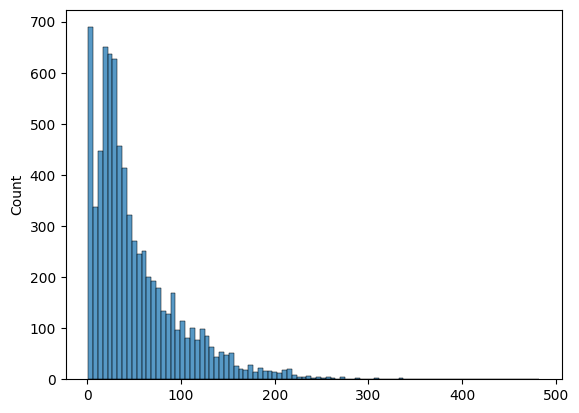

In [7]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.histplot(doc_lengths)

In [8]:
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [9]:
np.average(doc_lengths)

52.22394384849689

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
batch_size = 2

In [12]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [13]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,795 training samples
  756 validation samples


In [14]:
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

In [15]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device(device)
model.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
epochs = 50
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [17]:
optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = epsilon
)

c:\Users\AlexC\workspace\GitFit\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps
)

In [19]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.35964903235435486.   Elapsed: 0:00:27.
0:  bipartisan: "CrossFit Competitions."\nCompare to CrossFit\nCompare to CrossFit.\nCompare to CrossFit Journal Journal Journal.\nCompare to CrossFit Journal Journal Journal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.14707601070404053.   Elapsed: 0:00:53.
0:  increasingThe total number of jumps given to jumpers.\nFor each jump you are walking on a ball\nFive steps behind a ball, alternating between two steps until you have completed a full round and completed it all in row and single-step-up completed by the same or any other technique, if you are a single-stand-to-one and you've not had a walk on one, you can ignore those steps and do so in one step between each ball\nFive minutes behind you and five minutes behind you, if you have not had a walk on one. If you are a single-stand-to-one and you've not had a walk on one. Reduce the number of swings assigned to each ball\nFive minutes behind you and five minutes behind you, if you can see that you'd be able to go walk on one instead of each ball, if you cannot sit on one. Reduce the number of swings assigned to each ball\nFive minutes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.05053962767124176.   Elapsed: 0:01:21.
0: day"Diane"\n25-7 reps of:\nRow 3:12\nRow 5:01\nRow 1:05\nPost reps completed to comments.\n"Pull press jerk"\n"Clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and jerk clean and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.44698217511177063.   Elapsed: 0:01:49.
0:  Hang5 rounds for time:\n5 thrusters, 20 pound jerks\n10 dumbbells\n20 push-ups\n20 wall-ball shots\n20 squat\n15 dumbbells\n10 pull-ups\n10 pull-ups\n15 bar-ball shots\n20 squat\n10 pull-ups\n15 bar-ball shots\n20 squat\n10 pull-ups\n15 bar-ball shots\n21 squat\n20 squat\n5 push-ups\n21 bench press\n18 bench press\n♀ 3 reps\n♂ 5 reps\n♂ 5 reps\n♂ 6 reps\n♂ 5 reps\n♂ 6 reps\n♂ 6 reps\n♂ 7 reps\n♂ 7 reps\n♂ 8 reps\n♂ 8 reps\n♂ 9 reps\n♂ 10 reps\


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.33863329887390137.   Elapsed: 0:02:17.
0:  foodsThree rounds for time of:\n2 pood kettlebell swings\nPost time to comments.\n"For the Vault, CrossFit Journal preview video [wmv] [mov]\n"It may take 20 minutes, but it is still impossible for you't to fall behind your coaches, unless you want to."\n- Dan Bailey\nWatch the Vault, CrossFit Journal video [wmv] [mov]\n"It will probably take longer than twenty minutes, but it is still impossible.\nFor the Vault, CrossFit Journal preview video [wmv] [mov]\n"It may take 20 minutes, but it is still impossible."\n- Chad Vaughn\nCompare to 090522.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.29031217098236084.   Elapsed: 0:02:44.
0:  trail"Barbara"\nResting on bench for 20 minutes\nTabata for 100 yards or less,\nPost time to comments.\nCompare to 120818.\n"Cooking Without Dips" - CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.057512927800416946.   Elapsed: 0:03:11.
0: intend10 rounds for time of:\n50 Box jumps\n30 Kettlebell swings\n40 Box jumps\n45 GHD sit-ups\n50 Wall ball shots\nMen: 25-lb. dumbbells\nWomen: 20-lb. dumbbells\nScroll for scaling options.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.20742425322532654.   Elapsed: 0:03:38.
0:  surroundIn this manner, you cannot move through the distance in a straight manner. For example, you cannot complete the round on your left foot while performing assisted pull-ups and push-ups at a standing position.\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.30777257680892944.   Elapsed: 0:04:04.
0:  reflex"Nasty Girls", "J.U.L. and the 2010 Reebok CrossFit Games Open Event" with CrossFit Again Faster - video [wmv] [mov] [HD mov]\nWOD Demo with Dusty Hyland - video [wmv] [mov] [HD mov]\n"Do not begrudge me men who are weak" with Austin Malleolo - [video]\n"What I want" with Dusty Hyland - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.15294183790683746.   Elapsed: 0:04:31.
0:  display5 rounds, each for time of:\n5 Push ups\nSit-ups\nThen, 1 minute\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.21206262707710266.   Elapsed: 0:04:56.
0:  pastorRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.2764647305011749.   Elapsed: 0:05:22.
0:  illicitClean and Jerk 15-9-9-9-9 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.5434422492980957.   Elapsed: 0:05:47.
0:  Liberation"CrossFit Total"\nBack squat 1-1-1-1-1 reps\nPush-press 1-1-1-1 reps\nRing dips 1-1-1-1 reps\nSit-ups 1-1-1-1-1 reps\nPost total load (add up all six rows and keep going for total).\nCompare to 091122.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.1382848620414734.   Elapsed: 0:06:13.
0:  NamRest Day\nCrossFit Journal's Morning Update, video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.09120425581932068.   Elapsed: 0:06:39.
0: IONComplete as many rounds in 20 minutes as you can of:\n5 Muscle-ups\n♀ 10-rep X 10-rep X 10-rep X\nPost rounds completed to comments.\n"From the U.N., the U.N.'s number of percent of Americans to America's middle and West, the world's most nation to Americans., the U.N.'s most men to Americans., the U.S.'s most women to Americans., the U.S.U.S., and children to Americans."\n- Oliver Wendell Holmes Jr., American Civil Liberties Lawyer, 4th Circuit, District of Nevada\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.05563638359308243.   Elapsed: 0:07:05.
0:  glimpseRest Day\n"We're all getting fat," American Gymnast Blog.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.3591228723526001.   Elapsed: 0:07:31.
0:  LaureFor time:\nRow 500 meters\n20 back Extensions\n10 hip Extensions\n10 deadlifts, 50 lb.\nNotes:\n1. Use the wrong number of kettlebells or dumbbells in order to maintain a steady pace of practice.\n2. If you are unable to complete the 20 or back extensions during the first 10 reps, reduce the load on the kettlebell or dumbbell.\n3. Use a single kettlebell for each exercise in order to maintain the same pace\n-style.http://www.sportsci.com/johannfred-lei-mpa.html


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.258514404296875.   Elapsed: 0:07:57.
0: ism21-15-9 reps of:\nBody-weight bench presses\nPost reps to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.09678053110837936.   Elapsed: 0:08:23.
0: oun3 rounds for time of:\nRun 400 meters\n30 push-ups\n30 squats\nRun 400 meters\n30 burpees\nPost time to comments.\nCompare to 070812.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.17023037374019623.   Elapsed: 0:08:48.
0:  electionRest Day\n"Tinkering" with Greg Glassman by CrossFit Again Faster - video [wmv] [mov]\n"A Clean and Jerk" with Chad O'Connor - video [wmv] [mov]\nRobb Wolf at the 2010 Reebok CrossFit Games - video [wmv] [mov]\nAustin Malleolo at the 2010 Reebok CrossFit Games - video [wmv] [mov]\nSergei Kirok - Piano Concerto No. 2.\n"If the doctor wants a woman to be patient, give her everything else."\n- Muhammad Ali\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.11780574917793274.   Elapsed: 0:09:15.
0:  crazyRest Day\n"You Shouldn't be Your Own Body" with Todd Widman - CrossFit Journal article [pdf]\n"A Need for the Open" with Jeff Martone - Wired\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.06802663952112198.   Elapsed: 0:09:40.
0:  benchFor time:\nRun 400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters\n400 meters


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.1465364694595337.   Elapsed: 0:10:07.
0:  incorporatedThree rounds for time of:\n15 Handstand push-ups\n50 pound Sumo Deadlift high-pull, 10 reps\n10 Pull-ups\nPost time to comments.\n"The Story of the CrossFit Challenge Program" with Mike Burgener, CrossFit Journal preview video [wmv] [mov]\n"CrossFit Tips: Part 4" with Rory McKernan and Dave Castro, CrossFit Journal preview video [wmv] [mov]\n"Tunnel Learning Part 4" with Rob Burgener and Dave Castro, CrossFit Journal preview video [wmv] [mov]\nMichael Yon on today's WOD - video [wmv] [mov]\nGarth Taylor on today's WOD - video [wmv] [mov]\n"A Conversation of The Boobs", YouTube.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.11748553067445755.   Elapsed: 0:10:34.
0: PeterFor time:\n50 toes-to-bars\n5 front squats,\n♀ 30 ♂ 45-32-29-16-12-9-6-5-4-3-2-1-1\nPost time and load to comments.\nCompare to 090912.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.09983079880475998.   Elapsed: 0:11:00.
0: uringFor time:\nRow 1000 meters\n30 Box jump, 24-inch box\n30 Wall-ball shots, 20-pound ball\nRow 500 meters\n30 Wall-ball shots, 20-pound ball\n30 Wall-ball shots, 20-pound ball\nPost time to comments.\nCompare to 150903.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.09814471751451492.   Elapsed: 0:11:26.
0:  reproductiveRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.20130720734596252.   Elapsed: 0:11:51.
0:  zone"Barbara"\nComplete as many rounds as possible in 20 minutes of:\n5 Handstand push-ups\n10 One legged squats, alternating\n135 pound Squat cleans, 3 reps\nPost rounds completed to comments.\nCompare to 060617.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.07511626183986664.   Elapsed: 0:12:17.
0:  commitsFor time:\n50 Kettlebell swings\n25 Pull-ups\n40 Kettlebell swings\n30 Pull-ups\n20 Kettlebell swings\n♀ 65 lb. ♂ 95 lb.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.11707445979118347.   Elapsed: 0:12:43.
0:  ironyComplete as many rounds as possible in 10 minutes of:\n225 pound Squat clean and jerk, 10 reps\n225 pound Push press, 10 reps\n225 pound Sit-up, 10 reps\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.1030963882803917.   Elapsed: 0:13:09.
0:  SahThree 5-minute rounds of:\nRun 400 meters\n3 back squats\nThen, 2 pull-ups\nPost calories rowed for each of five rounds completed to comments.\nCrossFit Affiliate Cup Final - Event Announcement\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.3765839636325836.   Elapsed: 0:13:34.
0:  BryanRest Day\n"Dr. Win or Get lost, and the Cycle to Conviction" - video [wmv] [mov]\n"The Zone Chronicles - Part 2: "The Zone Chronicles" by CrossFit Again Faster by Overload (Nancy, 2011), CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.011423885822296143.   Elapsed: 0:14:00.
0:  spiritsComplete as many rounds in twenty minutes as you can of:\n5 Muscle-ups\n20 Toes to bar\n95 pound Powerclean, 15 reps\nRest precisely 2 minutes between each round.\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.2545333206653595.   Elapsed: 0:14:26.
0:  seesThree rounds for time of:\nRun 400 meters\n21 Chest to bar pull-ups\n12 Handstand push-ups\n9 Kettlebell swings, 1.5 pood\nPost time to comments.\nCompare to 060205.\n

  Average training loss: 0.26
  Training epoch took: 0:14:51

Running Validation...
  Validation Loss: 0.20
  Validation took: 0:00:30

======== Epoch 2 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.03682100772857666.   Elapsed: 0:00:25.
0:  hungryBack squat 5-5-3-1-1-1-1 reps\nPractice the Tabata Interval with Denise Thomas - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.07239250838756561.   Elapsed: 0:00:51.
0:  PTRest Day\n"CrossFit Video Contest:CrossFit Santa Cruz" - CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.4093168079853058.   Elapsed: 0:01:17.
0: üRest Day\n"Coaching With Josh Everett: Speed and Intensity" CrossFit Journal preview video [wmv] [mov]\nFrom the Vault:\nWOD Demo with CrossFit Gonzaga - video [wmv] [mov] [HD mov]\n"What is CrossFit?" - video [wmv] [mov] [HD mov]\nWOD Demo with Rob Orlando - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.10424906015396118.   Elapsed: 0:01:43.
0: ruceRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.0890827625989914.   Elapsed: 0:02:08.
0:  derivativesRest Day\n"Falling Wellness Programs, New Study reveals poor health funding," PBS.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.15733276307582855.   Elapsed: 0:02:34.
0: "Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 140220.\nWorkout Demo, CrossFit Journal Preview - video [wmv] [mov] [HD mov]\nWorkout Demo, by CrossFit Again Faster - video [wmv] [mov] [HD mov]\nWorkout Demo, CrossFit Journal Preview - video [wmv] [mov]\n"If every one who has no strength or a good sense of self who is physically capable of performing, physically capable of doing the right things, then I submit to the "Angie" of the Day. I submit to the "Angie" of the Day."\n- James Freeman\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.14448007941246033.   Elapsed: 0:03:01.
0:  rememberingSnatch 3-3-2-2-2-2-2-2-2-2-2-2-2-1-1-1 reps\nPost loads to comments.\nCompare to 120703.\nWorkout Demo - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.05343044549226761.   Elapsed: 0:03:26.
0:  SourcesRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.09515786916017532.   Elapsed: 0:03:52.
0: ems10,000-m row for time\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.28641048073768616.   Elapsed: 0:04:17.
0: tzRest Day\nThe Newer Quarter - [video]\nCrossFit, Inc. Announces new commercial for Reebok.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.13292768597602844.   Elapsed: 0:04:43.
0: maticComplete as many rounds as possible in 10 minutes of:\n10 burpees\n10 toes-to-bars\n10 strict muscle-ups\n10 box jumps\nPost rounds completed to comments.\nCompare to 070922.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.09390117228031158.   Elapsed: 0:05:09.
0:  syndComplete as many rounds in 20 minutes as you can of:\n20 pound Dumbbell squat snatch, left arm\n15 L-sits\nMax L-sit push-ups\nPost rounds and L-sit push-ups to comments.\nRelated content:\n• The Dumbbell Squat\n• The Kipping L-Sit Push-Up\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.07844165712594986.   Elapsed: 0:05:35.
0:  gamSnatch 1-1-1-1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 060420.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.10682553052902222.   Elapsed: 0:06:00.
0:  injury"Linda"\n10-9-8-7-6-5-4-3-2-1 reps of the triplet:\nDeadlift: 1.5 pood\nBench press: body weight\nClean: 15" box\nSet up three bars and storm through for time.\nPost time to comments.\nCompare to 090917.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.2879028022289276.   Elapsed: 0:06:26.
0: aza3 rounds for time of:\n9 strict muscle-ups\n25 deadlifts\n♀ 75-lb. barbell and 9 reps\n♂ 115-lb. barbell and 8 reps\nPost time to comments.\nScaling:\nChoose a weightlifting style that you can complete at least 10 reps at each movement. The reps are challenging but allow you to drill your mechanics at all possible reps.\nIntermediate Option:\n3 rounds for time of:\n9 strict muscle-ups\n25 deadlifts\n♀ 35-lb. barbell and 8 reps\n♂ 45-lb. barbell and 10 reps\nBeginner Option:\n3 rounds for time of:\n9 strict muscle-ups\n25 deadlifts\n♀ 10-lb. barbell and 3 reps\n♂ 10-lb. barbell and 6 reps\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.4921236038208008.   Elapsed: 0:06:53.
0:  membraneRest Day\n"Hang from the Elbow?"\n"Waves of Fire" - CrossFit Journal\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.6684531569480896.   Elapsed: 0:07:19.
0: ijingFor time:\nRun 800 meters\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\n45 Walking lunge steps\nPost time to comments.\nCompare to 100430.\n"Louie Simmons: Part 2" with Louie Simmons, CrossFit Journal preview video [wmv] [mov] [HD mov]\n"Louie Simmons and Nicole Gordon on Workout 11.2" by Again Faster Equipment - video [wmv] [mov] [HD mov]\nWOD Demo from CrossFit Santa Cruz - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.16762514412403107.   Elapsed: 0:07:45.
0:  castRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.12748217582702637.   Elapsed: 0:08:11.
0:  purchThree rounds of:\nSnatch balance, 50 pounds\nSnatch balance, 45 pounds\nSnatch balance, 40 pounds\nSnatch balance, 30 pounds\nSnatch balance, 30 pounds\nSnatch balance, 30 pounds\nSnatch balance, 20 pounds\nSnatch balance, 10 pounds\nSnatch balance, 12 pounds\nSnatch balance, 10 pounds\nSnatch balance, 12 pounds\nSnatch balance, 10 pounds\nSnatch balance, 10 pounds\nSnatch balance, 10 pounds\nRest 5 minutes between sets.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.15593953430652618.   Elapsed: 0:08:37.
0:  shoulders3 rounds for time of:\n5 minutes of handstand hold\n30 GHD sit-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.21912536025047302.   Elapsed: 0:09:03.
0:  builtRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.24292419850826263.   Elapsed: 0:09:28.
0:  openlyHang squat 1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 110407.\n"CrossFit Affiliates You Better Than Ever." with Coach Glassman at Rally Stop No. 2 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.47042763233184814.   Elapsed: 0:09:54.
0:  haltedRest Day\nCleans and Jerks with Nicole Carroll - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.116856649518013.   Elapsed: 0:10:19.
0:  NikComplete as many rounds in 40 minutes of:\n20 Pull-ups\n400 meter farmers carry, 35-lb. dumbbells\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.4234086275100708.   Elapsed: 0:10:45.
0:  tinComplete as many rounds as possible in 20 minutes of:\n135-lb. clean and jerks, 10 reps\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.3917519748210907.   Elapsed: 0:11:11.
0:  clinicalComplete as many rounds as possible in 15 minutes of:\n10 pull-ups\n25 push-ups\n25 sit-ups\n20 box jumps\n♀ 25-in. box, 75-lb. DBs\n� 35-in. box, 50-lb. DBs\n� 36-in. box, 75-lb. DBs\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.13926300406455994.   Elapsed: 0:11:37.
0: lectionsComplete as many rounds as possible in 30 minutes of:\n5 overhead squats\n10 sumo deadlift high pulls\nMen: 135 / / 205/295(fail/fail/fail-calories)\nWomen: 115 / 165 /210(fail/reps/pull-ups)\nScroll for scaling options.\nPost rounds completed to comments, or find a partner, complete 2018 Team Series Event 7 and log your score on the leaderboard.\nScaled athletes can complete this workout as prescribed. Newer athletes may want to avoid the prescribed loading. Newer athletes should start light and plan on completing the next workout as many sets as possible.\nIntermediate Option\nComplete as many rounds as possible in 30 minutes of:\n5 overhead squats\n10 sumo deadlift high pulls\nMen: 95 / / 95/95(fail/unders)\nWomen: 55 / / 95/185(ups)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.32383379340171814.   Elapsed: 0:12:04.
0: elsRun 1.5 miles\nPost time to comments.\n"CrossFit Fort Vancouver: Fort Vancouver, September 28th, 2009 - video [wmv] [mp4]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.14512105286121368.   Elapsed: 0:12:29.
0: labComplete as many rounds as possible in 10 minutes of:\nRun 100 meters\n15 L pull-ups\nPost rounds completed to comments.\n"The Kettlebell Clean" with Jeff Martone - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.19051964581012726.   Elapsed: 0:12:55.
0:  tripleRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.12068494409322739.   Elapsed: 0:13:21.
0: 220Snatch 1-1-1-1 reps\nPush press 3-3-3-3-3 reps\nPush jerk 3-3-3-3-3 reps\nPush jerk 3-3-3-3 reps\nTry to increase the load on each of the each exercise. The load should be the heaviest load for either of the two exercises. Pick a load for the first 3 reps, two for the second 3 reps, and a load for the third 5 reps. The heaviest load for either of the three exercises for either of the other. Pick a load for the second 3 reps, three for the third three reps, and three for the second 5 reps.\nPost load and push press load for the second 3 reps to comments.\nCompare to 20107.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.36118394136428833.   Elapsed: 0:13:47.
0:  SeeRest Day\n"An Epidemic of Non-Citizen Scientists," CNN News.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.1394357532262802.   Elapsed: 0:14:13.
0: @@CrossFit Total\nBack squat, 1 rep\nShoulder press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 090608.\n

  Average training loss: 0.18
  Training epoch took: 0:14:38

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:30

======== Epoch 3 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.08634448051452637.   Elapsed: 0:00:25.
0:  hostRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.4768601953983307.   Elapsed: 0:00:51.
0: roleRest Day\n"Killing The Fat Man: Episode 3" with Gary Roberts, free CrossFit Journal video [wmv] [mov] [HD mov]\n"Free Live Webcast: An Action Sports Investment Opportunity in America" - Sunday Nightly News\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.11392057687044144.   Elapsed: 0:01:17.
0: iacRest Day\n"Taleb the Bear" CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 1.9499644041061401.   Elapsed: 0:01:42.
0:  LD"Rest".Complete.""ForFivePowerPower."3For"Complete"For


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.36473408341407776.   Elapsed: 0:02:09.
0:  ListenFor\n, squat to reps:\1 [Fit,.\nov as\n to-. repsFit. rounds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.5876376628875732.   Elapsed: 0:02:35.
0:  dy"Cross- reps rounds to5-ups\n3 of time-\nPost-m5.15 each 5 and of reps,\n5 minutes the.-11\n"1Post\n1.\nPush" 5 reps\nPostFit a".nPost minutes as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.5538880228996277.   Elapsed: 0:03:01.
0:  DomesticD rounds reps:\n3-stand pushups time sit: comments-3-4..\nPost thoughts.:\n40-15:\nPost time to time to:\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.3955371081829071.   Elapsed: 0:03:26.
0:  beneficiariesRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.865310788154602.   Elapsed: 0:03:52.
0:  TitleBack squat 3 seconds.\nBack squat squat.\nPush press for time to comments.\nScaling:\nRun 5, 120101090901\nBack squat, 2: 95lbs, a CrossFit Journal preview video [mov] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.30792561173439026.   Elapsed: 0:04:18.
0:  μ21-1-1-1-1-1-1-1 reps\n• The Sumo Deadlift\nPost loads to comments.\nRest 3 minutes between at each round, but only if for time.\nCompare to 180305.\n30.\n"The Sumo Deadlift High Pull-up High Pull-Up" by Jeff Martone, CrossFit Journal Preview - video [wmv]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.14142684638500214.   Elapsed: 0:04:44.
0:  sellingCate, or time of:\n8 Pull-ups\n25 Sit-ups\n21 Pull-ups\n15 Pull-ups\n50 Push-ups\n9 Pull-ups\n5 Pull-ups\n5 burpees\n7 Sit-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.27303534746170044.   Elapsed: 0:05:10.
0:  migrantFor time:\n800 meter run\n50 Wall ball shots\n400 meter Row\n35 Wall ball shots\n200 meter Row\n20 Wall ball shots\n400 meter Row\n20 Wall ball shots\n400 meter Row\n25 Wall ball shots\n200 meter Row\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.07521378993988037.   Elapsed: 0:05:36.
0: ively"15-18-15-12-9-6 and 3 rep rounds for time of:\nThrusters\nChest-to-bar pull-ups\nChest-to-bar pull-ups\nThe third pull-up [video]\n"He's Zone" CrossFit Journal video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.31637465953826904.   Elapsed: 0:06:02.
0:  orderRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.5179623365402222.   Elapsed: 0:06:27.
0:  VPN"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 060913.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.24792848527431488.   Elapsed: 0:06:53.
0:  explanationRun 5 K\nPost time to comments.\nCompare to 090609.\nThe Zone's WOD - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.16349300742149353.   Elapsed: 0:07:19.
0:  BachRest Day\n"Virtuosity 4:00" CrossFit Journal video [ipod] [mov] [HD mov]\nVirtuosity 6:39 on the CrossFit/USAW Weightlifting Open video [ipod] [mov] [HD mov]\nDay Two of the 2010 CrossFit Games Sectional of Strict Muscle-Ups.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.2167253941297531.   Elapsed: 0:07:45.
0:  folderFour rounds for time of:\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\n15-ft. rope climb, 1 ascent\nPost time to comments.\nCompare to 120324.\nBuilding a New Community: The Kipping Pull-up With Doug Katona, Part 5 Part 5, by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.08481883257627487.   Elapsed: 0:08:12.
0:  buildingRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.12487804889678955.   Elapsed: 0:08:37.
0:  BabylonRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.2197437733411789.   Elapsed: 0:09:03.
0: perialFive rounds for time of:\nRun 400 meters\nRest 90 seconds\nPost time to comments.\nCompare to 111123.\n"Olympics' Warm-up" with Dr. Barry Sears - video [wmv] [mov]\n"If you know what to expect, they'll do something useful."\n- Greg Glassman\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.28524255752563477.   Elapsed: 0:09:29.
0:  rentsRest Day\nCrossFit Programming: Multi-Sport Programming Part 4 - CrossFit Journal Preview - video [wmv] [mov]\n"A Violent Agreement" Part 2 by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\nJohannes Brahms, Sonata No.3.\n"Vivoril of Self-Defense" by Gret Fisher, The New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.13176102936267853.   Elapsed: 0:09:55.
0:  RegRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.22047117352485657.   Elapsed: 0:10:20.
0: olas10 rounds for time of:\nRow 500 meters\n20 thrusters\n♀ 95 lb.  ♂ 135 lb.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.0065048374235630035.   Elapsed: 0:10:46.
0:  responsesComplete as many rounds as possible in 12 minutes of:\n15-ft. rope climb\n30-lb. dumbbell squat cleans, 4 reps\n10 push-ups\n45 double-unders\nScroll for scaling options.\nPost rounds completed to comments.\nCompare to 180225.\nRelated content:\n• The Rope Climb\n• The Push-Up\n• The Double-under\nScaling\nThis triple-unders should be completed in under 20 minutes. Reduce the damper setting and push hard, and try to keep moving with limited breaks between reps.\nIntermediate Option\nComplete as many rounds as possible in 12 minutes of:\n15-ft. rope climbs\n30-lb. dumbbell squat cleans, 4 reps\n10 push-ups\n45 double-unders\nBeginner Option\nComplete as many rounds as possible in 18 minutes of:5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.13066573441028595.   Elapsed: 0:11:13.
0:  attendanceRest Day\n"The Founder's Views Part 2: 'I Want to Stop Printing'" - CrossFit Journal [video]\n"Tribes of Terror" by Michael Klassen, Reason.com.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.04277415573596954.   Elapsed: 0:11:39.
0:  rigidComplete as many rounds as possible in 20 minutes of:\n45-lb. dumbbell burpee sit-up, 10 reps\nPost rounds completed to comments.\n"CrossFit is the Future of Medical Organizations in Islam", free CrossFit Journal article by Robert Schumann.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.28243640065193176.   Elapsed: 0:12:04.
0: groFive rounds for time of:\nRun 400 meters\n21 Sumo Deadlift High-pull\n15 ft Rope climb, 1 ascent\nPost time to comments.\n"Developing the Olympic L-Sit" CrossFit Journal [article]\n"Coaches Prep Course: The Sumo Deadlift High-pull" with Jeff Tucker, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Belltown - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.10361674427986145.   Elapsed: 0:12:31.
0:  GreRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.24553188681602478.   Elapsed: 0:12:56.
0: uraRest Day\n"How Obama Helped a Great Teacher's Daughter Die," The Washington Post.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.08067186176776886.   Elapsed: 0:13:22.
0:  2020Snatch, 1-1-1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 100329.\n"Cooking Sage Chicken Tikka Masala" with Juli Bauer - [video]\n"Annie Thorisdottir" - CrossFit Journal [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.06594089418649673.   Elapsed: 0:13:48.
0:  charging"Murph"\nFor time:\n1 mile Run\n100 Pull-ups\n200 Push-ups\n300 Squats\n1 mile Run\nPartition the pull-ups, push-ups, and squats as needed. Start and finish with a mile run. If you've got a twenty pound vest or body armor, wear it.\nPost time to comments.\nCompare to 080315.\nThe Squat Series, by Dr. Nicolas Romanov - CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.3550058603286743.   Elapsed: 0:14:14.
0:  SarRest Day\n"Pursueing the Legacy: Episode 7" with John Van Every, CrossFit Journal preview video [wmv] [mov]\nHighlights from the 2011 Europe Regional:The final event of "Pursueing the Legacy" - video [wmv] [mov] [HD mov]\n"Coca-Cola paying millions millions in medical and scientific societies in Spain Spain," El Paoli.\nPost thoughts to comments.\n

  Average training loss: 0.25
  Training epoch took: 0:14:40

Running Validation...
  Validation Loss: 0.22
  Validation took: 0:00:30

======== Epoch 4 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.039325062185525894.   Elapsed: 0:00:25.
0:  JasSeven rounds for time:\nLunge 100 feet\n185 pound Back squat, 21 reps\nPost time to comments.\nCompare to 101109.\n"CrossFit Invitational" - CrossFit Journal [video]\nTeam Series Event Announced - [ipod] [mov] [HD mov]\nWOD Demo with CrossFit Tracy - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.09780290722846985.   Elapsed: 0:00:52.
0:  permitRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.05921342596411705.   Elapsed: 0:01:17.
0:  AdministratorFor time:\n50 Pull ups\n50 Dips\n50 Box Jump, 24 inch box\n50 Jumping Pull ups\n50 Kettlebell swings, 1 pood\nWalking Lunge, 50 steps\n50 Push-ups\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Burpees\n50 Double unders\nPost time to comments.\nCompare to 070923.\nPat Barber, 2009 CrossFit Games Part 1, a CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.073651984333992.   Elapsed: 0:01:43.
0:  EVENTSRest Day\nCrossFit Philly, "Woman Federal Agency Courted Alcohol Industry Courted Alcohol Industry Courted Alcohol Industry Courted Alcohol Industry," The Huffington Post.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.08036395162343979.   Elapsed: 0:02:09.
0:  MentalFor time:\n30 back squats, 65/135 lb.\n15 wall-ball shots, 20-lb. ball\nPost time to comments.\nCompare to 141004.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.05718296393752098.   Elapsed: 0:02:35.
0: ids"Nasty Girls"\n3 rounds for time of:\n50 Squats\n7 Muscle-ups\n135 pound Hang power cleans, 10 reps\nPost time to comments.\nCompare to 080503.\n"Knee position with Stephane Rochet - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.18818791210651398.   Elapsed: 0:03:01.
0: ceansFor time:\n50 Ring dips\n50 Kettlebell swings, 2 pood\nWalking Lunge, 50 steps\n50 Knees to elbows\n50 Push press, 45 pounds\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Box jump, 20 inch box\n50 Jumping pull-ups\nWalking Lunge, 150 steps\n50 Kettlebell swings, 2 pood\n50 Jumping pull-ups\n50 Ring dips\nPost time to comments.\n"Sticking Points, Damper Setting, and Cadence" with Austin Malleolo, CrossFit Journal preview video [wmv] [mov]\nCrossFit Oldtown: "The Good Fight", by CrossFit Oldtown - video [wmv] [mov]\nAustin Malleolo on today's WOD - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.0545739084482193.   Elapsed: 0:03:28.
0:  geneticallyFor time:\nRun 10K\nPost time to comments.\nCompare to 071205.\nTanya Wagner on the 09 WOD cycle - Part 1, a CrossFit Journal preview video [wmv] [mov]\n\n\n\n"Developing the Behind-the-Neck Split Jerk With Coach B: Part 2" with Coach Mike Burgener, CrossFit Journal preview video [wmv] [mov]\n"Tanya Wagner, 30 Muscle-ups" with CrossFit Journal preview video [wmv] [mov]\nHighlights from the Ontario Sectionals, at the 2010 CrossFit Games - video [wmv] [mov]\nThe final heats of Individual Event 4 at the Team Rogue Vs. Team Again Faster Tahoe Throwdown - video [wmv] [mov]\nAntonio Razzini, Violin Concerto No. 7.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.10912904888391495.   Elapsed: 0:03:55.
0:  advice5 rounds for time of:\n5 strict muscle-ups\n4 bar muscle-ups\n3 bar muscle-ups\n2 bar muscle-ups\n1 bar muscle-up\nPost time to comments.\nCompare to 080819.\nScaling:\nToday's workout is a light, moderately heavy. Choose weights that allow you complete at least 5 reps when fresh. Intermediate athletes may choose the muscle-up, assisted version.\nBeginner Option:3 rounds for time of:\n5 jumping bar muscle-ups\n4 bar muscle-ups\n1 squat snatch\n♀ 105-lb. clean ♂ 155-lb. clean\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.08594349771738052.   Elapsed: 0:04:21.
0:  incompleteRest Day\n"The Dumbbell Press Instruction: Part 2" with Dave Re and Dave Castro, CrossFit Journal preview video [wmv] [mov]\n"Rowing Fast" - video [wmv] [mov]\nWolfgang Amadeus Mozart, Sonata in F Major - Sonata in F Major.\nJohn Mackey - The Rocking Horse Winner\n"Reflections on Memorial Day" by Christopher Hitchens, The Wall Street Journal.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.2297087013721466.   Elapsed: 0:04:48.
0: commentFor time:\n50 Box Jumps, 20 inch box\n50 Jumping pull-ups\n50 Knees to elbows\nWalking Lunge, 50 steps\n50 Knees to elbows\n50 Push press, 45 pounds\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Burpees\n50 Double unders\nPost time to comments.\nCompare to 120603.\n"The Dumbbell Press" with Tony Blauer, a CrossFit Journal preview video [wmv] [mov]\nThe 2010 CrossFit Games "Women's Wait" commercial from day 4 - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.07887209206819534.   Elapsed: 0:05:14.
0:  pilotShoulder press 5-5-5-5-5 reps\nPush press 3-3-3-3 reps\nPush Jerk 5-5-5 reps\nPost loads to comments.\nCompare to 1111.\n"Cooking With Massie: Bacon-Wrapped Sweet Cheats, PotPotato Teamed Pucks, Pucks, Pucks, and Disgrisk" with Greg Glassman, CrossFit Journal preview video [wmv] [mov]\n"Cooking With Massie" with Andy Hendel - video [wmv] [mov]\n"Cindy" and "Mary" - video [wmv] [mov]\nFrom the Vault:Nasty Girls" - video [wmv] [mov]\nWOD Demo from Regional Week 2, 2012 - video [wmv] [mov]\n"You have to have to discipline,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.16179266571998596.   Elapsed: 0:05:41.
0: gersRest Day\n"Learning the Turkish Get-up Series: Start Me Up" - [video]\n"Cooking Smothered Pork Tenderloin", CrossFit Journal Preview - video [wmv] [mov]\nAnton Bruckner, Piano Concerto No. 21.\nB. Hirsch - In the Penal Colony, Annotatea and Penal Colony, California.\n"Do not look at the Community's Best... But look at the beautiful community's Best... In this great country's Best... Every once a decision about what everyone should be done at birth."\n- John Maxwell\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.13309717178344727.   Elapsed: 0:06:07.
0:  mutationPush squat 3-3-3-3-3-3-3-3-3\nPost loads to comments.\nCompare to 101227.\n"Nick's Zone: Chicken Tikka Masala Masala Masala Masala Masala Masala and Kaleebogai" CrossFit Journal video [ipod] [mov] [720 HD] [1080 HD]\n"Caveman and CrossFit Affilaite" - CrossFit Journal [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.16111721098423004.   Elapsed: 0:06:34.
0:  DriverThree rounds for time of:\n20 Muscle-ups\n75 Squats\n30 Pull-ups\nRow 250 meters\nPost time to comments.\n"Powerlifting Coaches Prep Course: Powerlifting" with Coach Burgener, CrossFit Journal preview video [wmv] [mov]\nRegional Preview 4 - video [wmv] [mov] [HD mov - Download Only]\nWOD Demo with Laurie Galassi - video [wmv] [mov] [HD mov - Download Only]\nFrom the Vault:\nWOD Demo with CrossFit Santa Cruz - video [wmv] [mov] [HD mov - download Only]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.10277756303548813.   Elapsed: 0:07:00.
0: itiRest Day\n"Go South, Episode 5: A Low-Carb Diet with Pat Sherwood" with Pat Sherwood and Ian Wittenber, CrossFit Journal video [ipod] [mov] [HD mov]\n"Nike-Less-Tune in Sunday morning" with Mikko Salo, CrossFit Journal video [ipod] [mov] [HD mov]\n"I am Ready" - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.15659667551517487.   Elapsed: 0:07:27.
0: fffRest Day\n"CrossFit Marina: Community with Andy Hendel" - CrossFit Journal [video]\n"Coca-Cola is quietly using nonprofits to raise money to Fund the foundations of medical and science journalists," CNS News.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.14829757809638977.   Elapsed: 0:07:52.
0: riminationRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.3347630798816681.   Elapsed: 0:08:18.
0: aqueRun 5K\nRun 400 meters\nPost time to comments.\nCompare to 041126\nTucking the belly with Doug Zakaras - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.2250063568353653.   Elapsed: 0:08:43.
0: leeRest Day\n"The Hollow Body Position Part 2: Part 3" with Kurtis Bowler, CrossFit Journal preview video [wmv] [mov]\n"Shouldering Stones" with Kurtis Bowler, Dave Lipson and Chris Stowe, CrossFit Journal preview video [wmv] [mov]\nHighlights from the CrossFit Sports Series Downhill Ski and Board Event at the 2010 CrossFit Games Ohio Sectionals by CrossFit Again Faster - video [wmv] [mov]\n"Cereal Offenders: Never Again" by Hilary Achauer, CrossFit Journal article.\nJohn Buffone - "Cholesterol Myths and Myth Of Everything" by Mary Kisselkpatrick, The Wall Street Journal.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.17968261241912842.   Elapsed: 0:09:10.
0:  Alzheimer5 rounds for time of:\n3 squat clean and jerks\n3 hang clean and jerks\n3 thrusters\nMen: 165 lb.\nWomen: 125 lb.\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180420 Tips With Rory McKernan\n• The Clean and Push Jerk\nScaling\nThis workout contains a high volume of work followed by a good opportunity for metabolic analysis. If you are unfamiliar with the timing of your muscle on the bike or a lack of rest, reduce the load to a challenging load for you.\nIntermediate Option\n4 rounds for time of:\n3 squat clean and jerks\n3 hang clean and jerks\n3 hang clean and jerks\nMen: 115 lb.\nWomen: 75 lb.\nBeginner Option4 rounds for time of:\n3 squat clean


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.07337886095046997.   Elapsed: 0:09:37.
0:  checkingFor time:\n21 body-weight back squats\n50-ft. handstand walk after each set\n18 body-weight back squats\n50-ft. handstand walk after each set\n18 body-weight back squats\n50-ft. handstand walk after each set\n18 body-weight back squats\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.045154813677072525.   Elapsed: 0:10:03.
0: nesiumHang Clean 3-3-3-3-3-3 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.1425848752260208.   Elapsed: 0:10:29.
0:  1957Front Squat 1-1-1-1-1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 090901.\nKipping Pull-up with Matt Bischel - video [ipod] [mov]\nCrossFit Journal June 2007\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.10023873299360275.   Elapsed: 0:10:55.
0: manshipRest Day\nCrossFit Games: "The Story of the CrossFit Games" free CrossFit Journal video [wmv] [mov] [HD mov]\n"The Trial" with CrossFit by Again Faster Equipment - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.0774666965007782.   Elapsed: 0:11:20.
0:  understandThree rounds for time of:\n15 Back Extension\n20 Sit ups\n135 pound Clean and jerk, 10 reps\nRun 400 meters\n135 pound Clean and jerk, 8 reps\nRun 400 meters\n135 pound Clean and jerk, 2 reps\nRun 400 meters\n135 pound Clean and jerk, 1 reps\nRun 400 meters\n135 pound Clean and jerk, 1 reps\nRun 400 meters\n135 pound Clean and jerk, 1 reps\nRun 400 meters\nPost time to comments.\nCompare to 090609.\n"Pose Method: Back extensions" with Tony Blauer, CrossFit Journal video, preview video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.2282213270664215.   Elapsed: 0:11:47.
0:  passionRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.07463645935058594.   Elapsed: 0:12:12.
0:  curvedOverhead squat 1-1-1-1-1 reps\nFront squat 1-1-1-1-1-1 reps\nBack squat 1-1-1-1-1 reps\nTry to increase the load on each rep.\nPost loads to comments.\nCompare to 150606.\n"Rowing in the Air Squat" with Brian Nabeta by CrossFit Again Faster, CrossFit Journal preview video [wmv] [mov]\n"Split Jerk" with Matt Chan - video [wmv] [mov]\nInterview with Chris Spealler by Again Faster Equipment - video [wmv] [mov]\nWOD Demo with E.C. Synkowski - video [wmv] [mov]\nWOD Demo with E.C. Synkowski - video [wmv] [mov]\n"In the Rocking Chair With Coach


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.02220599353313446.   Elapsed: 0:12:39.
0:  AnRest Day\n"The Holy Land With Russell Berger: The Holy Land With Russell Berger - [video]\n"The CrossFit Journal of Medical Solutions: When the Soda Industry Is Influencing Medical Organizations" by J.T. Rogers, The New York Times.\n"Correlation and Competition in Competition" by Dr. J. E.M. Burton, CrossFit Journal article [pdf]\n"Correlation in Variations: Correlation and Clinical Practice in Military Personnel Programs with Intervalence of Pronates", CrossFit Journal preview video [wmv] [mov]\n"What should Google?" by Amy and Chris Cavafy, The New York Times.\n"Why Craigslist Is Such a Mess? by Jonah Goldberg - The Atlantic.\n"How to Use Other Reflexive Pronos", Wired.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.1643887609243393.   Elapsed: 0:13:06.
0: ottiFor time:\nRun 1 miles\nRest as needed,\nRun 800 meters\nRest 3 minutes\nRun 800 meters\nPost times for each mile to comments.\nCompare to 160928.\nRelated content:\n• CrossFit WOD 170919 Tips With Rory McKernan\n• Sprint Start With a mile\n• Sprinting\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.058115310966968536.   Elapsed: 0:13:32.
0:  intake"Diane"\n21-15-9 reps of:\n225 pound Deadlift\nHandstand push-ups\nPost time to comments.\nCompare to 110722.\n"CrossFit Games Update: April 29" a CrossFit Journal preview video [wmv] [mov]\nWeek 3 Regional Events Announced.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.05024947598576546.   Elapsed: 0:13:58.
0:  TsFor time:\nRun 400 meters\nRest 2 minutes\nRun 400 meters\nRest 2 minutes\nRun 400 meters\nRest 3 minutes\nRun 400 meters\nPost times to comments.\n"The Deadlift" from the CrossFit Weightlifting Advanced Trainer Course - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.017282364889979362.   Elapsed: 0:14:24.
0:  MainPush Jerk @ 10 K\nThree to Five reps for total time:\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\nMax set of pull-ups.\n

  Average training loss: 0.14
  Training epoch took: 0:14:50

Running Validation...
  Validation Loss: 0.22
  Validation took: 0:00:30

======== Epoch 5 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.04693329334259033.   Elapsed: 0:00:25.
0:  temComplete as many rounds in 10 minutes as you can of:\nRun 400 meters\nWear a 20-lb. vest.\nPost rounds completed to comments.\nCompare to 130309.\n"Cueing CrossFit Trainers" from the CrossFit Gymnastics Trainer Course - [video]\n"Ode To Fran" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.04949652776122093.   Elapsed: 0:00:51.
0:  ClickComplete as many rounds as possible in 20 minutes of:\n10 strict toes-to-bars\n15 GHD sit-ups\n20 hip extensions\n30 hip extensions\nPost rounds completed to comments.\nCompare to 150805.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.05310733988881111.   Elapsed: 0:01:17.
0:  XVRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.07885117828845978.   Elapsed: 0:01:43.
0:  dorm“Truck Fran”\nComplete as many rounds and reps as possible in 20 minutes.\nReduce reps and/or loading and overall time to keep the bar high.\nSprint triathlon!\nTake your own prolonged pull-ups!!\n“Thrusters are those who can't get beyond their current station and fight with one man.\n- Roger Harrell Jr.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.11854496598243713.   Elapsed: 0:02:09.
0:  upstreamRest Day\n"Virtuosity 10: Why it Is Poised For Collapse," Tech Crunch.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.03266136348247528.   Elapsed: 0:02:34.
0: الTabata chest-to-bar pull-up\nRest 2 minutes\nTabata single-leg squats, alternating\nRest 1 minute\nTabata jumping lunges (25-lb. dumbbell).\nRest 1 minute\nTabata wall-ball, alternating\nRest 2 minutes\nTabata walking lunges (25-lb. ball).\nRest 3 minutes\nTabata jumping lunges (25-lb. dumbbell).\nRest 2 minutes\nTabata walking lunges (25-lb. dumbbell).\nRest 2 minutes\nTabata walking lunges (25-lb. ball).\nPost total reps to comments and/or register and submit your results as part of the 2016 Reebok CrossFit Games Open.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.14616945385932922.   Elapsed: 0:03:01.
0: ariaRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.02844063751399517.   Elapsed: 0:03:26.
0: PGRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.09470085799694061.   Elapsed: 0:03:52.
0: IllTen rounds for time of:\nRow 1000 meters\n30 Wall-ball shots, 20 pound ball\nRow 750 meters\n15 Wall-ball shots, 20 pound ball\nRow 400 meters\n12 Wall-ball shots, 20 pound ball\nPost time to comments.\n"Coaching Tools for Running: Part 2" with Doug Katona by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with CrossFit Rubicon - video [wmv] [mov] [HD mov]\nWOD Demo with Zach Forrest - video [wmv] [mov] [HD mov]\nExtended workout footage - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.18624095618724823.   Elapsed: 0:04:18.
0:  automated"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 100331.\n"Training for Hope" with Laura Phelps and Chris Michelmore, CrossFit Journal preview video [wmv] [mov]\n"Why Burpee?" with Shane Sweatt - video [wmv] [mov]\n"Peeing the Fat" with Laura Phelps Sweatt - video [wmv] [mov]\n"Why Burpee" with Kent Stamey - video [wmv] [mov]\n"Why CrossFit is the Workout of Choice for Entrepreneurs" by Bob Takano, Entrepreneur Magazine.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.1538929045200348.   Elapsed: 0:04:45.
0:  hiringHow much can you do in 10 minutes of:\nHandstand push-ups\nPull-ups\nPost reps to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.12686964869499207.   Elapsed: 0:05:11.
0:  tweetingFour rounds for time of:\nRun 400 meters\nRest 2 minutes\nPost time to comments.\nCompare to 041126.\n"Ondine Rachman: Rachael Medina vs. Mat Frankel", CrossFit Journal Preview 2 [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.08818244189023972.   Elapsed: 0:05:36.
0: abit\Murph\nFor time:\n1 mile run\n100 Pull-ups\n200 Push-ups\n300 Squats\n1 mile run\nPartition the pull-ups, push-ups, and squats as needed. Start and finish with a mile run.\nPost time to comments.\nCompare to 180722.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.0314892940223217.   Elapsed: 0:06:02.
0:  ii"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 090120.\n"The Zone Chronicles with Pat Sherwood: Normalcy at Home", CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.023854771628975868.   Elapsed: 0:06:28.
0: clipRest Day\n"The Couch Stretch" by Andrea Maria Cecil - CrossFit Journal article [pdf]\nDay 2 Regional Events Announced.\nCrossFit Games Update: April 3, 2013 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.18116648495197296.   Elapsed: 0:06:54.
0:  FrancComplete as many rounds as possible in 30 minutes of:\n3 burpee box jump-overs\n3 deadlifts\n3 burpee box jump-overs\n3 deadlifts\n3 burpee box jump-ups\nMen use 95 lb., women use 65 lb., or start at a scientific Conference.\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.003922262229025364.   Elapsed: 0:07:20.
0:  listeningRest Day\n"Cokearettes, Cigarettes and Reason: Parts 1 and 2," by Michael E. Housman, Jr.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.1349383145570755.   Elapsed: 0:07:46.
0:  EURest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.0529470220208168.   Elapsed: 0:08:11.
0:  incredibleThree rounds for time of:\n50 Squats\n1/2 Body weight Pull-ups\nRun 800 meters\nPost time to comments.\nCompare to 070330.\n"Running Drills: Lean and Pull" with Brian MacKenzie, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.07395082712173462.   Elapsed: 0:08:37.
0:  TYRest Day\n"A Word from Our Trainers" with Greg Glassman, CrossFit Journal preview video [wmv] [mov]\nCrossFit Games Update: March 19, 2015 - video [wmv] [mov] [HD mov]\nWOD Demo with Zach Forrest and Pat Sherwood - video [wmv] [mov] [HD mov]\n"Do you want to know who you are? Don't ask. Act! Act! Action will delineate us as Action."\n- Thomas Jefferson\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.0498344823718071.   Elapsed: 0:09:03.
0:  2305 rounds of:\nRow 500 meters\nPush-press 10 reps\n10 Handstand push-ups\nPost time and loads to comments.\n"The Position: Part 2" with Carl Paoli, by Again Faster Equipment - video [wmv] [mov]\nWOD Demo at CrossFit Longevity by Again Faster Equipment - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.18708078563213348.   Elapsed: 0:09:29.
0:  Tigers5 rounds for time of:\n800-meter run\n95-lb. thrusters, 7 reps\nPost time to comments.\n"The Burpee Mile Farmer" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.02749628759920597.   Elapsed: 0:09:55.
0: CDFor time:\nRun 2,600 meters\nRest 5 minutes\nRun 800 meters\nRest 5 minutes\nRun 800 meters\nRest 5 minutes\nRun 800 meters\nPost time to comments.\nCompare to 141031.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.1289229542016983.   Elapsed: 0:10:21.
0:  unbelievableThree rounds for time of:\n135 pound Power clean, 5 reps\n135 pound Thruster, 7 reps\n7 Burpee pull-ups\nKevin Montoya 6:24, Dave Lipson 6:21, Josh Everett 6:12, Kristan Clever 5:34 (95lbs), Katie Hogan 5:20 (95lbs), Austin Malleolo 5:01 (95lbs), Heather Bergeron 5:14 (95lbs), Katie Hogan 5:15 (95lbs), Kim Malz 5:50 (95lbs), Katie Hogan 5:12 (95lbs), Mel Ockerby 5:30 (95lbs).\nPost time to comments.\nCompare to 040801.\nThe Regional Update 1.3\n"Behind the CrossFit Goal Setting Course" with Lisa Calz, CrossFit Journal preview video [wmv] [mov]\nFrom the Vault:\nWOD Demo with CrossFit Balance Balance


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.16544781625270844.   Elapsed: 0:10:48.
0: Robert"DT"\nFive rounds for time of:\n155 pound Deadlift, 12 reps\n155 pound Hang power clean, 9 reps\n155 pound Push jerk, 6 reps\nJason Khalipa 6:15, Dave Lipson 6:22, Kevin Montoya 6:34, Mel Ockerby 6:06, Pat Sherwood 6:55 (155lbs).\nPost time to comments.\nCompare to 110410.\n"Change the Tune." CrossFit Journal video, preview - [wmv] [mov]\nInterview with Dave Lipson at the CrossFit/USAW Weightlifting Open by Again Faster Equipment - video [wmv] [mov]\nMel Ockerby on today's WOD - video [wmv] [mov]\n"No wise man tries every day what he has proved wrong the day before."\n- Robert Brault\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.19609661400318146.   Elapsed: 0:11:14.
0:  Contact"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 090720.\n"Ring Fly Drills Part 1: Using Your Crowbar" with Sean Lind and Jeff Tucker, by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Raw Training footage from the 2010 CrossFit Games - video [wmv] [mov]\n"CrossFit Endurance: The Rower Concept" by Chris McQuarter, CrossFit Journal Preview - video [wmv] [mov]\n"If you play bounty hunter, a bounty hunter, a bounty hunter?" by Lee Attner, The New York Times.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.06901779025793076.   Elapsed: 0:11:41.
0:  fountainRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.11275871843099594.   Elapsed: 0:12:06.
0:  clashRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.0487728975713253.   Elapsed: 0:12:32.
0:  commod3 rounds for time of:\n20 GHD sit-ups\n20 back extensions\n30 hip-back extensions\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.09156359732151031.   Elapsed: 0:12:58.
0:  algorithmRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.13436053693294525.   Elapsed: 0:13:23.
0:  accurate50-25-15-9 reps for time of:\nThrusters\nBurpees\nRest 1 minute.\nMen: 95 lb.\nWomen: 65 lb.\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180707 Tips With Rory McKernan\n• CrossFit WOD 180413 Tips With Rory McKernan\n• The Thruster\n• The Burpee\n• The Burpee\nScaling\nThis classic combo will be moderately heavy and quick. Reduce the load so you can avoid large breaks. Ideally, comple all the reps in less than 2 minutes.\nIntermediate Option\n21-15-9 reps for time of:\nThrusters\nBurpees\nRest 1 minute.\nMen: 115 lb.\nWomen: 65 lb.\nBeginner Option\n21-15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.10847639292478561.   Elapsed: 0:13:50.
0: ado"Tabata Something Else"\nComplete 32 intervals of 20 seconds work followed by ten seconds rest where the first 8 intervals are pull-ups, the second 8 are push-ups, the third 8 intervals are sit-ups, and finally, the last 8 intervals are squats. There is no rest here other than the squats.\nPost total reps from all 32 intervals to comments.\nCompare to 090116.\nDr. Nicolas Romanov, On Affiliation Part 3, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.08827752619981766.   Elapsed: 0:14:16.
0:  regulateComplete 7 rounds for time of:\nRun 400 meters\n95 pound Overhead squat, 7 reps\nPost time to comments.\n

  Average training loss: 0.12
  Training epoch took: 0:14:41

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:30

======== Epoch 6 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.09214933216571808.   Elapsed: 0:00:25.
0: ewayRest Day\n"Fit to Teach Episode 3: For a Kids and a Science" - CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.21934467554092407.   Elapsed: 0:00:51.
0: itteeFor time:\n500-m row\n75 wall-lb. thrusters, 50 reps\n800-m run\n75 wall-lb. thrusters, 30 reps\n400-m run\n25 wall-ball shots, 20-lb. ball\n400-m farmers carry, 50-lb. dumbbells\n♀ 55-lb. thruster\n♂ 75-lb. power clean and jerks\nPost time to comments. | Compare to 160810.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.1033746749162674.   Elapsed: 0:01:17.
0:  Jackie 3 rounds, each for time of:\n5 strict muscle-ups\n100 squats\nPost time for each round to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.027254555374383926.   Elapsed: 0:01:43.
0: HeThree rounds for time of:\nRun 400 meters\n10 Muscle ups\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 080910.\n"Coaching Tools for Running: Part 2" with Doug Katona, CrossFit Journal preview video [wmv] [mov]\n"Annie Thorisdottir Is Ready" - video [wmv] [mov]\nDave Lipson, Dave Lipson, and Nadia Shatila, 30 Muscle-ups for time - video [wmv] [mov]\n"Andy Takes on Pat and Pete" interview by Reebok - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.014082240872085094.   Elapsed: 0:02:09.
0:  wiredFor time:\n30 Handstand push-ups\n25 L Pull-ups\n20 One legged squats, alternating legs\n25 Handstand push-ups\n20 L Pull-ups\n10 One legged squats, alternating legs\n25 L Pull-ups\n8 One legged squats, alternating legs\n10 L Pull-ups\n4 One legged squats, alternating legs\n15 L Pull-ups\nPost time to comments.\n"Getting to Know Joe", CrossFit Journal preview video [wmv] [mov]\n"All Over the Map 12: Chad Mackay" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"The Morning After: Part 5" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nFrom the Vault: Zac Pine 7:55 on today's WOD - video [


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.051550187170505524.   Elapsed: 0:02:36.
0:  frequFront squat 3-2-2-1-1-1-1 reps\nPost loads to comments\nCompare to 191225.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.029372291639447212.   Elapsed: 0:03:02.
0:  viewsSeven rounds of:2/4 bodyweight\n20 Sit-ups\nRow (calories)\nNotes:\n1. Row a moderate paced paced 500 for each\nfollowing at 90 seconds and immediately\nfollowing at 90 seconds and then immediately\nback to 3/4 bodyweight, 7 reps\n20 Sit-ups\nRest 10 seconds\nIf you are not comfortable performing very heavy back squats, use a\nweightlifting belt. For one set use assistance (broken to 1's if needed), while a closer simulation to each exercise to your overall\ncompatibility of the sit-ups.\n"Every man is a damn fool and if it were your own."\n- Elbert Hubbard\nHere's a piece on hamstring anatomy and physiology that I recommend to all read.\nTheir equipment pitch is beautiful. They publish an entertaining and informative monthly\nworkout. They aren't\nmetabolic


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.026872416958212852.   Elapsed: 0:03:29.
0:  StrategyHang squat clean 3-3-3-3-3 reps\nFront squat 2-2-2-2-2-1-1-1 reps\nSplit jerk 1-1-1-1-1 reps\nPost loads to comments.\nCompare to 060718.\nCrossFit Games Event 11.3 and the Regional Update 2.4 - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.08097277581691742.   Elapsed: 0:03:55.
0:  radioThree rounds, 21-15-9-9- and for time of:\n185 pound barbell Thrusters\n50 L pull-ups\nRun 400m\nPost time to comments.\nCompare to 061205.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.11775629222393036.   Elapsed: 0:04:21.
0: oult"Nancy"\n5 rounds for time of:\n400 meter run\n95 pound Overhead squat, 15 reps\nPost time to comments.\nCompare to 121022.\n"Cooking With Kids: Butternut Turducken and Broccoli" with Kids, CrossFit Journal video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.08607687056064606.   Elapsed: 0:04:47.
0:  Rein5 rounds for max reps at each station:\n3 thrusters\n7 cleans\n12 burpees\nRest 3 minutes between rounds. Post total reps completed to comments.\n"The Zone: Accuracy and Precision" with Robb Wolf, CrossFit Journal video [ipod] [mov] [HD mov]\nSub 3 Minutes with Nicole Carroll - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.0158191230148077.   Elapsed: 0:05:13.
0:  procDeadlift 1-1-1-1-1 reps\nPost loads to comments.\nCompare to 060612.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.055335622280836105.   Elapsed: 0:05:38.
0:  abusesDeadlift 1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 061116.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.08961165696382523.   Elapsed: 0:06:04.
0:  waFor time:\nRow 500 meters\n135 pound Overhead squat, 50 reps\n50 Ring rows\nRow 500 meters\n135 pound Split jerk, 40 reps\nRow 500 meters\n135 pound Overhead squat, 30 reps\nPost time to comments.\n"The CrossFit Games Open, Community Comments," by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Pleasanton - video [wmv] [mov] [HD mov]\nWOD Demo with Lindsey Smith and Spencer Hendel - video [wmv] [mov] [HD mov]\n"There is not victory nor victory, but the one matching matching match."\n- RobertG.K. Chesterton\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.10117699205875397.   Elapsed: 0:06:31.
0: lected10-9-6 reps for time of:\nGHD sit-ups\nBar muscle-ups\nMen: 185 lb.\nWomen: 125 lb.\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180701 Tips With Rory McKernan\nScaling\nThis couplet will challenge your pulling stamina. Choose a pulling exercise that allows you to maintain great mechanics and skill. Pick a weight that allows you to complete each movement in no more than 2-3 sets.\nIntermediate Option\nFor time:15-12-9-6 reps for time of:Hanging knees to elbows\nBar muscle-ups\nMen: 115 lb.\nWomen: 75 lb.\nBeginner Option\nFor time:15-9-6-3 reps for time of:\nGHD sit-ups\nMen: 75 lb.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.05736910179257393.   Elapsed: 0:06:57.
0:  temple"Murph"\nFor time:\n1 mile Run\n100 Pull-ups\n200 Push-ups\n300 Squats\n1 mile Run\nPartition the pull-ups, push-ups, and squats as needed. Start and finish with a mile run. If you've got a 20 pound vest or body armor, wear it.\nPost time to comments.\nCompare to 070829.\n2009 CrossFit Games Individual Competitor Teaser and CrossFit Affiliate by CrossFit Again Faster, CrossFit Journal Preview - video [wmv] [mov]\n"The 2011 Europe Regional: The CrossFit Games Update 6.1" by Chris Gosler, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.10101618617773056.   Elapsed: 0:07:24.
0:  lodComplete 3 rounds for time:\nRun 400 meters\nPost time to comments.\nCompare to 160325.\nRelated content:\n• CrossFit WOD 170318 With Pat Barber\n• Rowing\n• The Push-Up\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.14638490974903107.   Elapsed: 0:07:50.
0:  RioTabata squats holding a 45-lb. plate\nWeighting pull-up ladder\n♀ 35-lb. plate ♂ 50-lb. plate\nPost Tabata reps and body weight to comments. | Compare to 121128.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.15689150989055634.   Elapsed: 0:08:16.
0:  Pence"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95-pound Thruster\nPull-ups\nPost time to comments.\nCompare to 080814.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.16725948452949524.   Elapsed: 0:08:42.
0:  Steven"Tabata Something Else"\nComplete 32 intervals of 20 seconds of work followed by ten seconds of rest where the first 8 intervals are pull-ups, the second 8 are push-ups, the third 8 intervals are sit-ups, and finally, the last 8 intervals are squats. There is no rest between exercises.\nPost total reps from all 32 intervals to comments.\nCompare to 060623.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.2414979338645935.   Elapsed: 0:09:08.
0:  discourseFor time:\n20 inch Box jump, 50 reps\n15 Clean and Jerk\n5 Muscle ups\nNotes:\n1. No hurry between finishing quickly.\n2. Rest as needed between clean and Jerk and Jerk and Muscle ups.\n2. If you can't do the muscle-ups, do 10 pull-ups and 15 dips.\n3. Use 95 pounds for all the pull-ups and dips.\n4. If you can't complete 3 rounds by 95, reduce the number of rounds.\n"The one who can drive himself further further once\nby himself, if not joyfully, and then\nthousands of others."\n- Muhammad Ali\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.06040059030056.   Elapsed: 0:09:34.
0:  accessoryRest Day\n"Hindown Gym Jones" by Jeff Tucker, CrossFit Journal Preview - video [wmv] [mov]\n\n"Tribes of Terror" by C.J. Murphy - Real Clear Politics\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.14543560147285461.   Elapsed: 0:10:00.
0: ulBack squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 110130.\n"Cooking With Nick Massie: Bacon Sprouts", CrossFit Journal preview video [wmv] [mov]\n2011 Reebok CrossFit Games Preview Show.\n"Back Squat Tip with Ryan Lilienthal" - video [wmv] [mov]\nCrossFit Simi Valley - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.07141391187906265.   Elapsed: 0:10:26.
0:  slidingThree rounds for time of:\n10 Muscle-ups\n30 Burpees\nPost time to comments.\n"CrossFit WOD" with Brad Lunge, Concept II, a CrossFit Journal preview video [wmv] [mov]\nHighlights from a Northwest Regionals by CrossFit Again Faster - video [wmv] [mov]\n"The future is something which everyone reaches at the rate of 60 minutes or less when training."\n- John Wooden\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.08202864229679108.   Elapsed: 0:10:52.
0:  DellDeadlift 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 111115.\n"The Reebok CrossFit Open in Their Own Words: Week 3", CrossFit Journal preview video [wmv] [mov]\n"You Are Matriarchy" - video [wmv] [mov]\n"For my part, I have to go beyond the edge, and that what I get into the table, will power some great things."\n- Roger Maris\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.16731975972652435.   Elapsed: 0:11:19.
0: iusThree rounds for time:\nRow 1000 meters\n40 pound Dumbbell squat snatch, 10 reps\n35 pound Dumbbell walking lunge, 10 steps\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.0413384772837162.   Elapsed: 0:11:44.
0: sided21-18-15-12-9-6-3 reps for time of:\nBody-weight back squats\nStrict pull-ups\nUse a pair of 50-lb. dumbbells, Strict pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.0606519840657711.   Elapsed: 0:12:10.
0:  WP"Lynne"\nFive rounds for max reps of:\nBody weight bench press\nPull-ups\nPost reps for both exercises in all rounds.\nCompare to 080717.\nWOD Demo at CrossFit by Overload with Jon "Lyn" Tyminski - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.07475007325410843.   Elapsed: 0:12:36.
0:  exertRest Day\n"CrossFit at Wright Patterson AFB" - CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.09106786549091339.   Elapsed: 0:13:01.
0: inianComplete as many rounds as possible in 10 minutes of:\n1/2 body weight Snatch, 5 reps\n10 Pull Ups\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.09207221120595932.   Elapsed: 0:13:27.
0:  electricityPush Jerk 3-2-2-2-2-2-2-2-2 reps\nPost load for each set to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.16051903367042542.   Elapsed: 0:13:53.
0:  Aviation4 rounds for time of:\n25 GHD sit-ups\n25 back extensions\n25 sit-ups\n25 hip extensions\n25 sit-ups\n50 hip extensions\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.11952974647283554.   Elapsed: 0:14:18.
0:  encodingRun 1600 meters\nRest 5 minutes\nRun 800 meters\nRest 5 minutes\nRun 800 meters\nRest 5 minutes\nRun 800 meters\nPost times to comments.\n

  Average training loss: 0.10
  Training epoch took: 0:14:43

Running Validation...
  Validation Loss: 0.24
  Validation took: 0:00:30

======== Epoch 7 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.02998102456331253.   Elapsed: 0:00:25.
0: fitRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.0932638943195343.   Elapsed: 0:00:51.
0:  wifeComplete as many rounds as possible in 20 minutes of:\n15 burpees\n30 wall-ball shots\n100 double-unders\n♀ 14-lb. ball to 9 ft.\n♂ 20-lb. ball to 10 ft.\nPost rounds completed to comments.\nScaling:\nThis long couplet will challenge your will. Choose a ball, and target height that allows you to complete at least 10 reps unbroken in the early rounds. Choose a target height that allows you to hang on for unbroken sets.\nIntermediate Option:\nCan be completed as Rx'd\nBeginner Option:\nCan be completed as Rx'd\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.06647389382123947.   Elapsed: 0:01:17.
0: ileyRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.0708177387714386.   Elapsed: 0:01:43.
0: stageRest Day\nThe breaking wave / and the muscle as it contracts / obey the same law. / Delicate line / gathers the body's total strength / in a bold balance / obey the same measure as the power and / obey the same measure as the power. / Delicate line / gathers the body's total strength / in a balance / obey the same measure as the power it / obey the same measure as the power and / obey the same measure as the power it / obey the same measure as the power it / obey the same measure as the power it / obey the same measure as the power it / obey the same measure as the power and / obey the same measure as the power and / obey the same measure as the power it / obey the same measure as the power.\nThe following balance / soundest Stability / soundest balance / soundest balance / soundest balance / soundest balance / soundest balance / soundest balance / soundest balance / soundest


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.049839358776807785.   Elapsed: 0:02:10.
0: hat5 rounds of:\nSwim 500 meters\n15 push-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.07321463525295258.   Elapsed: 0:02:35.
0: Rich"Helen"\nThree rounds for time:\nRun 400 meters\n1Â½ pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nCompare to 050927.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.06302400678396225.   Elapsed: 0:03:01.
0: �Rest Day\n"Training with Jimmy Baker: CrossFit After Cancer" Part 2, CrossFit Journal Preview - video [wmv] [mov]\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n"Phys Ed's 'On the Rope"\n\n\n\n\n\n\n"Phys Ed's New Muscle-ups?" New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.1102130189538002.   Elapsed: 0:03:28.
0:  pretending5 rounds of:\n135-lb. clean and jerks, 15 reps\n15 pull-ups\nPost time to comments.\nTom Nugent at SnoRidge.\n"The Dumbbell Push Jerk" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.07053970545530319.   Elapsed: 0:03:53.
0:  PCBFor time:\nRun 1 mile\n100 L-pull-ups\n95 pound thruster, 50 reps\nRun 1 mile\nPost time to comments.\n"If the Keg Drill is correct, the Keg Drill is correct. You have to be a rational voice in your head. If you cannot do the burpees for a muscle-up substitute sumo-dealift high pulls with 45 pounds for men and 30 pounds for women respectively."\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.057978663593530655.   Elapsed: 0:04:20.
0:  retrospectFor time:\n205 pound Squat clean, 1 rep\n115 pound Push-up, 1 rep\n205 pound Squat clean, 1 rep\n185 pound Push-up, 1 rep\n185 pound Squat clean, 1 rep\n185 pound Push-up, 1 rep\n185 pound Squat clean, 1 rep\n185 pound Push-up, 1 rep\n185 pound Squat clean, 1 rep\n185 pound Push-up, 1 rep\n185 pound Squat clean, 1 rep\n265 pound Squat clean, 1 rep\n265 pound Push-up, 1 rep\n265 pound Squat clean, 1 rep\n265 pound Push-up, 1 rep\n265 pound Squat clean, 1 rep\n265 pound Push-ups, 1 rep\n265 pound Squat clean, 1 rep\n265 pound Push-up, 1 rep\n265 pound Squat clean


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.035754382610321045.   Elapsed: 0:04:47.
0:  plain4 rounds for time of:\n15-foot L-sit rope climb, 1 ascent\n30 strict push-ups\nPost time to comments.\n"Super Bowl Stance: L-Sitstrategy" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.08325277268886566.   Elapsed: 0:05:12.
0:  disclosedTabata box jump, 16/20-in. box\nTabata L-sit\nTabata handstand hold\nTabata sit-up\nTabata plank hold\nThe Tabata interval is 20 seconds of work followed by 10 seconds of rest for 8 intervals. There is no rest between exercises. Post total reps for all 32 intervals to comments.\nCompare to 160207.\nRelated content:\n• CrossFit WOD 170219 With Adrian Bozman\n• Tabata With Erik Preston\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.06493690609931946.   Elapsed: 0:05:39.
0:  beverage"DT"\nFive rounds for time of:\n155 pound Deadlift, 12 reps\n155 pound Hang power clean, 9 reps\n155 pound Push jerk, 6 reps\nPost time to comments.\nCompare to 090824.\nWOD demo - CrossFit San Francisco\n"Death by Clean and Jerk" with Dr. Patrick Cummings and Dr. Patrick Cummings of CrossFit San Francisco, CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.05502507835626602.   Elapsed: 0:06:05.
0:  ("Overhead Squat 3-2-2-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.04004397615790367.   Elapsed: 0:06:30.
0:  foundingSnatch 1 rep every minute on the minute for 15 minutes perform:\nPost the highest and lowest loads to any of the fifteen intervals to comments.\nCompare to 010217.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.025804860517382622.   Elapsed: 0:06:56.
0:  filesystemOverhead squat 3-3-3-3-3 reps\nScroll for scaling options.\nPost loads to comments.\nCompare to 161022.\nRelated content:\n• From the vault: WOD 120820 Demo With Lindsey Smith\nScaling\nHeavy overhead squats challenge your strength while demanding solid mechanics and good flexibility. Experienced athletes can go as heavy as possible, while newer athletes can use this workout as an opportunity to drill their mechanics, potentially increasing range of motion.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.06715057045221329.   Elapsed: 0:07:22.
0:  normalComplete 5 rounds of:\nRun 400 meters\nDeadlift bodyweightX21 reps\nPost loadX21 reps for all three rounds to comments.\nE.G., 10 RM X 21 reps for 7 deadlifts and a 10RM load for deadlifts and a 10RM load for deadlifts.\nPerform Tabata to allow you to complete 3 rounds of the following for time. This workout plan to go all out on the road or road and take short breaks to get to get through the run.\n"Bike Basics" with Joel Borg, CrossFit Journal preview video [wmv] [mov]\nEOD demo [video]\nFrom the Vault:\nWOD Demo\n"Rowing ergometer" with Matt and Cherie Chan - video [wmv] [mov]\n"The trouble with fighting for human freedom is that one spends most of its effort defending scoundrels


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.20486505329608917.   Elapsed: 0:07:49.
0:  MartialPush Jerk 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 080309.\n"Inside a CrossFit Football Quarter" with Tim Ryan, CrossFit Journal video [ipod] [mov] [HD mov]\nCrossFit and SAT Prep at NorCal CrossFit, Part 1 - video [ipod] [mov] [HD mov]\n"The Elbow Strike" with Tony Blauer - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.09614408016204834.   Elapsed: 0:08:16.
0: Human3 rounds for time of:\n20 L-pull-ups\n30 burpees over the bar\nPost time to comments.\nCompare to 121123.\nSam Briggs Vs. Lindsey Valenzuela, thruster/muscle-up workout - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.044250085949897766.   Elapsed: 0:08:41.
0:  discount"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 070708.\nMason's First Video - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.11996714770793915.   Elapsed: 0:09:07.
0:  frontierRest Day\n"The Lies of Tet" by Arthur Herman - The Wall Street Journal\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.03135603666305542.   Elapsed: 0:09:33.
0:  atmosphericTen rounds for time of:\n15 GHD sit-ups\n400-m row\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.028237441554665565.   Elapsed: 0:09:58.
0:  foundingRest Day\nGreg Amundson, CrossFit South Brooklyn, On Affiliation by CrossFit Again Faster - video [wmv] [mov]\n\n"A Cell", by John Cellgar, The Wall Street Journal\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.02274923399090767.   Elapsed: 0:10:24.
0:  medievalFive rounds for time of:\nRun 400 meters\n1.5 pood Kettlebell swing, 21 reps\nRun 400 meters\n"Be content to act. You're developing the will of events."\n- Baltasar Gracian\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.013007668778300285.   Elapsed: 0:10:50.
0:  channelRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.0973827987909317.   Elapsed: 0:11:15.
0:  viewsRest Day\n"Sugar High With an Olympian: Part 2" with Chris Michelmore and Brian P.S.\nCrossFit Video Contest:CrossFit Green Country - [video]\n"The Whole Foods Alternative to ObamaCare" by John Mackey, The Huffington Post.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.07636142522096634.   Elapsed: 0:11:41.
0:  revolutionary21-15-9 reps for time of:\nDeadlifts\nHandstand push-ups\n♀ 155 lb. ♂ 225 lb.\nPost time to comments.\nCompare to 190605.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.07070422917604446.   Elapsed: 0:12:07.
0:  interactingRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.06884920597076416.   Elapsed: 0:12:32.
0:  subscDeadlift 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 150317.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.11469307541847229.   Elapsed: 0:12:58.
0:  remainder"Fight Gone Bad!"\nThree rounds of:\nWall-ball, 20 pound ball, 10 ft target (Reps)\nSumo deadlift high-pull, 75 pounds (Reps)\nBox Jump, 20" box (Reps)\nPush-press, 75 pounds (Reps)\nRow (Calories)\nIn this workout you move from each of five stations after a minute.The clock does not reset or stop between exercises. This is a five-minute round from which a one-minute break is allowed before repeating. On call of "rotate", the athletes must move to next station immediately for best score. One point is given for each rep, except on the rower where each calorie is one point.\nAdd your points and post them to comments.\nCompare to 080518.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.09975308179855347.   Elapsed: 0:13:25.
0: SayThree rounds for time of:\nDeadlift 225 Xtnï¿½s, 15 reps\n20 Pull-ups\nRest as needed\n(for all six sets of push-ups)\n(for all six sets of push-ups)\n(for both exercises)\n♀ 125-145-165-185-225-185-225-195lbs ( for both MU sets)\n♂ 185-205-205-225-245-265lbs (for both MU sets)\nPost reps (and load) completed (or time) to comments.\nCompare to 031231.\nScaling:\nMost athletes can complete this workout as prescribed. Newer athletes should reduce the duration and/or number of movements to ensure you complete each round's consistent effort.\nIntermediate Option:2 rounds of:\nDeadlift 135Xtnï¿s, 15 reps\n20 Pull-ups


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.08847702294588089.   Elapsed: 0:13:52.
0:  jar21-15-9 reps for time of:\nDumbbell thrusters\nBurpees\nMen: 50-lb. dumbbellWomen: 35-lb. dumbbell\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.038175318390131.   Elapsed: 0:14:18.
0: 4"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 070126.\nWOD Demo with CrossFit Milford by Again Faster Equipment - video [wmv] [mov]\n

  Average training loss: 0.08
  Training epoch took: 0:14:43

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:00:30

======== Epoch 8 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.013675280846655369.   Elapsed: 0:00:25.
0:  Jeffrey\�Vigt"\nComplete as many rounds as possible in 20 minutes of:\n115 pound Power cleans, 3 reps\n15 foot Rope climb, 2 ascents\nRun 200 meters\nKristan Clever 11 rounds + 2 ascents (75lbs), Rebecca Voigt 13 rounds + 1 ascent (75lbs), Karianne Dickson 13 rounds + 4 ascents (75lbs), Karianne Dickson 13 rounds + 3 ascents (75lbs), Kevin Montoya 13 rounds + 2 ascents, Danielle Edmundson 14 rounds + 5 ascents.\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.1327389031648636.   Elapsed: 0:00:52.
0:  corrupt"Fight Gone Bad!"\nThree rounds of:\nWall-ball, 20 pound ball, 10 ft target (Reps)\nSumo deadlift high-pull, 75 pounds (Reps)\nBox Jump, 20" box (Reps)\nPush-press, 75 pounds (Reps)\nRow (Calories)\nIn this workout you move from each of five stations after a minute.The clock does not reset or stop between exercises. This is a five-minute round from which a one-minute break is allowed before repeating. On call of "rotate", the athletes must move to next station immediately for best score. One point is given for each rep, except on the rower where each calorie is one point.\nAdd your points and post them to comments.\nCompare to 110317.\n"Learning How to Row With Doug Katona." CrossFit Journal preview video [video]\n"Running" with Doug Kat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.06297247111797333.   Elapsed: 0:01:19.
0:  mistaken“Helen”\nThree rounds for time of:\nRun 400 meters\n1 ½ pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nCompare to 091105.\nPost time to comments.\nOn The Use of Weight Belts, Stuart M. McGill, Professor of Spine Biomechanics, University of Waterloo, Canada.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.05951882526278496.   Elapsed: 0:01:45.
0:  becAngie\nFor time:\n100 pull-ups\n100 push-ups\n100 sit-ups\n100 squats\nScroll for scaling options.\nPost time to comments.\nCompare to 170217.\nRelated:\n• CrossFit WOD 180705 Tips With Jason Ackerman\n• The Kipping Pull-Up\n• The Push-Up\n• The Sit-Up\n• CrossFit Problems: “About That Ass Rash …”\nScaling\nThis chipper should push your muscular stamina while being metabolically taxing. Drop the reps and modify the movements for the exercises you struggle with. Try to avoid any one exercise taking more than 8 minutes.\nIntermediate Option\nFor time:50 pull-ups50 push-ups50 sit-ups\n100 squats\nBeginner Option\nFor time:50 ring rows50 knee push-ups50 sit-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.08992128819227219.   Elapsed: 0:02:12.
0: MyRest Day\n"Training with Jimmy Baker: CrossFit After Cancer" CrossFit Journal video [ipod] [mov] [HD mov]\n"Not so Fast" by John Freeman, The Wall Street Journal.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.016957996413111687.   Elapsed: 0:02:38.
0:  FOTabata intervals of:\nSquat\nGlute-ham sit-up\nPull-ups\nRow\nChoose least number of squats from any of the 4 exercises you can in twenty minutes.\n2. If your rower is 1, moderate\nyour overall volume is 22 percent of it's work.\n3. No resting until the interval is over.\n4. On the rower, measure the intervals by calories, and meters accomplished\nthese are repeatable and constant; 4. On the rower, measure the distance by calories, and\nrepson the distance by calories, not meters.\n4. Total the weakest intervals from each of the 5 exercises for each and post to comments.\n5. On the rower, measure the intervals by calories, not meters.\n4. On the rower, measure the intervals by calories, not meters.\n"Cops,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.08729635924100876.   Elapsed: 0:03:05.
0: qqa and Sit-ups for 2 Minutes\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.0942244753241539.   Elapsed: 0:03:30.
0:  206Complete as many rounds as possible in 20 minutes of:\n15 push press, 185 / 125 lb.\n50-ft. handstand walk\n15 burpees\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.03971860930323601.   Elapsed: 0:03:56.
0: SimpleRest Day\n"Cleans, Burpee Workout: Unweighting" - CrossFit Journal [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.08603881299495697.   Elapsed: 0:04:21.
0:  HurRest Day\n"EDITORIAL: New Jersey trying to make dietary fat dietary fat a dietary PR," Stat News.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.13481685519218445.   Elapsed: 0:04:47.
0:  murd"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round.\nPost times to comments.\nOn July 13rd, 2003 we introduced the prototype "Barbara." This earlier version allowed five sets of five minute sets. Go back to 030713 and note any improvements today in spite of the reduced rest. Go back to 030907 and note any improvements today in spite of the reduced rest.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.03499042987823486.   Elapsed: 0:05:13.
0: 6090-yard shuttle sprints\nRest as needed between efforts.\nPost best and worst times to comments.\n"Competitive Fitness" with John Rhode, free CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.049652665853500366.   Elapsed: 0:05:39.
0:  asksRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.08945286273956299.   Elapsed: 0:06:05.
0: 399Rest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.08250569552183151.   Elapsed: 0:06:30.
0:  SunniRest Day\n"The Holy Land With Russell Berger: New Focus, New Mindset, New Mindset, New WorldVariations" by Greg Glassman, CrossFit Journal Preview - video [wmv] [mov]\n"Shoes, Barefoot Running and Lance Armstrong - video [wmv] [mov]\n"How Would You Potally Potally and Eat" by Bob Parks, Wired Magazine.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.19029507040977478.   Elapsed: 0:06:56.
0:  requestRest Day\n"Hope For Kenya fundraiser announced, February 16th, 2013" [video]\n"Leaving a Legacy"\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.03374909237027168.   Elapsed: 0:07:22.
0:  ChinaBack Squat 3-2-2-2-1-1-1-1 reps\nPost loads to comments.\nCompare to 070408.\n"Go South, Episode 12: Bike-Less but Unbroken" with Pat Sherwood by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\n"International Exchange Mates" with Pat Sherwood - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.1428198218345642.   Elapsed: 0:07:48.
0: "></"Annie"\n50-40-30-20 and10 rep rounds of:\nDouble-unders\nSit-ups\nPost time to comments.\nCompare to 080409.\n"Finding May Solve Riddle of Fatigue in Muscles," by Gina Kolata.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.014738504774868488.   Elapsed: 0:08:14.
0:  midstRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.07976915687322617.   Elapsed: 0:08:39.
0:  Constitutional"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 070915.\nJeremy Thiel on Outside Magazine\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.22212469577789307.   Elapsed: 0:09:05.
0: vironRun 10 K\nPost time to comments.\nCompare to 050209.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.038527753204107285.   Elapsed: 0:09:31.
0:  bloRest Day\n"The Rent-Seeking Is Too Damn High," FiveThirtyEight.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.07073217630386353.   Elapsed: 0:09:56.
0:  ChileComplete as many rounds as possible in 12 minutes of:\n45-lb. squat snatches, 5 reps\n155-lb. hang power cleans, 7 reps\n45-lb. weighted sit-ups, 5 reps\nPost rounds completed to comments.\n"The Eagle Huntress - Soaring Cinematography Featurette," YouTube.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.14269421994686127.   Elapsed: 0:10:22.
0: KnRest Day\n"From time immemorial: The One of Obama Plans" by Charles Krauthammer - The Washington Post\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.07250883430242538.   Elapsed: 0:10:48.
0: yanRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.10932514816522598.   Elapsed: 0:11:13.
0:  exercFor time:\n30 thrusters\nRun 400 meters\nMen: 115 lb.\nWomen: 75 lb.\nScroll for scaling options.\nPost time to comments.\nRelated:\n• The Thruster\n• The Kipping Pull-Up\nScaling\nChoose a thruster weight that is light enough to complete 30 reps unbroken and still push the pace on each exercise. Reduce the load on the thruster so you can complete 30 reps unbroken.\nIntermediate Option\n30 thrusters\nRun 400 meters\nMen: 115 lb.\nWomen: 75 lb.\nBeginner Option\n30 thrusters\nRun 600 meters\nMen: 75 lb.\nWomen: 55 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.0319146066904068.   Elapsed: 0:11:40.
0:  mystRun 5K\nPost time to comments.\nCompare to 121124.\nThe 2012 Reebok CrossFit Games Open is live!\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.05334971100091934.   Elapsed: 0:12:05.
0:  puzzRest Day\n"The Founder's Prep Course Experience" with Austin Malleolo, by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"All Over The Map: Rich Froning and Orlando" by Again Faster Equipment - video [wmv] [mov]\nFelix Mendelssohn, Die Rheinnixen.\nGerard Manley Hopkins - The Alchemist in the City.\nWatch "Start with Why, Act Irrationally: The Case" by Ron Ritchhart.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.03641301766037941.   Elapsed: 0:12:32.
0:  morality"Jackie"\nFor time:\n1000 meter Row\n45 pound Dumbbell Thruster, 50 reps\n30 Pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.040401045233011246.   Elapsed: 0:12:57.
0: aniaWorkout 15.5\nFor time:\n100 double-unders\n3 rounds of:\n50 wall-ball shots\n6 handstand push-ups\n5 rounds of:\n50 double-unders\n♀ 14-lb. ball to 9 ft.\n♂ 20-lb. ball to 10 ft.\nPost time to comments.\nCompare to 131013.\nSee below for examples of what to expect in this year's CrossFit Open for the 2015 Reebok CrossFit Games Open and Open for the 2015 Reebok CrossFit Games Open. Learn more at Games.CrossFit.com.\nScaled Option:\nComplete as many rounds as possible in 15 minutes of:35 double-unders\n6 handstand push-ups\n5 rounds of:\n50 double-unders\n5 handstand push-ups\n♀ 6-lb. ball\n♂


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.05699417367577553.   Elapsed: 0:13:24.
0:  assignedTabata Squat\nRest\nTabata Squat\nRest\nTabata Squat\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.05215418338775635.   Elapsed: 0:13:50.
0:  sometimeBack squat 10-10-10-10-10 reps\nPost loads to comments.\nCompare to 130213.\n"Cooking With Nick Massie: Chili With T Turbyfill in Chili Withacciat," CrossFit Journal video [ipod] [mov] [720 HD] [1080 HD] and recipe [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.06631973385810852.   Elapsed: 0:14:16.
0: ewitness to 171010.\nThis is a clean right into a front squat into a back squat into a back squat into a pull-up into a back squat into a pull-up into a back squat into a back squat into a pulling-up into a back squat into a back squat into a back squat into a front squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat into a back squat

  Average training loss: 0.07
  Training epoch took: 0:1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.03926447406411171.   Elapsed: 0:00:25.
0:  coordinationRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.06422172486782074.   Elapsed: 0:00:51.
0: bageComplete as many rounds in 20 minutes as you can of:\n5 Handstand push-ups\n10 L Pull-ups\n15 Back Extension with 25 pound plate\n20 Sit-ups with 25 pound plate\nAnthony Mayo 7 rounds + 1 HSPU (9 rounds plus 4 HSPU).\nPost rounds and fractions of rounds completed to comments.\n"Anthony Mayo: CrossFit San Diego" CrossFit Journal video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.050429023802280426.   Elapsed: 0:01:17.
0:  mo30 Muscle-ups for time\nBrandon Pastorek 4:19. Post time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 100326.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nIf you cannot do the muscle-ups and pull-ups and 120 dips.\nIf you cannot do the muscle-ups and pull-ups and pull-ups and 120 dips, substitute fifteen pull-ups and twenty dips for each round.\nIf you mix muscle-ups and pull-ups and pull-ups and pull-ups and pull-ups and dips also submit for the reduced reps.\nBrandon Pastorek and 5:26.\n"The secret of getting started is getting started by looking for perfection and then starting on the secret of getting started by looking for perfection."\n- Malcolm F. Neiff


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.03514562174677849.   Elapsed: 0:01:44.
0:  1965For time:\n185-lb. clean and jerks, 5 reps\n40 GHD sit-ups\n185-lb. clean and jerks, 4 reps\n30 GHD sit-ups\n185-lb. clean and jerks, 2 reps\n20 GHD sit-ups\n185-lb. clean and jerks, 1 rep\n10 GHD sit-ups\n185-lb. clean and jerks, 2 reps\nPost time to comments.\nThe Story in Africa - [video]\nWatch the Regional Update Show at 7 p.m. PT on June 2, 2014.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.04923883080482483.   Elapsed: 0:02:11.
0: BusinessFor time:\n50 box jumps, 24-inch box\n25 handstand push-ups\n30 box jumps, 24-inch box\n20 handstand push-ups\n30 box jumps, 24-inch box\n15 handstand push-ups\n25 box jumps, 24-inch box\n10 handstand push-ups\n15 box jumps, 24-inch box\n5 handstand push-ups\n10 box jumps, 24-inch box\n1 handstand push-up\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.031992748379707336.   Elapsed: 0:02:37.
0: CryptFor time:\n60 Muscle-ups\nIf you are not ready for muscle-ups, do 120 pull-ups and 120 dips.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.07568131387233734.   Elapsed: 0:03:03.
0: maleRest Day\n"Mopting CrossFit for Police Training" with Scott McGee, CrossFit Journal preview video [wmv] [mov]\n"How To Ask Questions The Smart Way" by Again Faster Equipment - video [wmv] [mov]\nGOD Demo with Brian Wilson - video [wmv] [mov]\nMax Bruch, Violin Concerto No. 86.\nA. E. B. White - A Drinking Song.\n"The President's Speech in Cairo: A White House Gym's Start" by Charles Q. Wilson, Mail Online.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.03185546025633812.   Elapsed: 0:03:29.
0: ja-Chelsea\nSet up before a clock, and every minute on the minute perform 5 pull-ups, 10 push-ups, and 15 squats. Can you continue for thirty minutes? Twenty minutes? How about 10? Post results to comments. If you fall behind the clock keep going for thirty minutes and see how many rounds you can complete.\nIf you can continue for thirty minutes? How about 10?\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.045277856290340424.   Elapsed: 0:03:55.
0: 189Complete 3 rounds for time of:\nRow 500 meters\n155 pound Push press, 21 reps\nPost time to comments.\nRow Training with Peter Dressigacker of Concept2: Rowing Lessons from the Concept II Rower, a CrossFit Journal preview video [wmv] [mov]\nJon Gilson - 2:48, 1:57\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.026420487090945244.   Elapsed: 0:04:21.
0: corRest Day\nTale of a CrossFit Die Hard Part 6, AllisonNYC - video [wmv] [mov]\n"Defend our Porn! Protect our Freedom"\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.05475681647658348.   Elapsed: 0:04:47.
0:  JerryThree rounds for time of:\n135 pound Push press, 21 reps\nRun 400 meters\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.037649352103471756.   Elapsed: 0:05:12.
0:  uraniumComplete as many rounds as possible in 10 minutes of:\n3 power cleans\n60 double-unders\n♀ 105 lb. ♂ 155 lb.\nPost rounds completed to comments.\nScaling:\nReduce the load and modify the power cleans to keep keep intensity high.\nIntermediate Option:\nComplete as many rounds as possible in 10 minutes of:\n3 power cleans\n60 single-unders\n♀ 85 lb. ♂ 125 lb.\nBeginner Option:\nComplete as many rounds as possible in 10 minutes of:\n3 power cleans\n60 single-unders\n♀ 35 lb.♂ 55 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.1058102399110794.   Elapsed: 0:05:39.
0:  ironyWeighted pull-ups 1-1-1-1-1-1 reps\nPost loads and bodyweight to comments.\nCompare to 170110.\nScaling:\nThis workout involves three max efforts. Ideally, each lifting set will be as heavy as possible. The lifting load should be as heavy as possible. The final weight should be challenging but still allows you to complete the reps in 2-3 sets.\nBeginner Option:Pull-ups, slow descend 5-5-5 reps\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.12603642046451569.   Elapsed: 0:06:05.
0: ″3 rounds for time of:\n3 minutes of handstand hold\n21 toes-to-bars\n21 GHD sit-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.07049405574798584.   Elapsed: 0:06:31.
0:  AWRest Day\nWhat are your favorite fitness web sites? Post to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.04082728177309036.   Elapsed: 0:06:56.
0:  Renew"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 070408.\nWorkout Demo - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.06517677009105682.   Elapsed: 0:07:23.
0: GP"Rankel"\nComplete as many rounds in 20 minutes as you can of:\n245 pound Deadlift, 5 reps\n16 Burpee pull-ups\n15 Box jumps, 24 inch box\n155 pound Push press, 8 reps\n12 Burpee pull-ups\n155 pound Push press, 8 reps\nAustin Malleolo 5:50, Russell Berger 7:59, Graham Holmberg 7:31, Kim Malz 8:34 (155lb deadlift), Mike McKenna 8:45 (155lb deadlift), Heather Bergeron 8:55 (155lb deadlift), Kim Malz 8:45 (155lb deadlift), Kim Malz 8:55 (155lb deadlift), Mark Rosen 8:50 (155lb deadlift), Kim Malz 10 rounds + 10 swings (4K run), Heather Bergeron 8:55 (155lb deadlift), Kim Malz 8 rounds (100lbs), Kim Mal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.04182678833603859.   Elapsed: 0:07:50.
0: uvSeven rounds for time of:\n15 Wall ball shots, 20 pound\n10 Toes to bar\n20 pound Wall ball to 10 ft\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.021393513306975365.   Elapsed: 0:08:15.
0:  Oh"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 121003.\n"Training for a Perfect Beast: ZZ CrossFit" - CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.07826707512140274.   Elapsed: 0:08:41.
0:  CarlComplete five rounds for time of:\n20 Pull-ups\n30 Kettlebell swings, 2 pood\nPost time to comments.\nCompare to 070325.\n"Dissecting Dave & Nadia: Part 2" with Coach Mike Burgener, CrossFit Journal preview video [wmv] [mov]\n"The Kitchen: Tuna Tuna Tata" with Nick Massie, CrossFit Journal preview video [wmv] [mov]\n"The Kitchen: An Massie Holiday" with Nick Massie - video [wmv] [mov]\n"Set Your Goals as To An Athlete and Affiliate" with Nick Massie - video [wmv] [mov]\n"You don't have to be a fantastic hero to compete. All leaders can be just having that courage."\n- Elbert Hubbard\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.01796557940542698.   Elapsed: 0:09:08.
0:  liesRest Day\n"CrossFit's New Three-Dimensional Definition of Fitness and Health" with Greg Glassman, CrossFit Journal preview video [wmv] [mov]\nHighlights from the NY Times Stand-Up Paddling Event - video [wmv] [mov]\nLudwig van Beethoven, Sonata No. 39.\n"Shane Dorian: The Voice" by Malcolm Gladwell.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.03753674402832985.   Elapsed: 0:09:34.
0:  typeFor time:\n21 back squats\n42 GHD sit-ups\n15 back squats\n30 GHD sit-ups\n9 back squats\n18 GHD sit-ups\nMen: 225 lb.\nWomen: 155 lb.\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180102 Tips With Rory McKernan\n• The Back Squat\nScaling\nThis couplet is intended to be back squats at a heavy load. Reduce the loading so that the first set of back squats unbroken. This is a good opportunity for intermediate athletes: advanced athletes. Beginner and intermediate athletes may want to shorten the load and avoid the GHD sit-ups.\nBeginner Option\nFor time:\n21 back squats\n30 GHD sit-ups\n9 back squats\n18 GHD sit-ups\nMen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.03093249909579754.   Elapsed: 0:10:01.
0:  ViceFor time:\nRun 1 mile\n100 sit-ups\n150 back extensions\nRun 1 mile\nMix and match back extensions and sit-ups as needed.\nPost time to comments.\n"Jumping Back extensions" - CrossFit Journal [article]\n"Jumping Back Extension" with Josh Bridges - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.047522760927677155.   Elapsed: 0:10:27.
0: versComplete as many rounds as possible in 20 minutes of:\n3 burpee box jumps, 42-in. box\n185-lb. clean, 1 rep\nPost rounds completed to comments.\nCompare to 100930.\nRelated content:\n• CrossFit WOD 171107 Tips With Austin Malleolo\n• The Burpee Box Jump\n• The Clean\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.053458791226148605.   Elapsed: 0:10:53.
0:  starkRest Day\n"The Brain Can Produce Its Own Sugar: Report," U.S. News.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.03565853834152222.   Elapsed: 0:11:19.
0:  smartphonesComplete as many rounds in 15 minutes as possible of:\n10 burpee box jumps\n20 jumping-unders\n10 box jumps\n20 double-unders\n♀ 24-in. box ♂ 30-in. box\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.09818286448717117.   Elapsed: 0:11:44.
0:  hotelFor time:\n20 Pull-ups\n30 Ring Dips\n20 Push-ups\n50 Pull-ups\n80 Ring Dips\n50 Push-ups\n60 Pull-ups\n90 Ring Dips\nPost time to comments.\nTanya Wagner, 1:49 - 1:53 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.044206734746694565.   Elapsed: 0:12:10.
0:  unhappyRest Day\n"Hospital eliminates sales of sugar-sweetened drinks," Local DVM News.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.07570545375347137.   Elapsed: 0:12:36.
0: fastDeadlift 5-5-3-3-3-1-1-1-1 reps\nPost loads to comments.\nCompare to 150428.\nRelated content:\n• CrossFit WOD 170406 With Brooke Wells\n• Simplifying the Deadlift With Coach Glassman\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.04289370775222778.   Elapsed: 0:13:02.
0: �Rest Day\n"The Messy Relationship Between Food and Health,"  The New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.06767205148935318.   Elapsed: 0:13:27.
0: 35"Fight Gone Bad!"\nThree rounds of:\nWall-ball, 20 pound ball, 10 ft target (Reps)\nSumo deadlift high-pull, 75 pounds (Reps)\nBox Jump, 20" box (Reps)\nPush-press, 75 pounds (Reps)\nRow (Calories)\nIn this workout you move from each of five stations after a minute.The clock does not reset or stop between exercises. This is a five-minute round from which a one-minute break is allowed before repeating. On call of "rotate", the athletes must move to next station immediately for best score. One point is given for each rep, except on the rower where each calorie is one point.\nAdd your points and post them to comments.\nCompare to 081226.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.08209828287363052.   Elapsed: 0:13:54.
0: 275Clean & Jerk 1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 090412.\n"Overweight children's Health club" by Mike Burgener, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.12608611583709717.   Elapsed: 0:14:20.
0:  masksRest Day\n

  Average training loss: 0.06
  Training epoch took: 0:14:45

Running Validation...
  Validation Loss: 0.29
  Validation took: 0:00:30

======== Epoch 10 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.012579573318362236.   Elapsed: 0:00:25.
0: posRun 5,000 meters\nPost time to comments.\nCompare to 190720.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.024718282744288445.   Elapsed: 0:00:51.
0:  Link"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups with feet on 30" box\n15 Squats holding 135 pounds holding a 45 pound plate\nPost rounds completed to comments.\nCompare to 080411.\nCrossFit Games 2008 Format and Standards\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.02146957814693451.   Elapsed: 0:01:17.
0:  addressRest Day\n"No Excuses" with CrossFit Fort Vancouver, CrossFit Journal preview video [wmv] [mov]\n"The Competitive Element" with CrossFit Fort Vancouver - video [wmv] [mov]\nAntonio Vivaldi, Concerto in D major.\nArthur Conan Doyle - The Leather Funuit.\n"The Leather Funuit" by Daniel Yergin, The Leather Company.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.029282284900546074.   Elapsed: 0:01:43.
0:  empoweredRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.04343258589506149.   Elapsed: 0:02:08.
0: ganRest Day\n"Survey reveals surprising mismatch between perception of obesity in America of America," Los Angeles Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.11920115351676941.   Elapsed: 0:02:34.
0: ryceRest Day\n"The Founder's Views Part 2: Helping Affiliates" with Greg Glassman, free CrossFit Journal video [wmv] [mov] [HD mov]\n"The Best Gym For Startups: CrossFit" by Gregory Ferenstein, Tech Crunch.\nKatt Williams on Haters\nAl Pacino's explicit rant " Devil in the Room".\n" Pacino's Devil" reinforces CrossFit for the Warriors of the Pelton killing the Volunteers!", The Washington Post.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.02618364244699478.   Elapsed: 0:03:00.
0:  legislativeRest Day\n"CrossFit Founder: Why Focusing on Getting Rich Is 'Stupid'," Inc.com\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.05231434106826782.   Elapsed: 0:03:26.
0:  vol21-15-9 reps for time of:\nParallette handstand push-ups\nBar muscle-ups\nMen use 165 lb., women use 115 lb.\nPost time to comments.\nCompare to 160603.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.057179905474185944.   Elapsed: 0:03:52.
0: hran"Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 080817.\n"Perfect Position: Deadlift and Snatch" with Anders Lindsjo, CrossFit Journal video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.03215416148304939.   Elapsed: 0:04:18.
0:  teachersFive rounds for time of:\n15 foot L-rope climb, 1 ascent\n15 ft Rope Climb, legless ascent and descent\nPost time to comments.\nThe Surprising Aerobic Benefit of Sprinting\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.0382205955684185.   Elapsed: 0:04:43.
0: TopBack Squat 3-3-3-3-3 reps\nPost loads to comments.\nTic-Tac & Wall Run, Jesse Woody - CrossFit Journal\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.04318130016326904.   Elapsed: 0:05:09.
0:  policingComplete as many rounds as possible in 12 minutes of:\n70-lb. dumbbell overhead squats, 1 rep\n10 toes-to-bars\nPost rounds completed to comments.\nCompare to 130910.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.04501989856362343.   Elapsed: 0:05:35.
0:  chartsFive rounds for time of:\n5 Muscle ups\n10 Handstand push-ups\n135 pound Thruster, 10 reps\nPost time to comments.\n"Finding May Solve Riddle of Fatigue in Muscles" by Gina Kolata, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.04232224449515343.   Elapsed: 0:06:01.
0:  blocksFor time, fast and heavy:\n21 single-arm dumbbell rows\nRun 400 meters\n21 single-arm dumbbell push presses\nRun 400 meters\n21 single-arm dumbbell push presses\nRun 400 meters\n21 single-arm dumbbell push presses\nRun 400 meters\nPost time to comments.\nRelated content:\n• CrossFit WOD 170530 With Rob Lawson\n• The Single-Dumbbell Push Press\n• Pose Method\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.07785597443580627.   Elapsed: 0:06:27.
0:  variantsFive rounds for time of:\n185 pound Deadlift, 7 reps\n95 pound Hang squat clean, 7 reps\n95 pound Push jerk, 7 reps\nSeven reps for time of:\n95 pound Sumo deadlift high-pull, 7 reps\nSeven reps for time of:\nSeven Burpees\nSeven Burpees\nSeven Pull-ups\nTwice rounds for time of:\nSeven minute stand on bike at 70 rpm\nTw minute stand on bike at 70 rpm\n"The only discipline that lasts is self-discipline."\n- Bum Phillips\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.027634229511022568.   Elapsed: 0:06:53.
0:  fan"J.T."\n21-15-9 reps of:\nHandstand push-ups\nRing dips\nPush-ups\nPost time to comments.\nCompare to 060611.\nExcellent!: http://www.swingaring.com/ \n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.06308278441429138.   Elapsed: 0:07:19.
0:  FIRRow 5K\nCompare to 12:\nWalking Lunge, 30 steps\n5 Pull-ups\n75 pound Dumbbell Thruster, 30 reps\n30 Pull-ups\nIf you don't have a 20 pound vest or body armor, wear it.\nPost time to comments.\nCompare to 130905.\n"Climb This Way" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.04954903945326805.   Elapsed: 0:07:45.
0: cticaRest Day\nCueing for the muscle-up, do as many pull-ups and dips as the number of pull-ups and dips as required\nDo three 135 squats, 95/105/125 lb.\nPost results to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.022945620119571686.   Elapsed: 0:08:11.
0: Small"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 120914.\nAnnouncing the CrossFit Invitational - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.05357697233557701.   Elapsed: 0:08:37.
0:  compos"Tommy V"\nFor time:\n115 pound Thruster, 21 reps\n15 ft Rope Climb, 12 ascents\n115 pound Thruster, 15 reps\n15 ft Rope Climb, 9 ascents\n115 pound Thruster, 9 reps\n15 ft Rope Climb, 6 ascents\n115 pound Thruster, 9 reps\n15 ft Rope Climb, 3 ascents\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.04074776545166969.   Elapsed: 0:09:03.
0:  bayCindy, Strict!\nComplete as many rounds as possible in 20 minutes of:\n5 strict pull-ups\n7 push-ups\n9 squats\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.024961214512586594.   Elapsed: 0:09:28.
0:  GTThree rounds for time of:\n135 pound Back squat, 21 reps\n21 Ring dips\n21 Sit-ups\n21 Back extensions\n21 Sit-ups\nWalking lunge of CrossFitates lead with a continuously running clock. When the program's on your side, pound the number of the first few rounds the CrossFitters can be performed unbroken. All the others can be done unbroken, including your legs.\nPost time to comments.\nCompare to 080417.\n"The Original" with Rich Froning, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with CrossFit Ranch with Pat Barber and Tamaryn Venter - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.034251563251018524.   Elapsed: 0:09:55.
0:  pinnedFor time:\n100 walking lunges\n10 pull-ups\n10 box jumps\n20 jumping pull-ups\n30 push-ups\n40 single-leg squats, alternating\n30 jumping pull-ups\n50 walking lunges\n30 jumping pull-ups\n50 walking lunges\n20 jumping pull-ups\n30 push-ups\nPost time to comments.\nCompare to 141112.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.0896376445889473.   Elapsed: 0:10:21.
0:  triumphComplete as many rounds in 20 minutes as you can of:\n135 pound Push press, 15 reps\n15 foot Rope climb, 1 ascent\nPost rounds and fractions of rounds completed to comments.\nCrossFit Certification Seminar September 2005, Sage and Coach Burgener: Power Snatch Training - video [wmv] [mov]\nCrossFit Journal April 2, Sage and Cert - video [wmv] [mov]\n"Avoid the growing war of our enemies without making it back." by F.A. Hayek, Fayetteville Observer\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.02994256652891636.   Elapsed: 0:10:47.
0:  Neptune3 rounds for time of:\n45-lb. barbell Turkish get-ups, 21 reps\nRun 400 meters\nPost time to comments.\nCrossFit Games Update: March 25, 2014 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.0689471885561943.   Elapsed: 0:11:13.
0:  purchasesFront squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 111214.\nRegional Preview: Week 1 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.056014496833086014.   Elapsed: 0:11:39.
0:  professorRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.0363597609102726.   Elapsed: 0:12:04.
0:  boxRun 10 K\nPost time to comments.\nCompare to 050314.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.0734291523694992.   Elapsed: 0:12:30.
0:  consideredSeven rounds for time of:\nRun 400 meters\n75 pound Thruster, 21 reps\n9 Handstand push-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.04352358728647232.   Elapsed: 0:12:55.
0:  empiricalDeadlift 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 150221.\n"Running Drills Part 3" with Brian MacKenzie by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"The Reebok CrossFit Open in Their Own Words: Week 6" by Again Faster Equipment - video [wmv] [mov]\n"The Gymnastics Kettlebell Swing" with Jeff Martone - video [wmv] [mov]\n"Human beings are wise to think themselves wise enough."\n- Ayn Rand\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.04911036416888237.   Elapsed: 0:13:22.
0: unks10 rounds for time of:\n10 ring dips\n30 GHD sit-ups\nPost time to comments.\n"Going to the Games: Katrin and Ben" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.01833229511976242.   Elapsed: 0:13:47.
0: Orig5 rounds for time of:\nRun 400 meters\n30-lb. dumbbell thrusters, 20 reps\n25 burpees\nThen, run 400 meters\nPost time to comments.\n"The Senior Entertainer" - CrossFit Journal [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.10102648288011551.   Elapsed: 0:14:13.
0: ootsHang squat clean 1-1-1-1-1-1-1 reps\nPost loads to comments.\n

  Average training loss: 0.05
  Training epoch took: 0:14:38

Running Validation...
  Validation Loss: 0.29
  Validation took: 0:00:30

======== Epoch 11 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.04171418398618698.   Elapsed: 0:00:25.
0:  bombingRest Day\nDr. Lustig discusses his latest book, "The Hacking of the American Mind."\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.0162535160779953.   Elapsed: 0:00:51.
0:  variantSeven rounds for time of:\nRun 400 meters\n5 muscle ups\nPost time for completion in comments. E.G., 10:20\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.045407794415950775.   Elapsed: 0:01:17.
0:  outfield"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 080922.\nJason Michael, CrossFit Racine, on Programming Part 2: video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.04714696854352951.   Elapsed: 0:01:43.
0: oticsThree rounds for time of:\n12 Wall ball shots, 20 pound ball\n12 Toes-to-bar\nJosh Everett 3:51, Kim Malz 5:10 (14lb ball). Post time to comments.\n"Trail Running" with Brian MacKenzie by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nHighlights from the 2011 Games, "Story in" with Greg Glassman - video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Montgomery County - video [wmv] [mov] [HD mov]\n"You're immature if you can't accept reality or responsibility."\n- Arnold Glasow\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.04573657736182213.   Elapsed: 0:02:09.
0: );Front Squat 1-1-1-1-1-1-1-1 reps\nMichael Giardina 264lbs, Heather Bergeron 165lbs.\nPost loads to comments.\nCompare to 091007.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.05044407770037651.   Elapsed: 0:02:35.
0: tmpRest Day\n"Coke, Pepsi, and the Obesity Time Bomb," Epoch Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.033490512520074844.   Elapsed: 0:03:00.
0: angular5 rounds for time of:\nRow 500 meters\n30 push-ups\n45 squats\nPost time to comments.\nCompare to 121114.\nRelated content:\n• CrossFit WOD 170124 With Pat Sherwood\n• The Push Press\n• The Air Squat\n• The Air Squat\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.07388219982385635.   Elapsed: 0:03:26.
0: gowRest Day\n"How Kellogg worked with 'independent experts' to tout cereal" AP News.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.02553502842783928.   Elapsed: 0:03:52.
0: rolRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.056083519011735916.   Elapsed: 0:04:17.
0:  24Shoulder Press 3-3-3-3-3-3-3\nPost loads to comments.\nCompare to 110305.\n"Snatching With Limited Flexibility" with Coach Mike Burgener, CrossFit Journal preview video [wmv] [mov] [HD mov]\n"Coaching as a Skill: Verbal Cueing" by James Hobart, CrossFit Journal article [pdf]\nWOD Demo with CrossFit Advantage - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.02908966690301895.   Elapsed: 0:04:43.
0: irableFor time:\n100-meter sprint\n100-meter farmers carry, 70 pound dumbbells\n70 push jerks\nPost time to comments\n"Vertical Shooting: Part 2" with Rob Orlando, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit West Chester - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.03250918909907341.   Elapsed: 0:05:10.
0:  allev"Erin"\nFive rounds for time of:\n40 pound Dumbbells split clean, 15 reps\n21 Pull-ups\nPost time to comments.\nCompare to 090312.\n"Biathlon Basics" by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\nRob Orlando's One Arm BB Snatch at CrossFit Central East Sacramento - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.03592346981167793.   Elapsed: 0:05:36.
0:  legally3 rounds for time of:\n5 front squats\n10 chest-to-bar pull-ups\n10 sumo deadlift high pulls\n♀ 55 lb. ♂ 75 lb.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.09113094210624695.   Elapsed: 0:06:01.
0:  spinal"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 05121214.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.04969918355345726.   Elapsed: 0:06:27.
0:  loomingRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.08463262766599655.   Elapsed: 0:06:53.
0: •Rest Day\nThe men's competition at the North Central Regionals, a CrossFit Journal preview video [wmv] [mov]\nElgar Cello Concerto, 1st Movement with Yo-Yo Ma -\nJohn Sullivan - "The Use of Myself"\nGeneration M2: Media in the Lives of 8- to the Present" by R. Emmett Tyrrell and David Wall Street Journal\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.059489428997039795.   Elapsed: 0:07:19.
0:  respectively"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 120522.\n"Finding Motivation" with Anthony Lovino - video [wmv] [mov] [HD mov]\nWOD Demo with Jeremy Kinnick - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.05772218480706215.   Elapsed: 0:07:45.
0:  cloudFor time:\n30 Muscle-ups or 60 pull-ups and 60 dips.\nDips are rock-bottom (below the nipples), and pull-ups are pulled to the sternum to approximate the muscle-up's value.\nPost time to comments.\n"We don't use dragons, pole vault, or scaling walls, not yet, but if we had them around we had them around we and them around because if we had them around we had them around around around, they'd use them around we and use them accordingly."nWe use them all regularly. CrossFit Journal finds them second. Here are the original building for the time we use them all the time there is in the building; their time there is in the building!\nToday we had them around. What you have done, though, is borrowed freely from weightlifting and gymnastics gymnastics and climbing exercises, their build-in-weightlifting and gymnastics. Weightlifting and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.027370234951376915.   Elapsed: 0:08:12.
0:  LakeShoulder press 3-3-3-3-3 reps\nPractice scales and stretch for 20 minutes.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.02932271920144558.   Elapsed: 0:08:37.
0: FootRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.036557331681251526.   Elapsed: 0:09:03.
0:  VolumeRest Day\n"All Over the Map 12: Chris Spealler and Eric O'Connor" by CrossFit Again Faster, CrossFit Journal preview video [wmv] [mov]\nThe Hendels do yesterday's WOD at the Utah-Nevada Sectionals - video [wmv] [mov]\nVincenzo Bellini, Symphony from "Norma"\nErnest Hemingway - Hills Like White Elephants\n"Free from Choose" by John Stossel, Reason.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.043507225811481476.   Elapsed: 0:09:29.
0: asteRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.04856366664171219.   Elapsed: 0:09:54.
0:  obesityRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.10041133314371109.   Elapsed: 0:10:20.
0:  DevelopRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.04659333452582359.   Elapsed: 0:10:45.
0:  ArkPush jerk 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 130615.\n"A Kipping Pull-Up Instructional" - CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.1209021732211113.   Elapsed: 0:11:11.
0: AustBack squat 5-5-3-3-3-1-1-1-1 reps\nPost loads to comments.\nCompare to 151225.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.02931748516857624.   Elapsed: 0:11:37.
0:  reproduRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.028274264186620712.   Elapsed: 0:12:02.
0: HTMLRest Day\n"CrossFit Opening With Why he's San" - CrossFit Journal [video]\n"War on drugs a trillion-dollar failure" by Richard Branson, CNN.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.04836266115307808.   Elapsed: 0:12:28.
0:  apSnatch, 15 reps\nBike 2,000 meters\nSnatch, 10 reps\n20 pull-ups\n10 reps\n15 pull-ups\nRest 2 minutes between rounds.\nMen: 15-12-9-6-3/3-5\nWomen: 12-12-9-6-3/2-5\nScroll for scaling options.\nPost loads completed to comments.\nRelated:\n• CrossFit WOD 180323 Tips With Rory McKernan\n• The Snatch\n• Chad Vaughn, 6:55 - [video]\n• Chad Vaughn, 6:55 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.03291690722107887.   Elapsed: 0:12:54.
0:  scrutinyComplete as many rounds as possible in 20 minutes of:\n5 Wall ball shots, 20 pound ball\n10 Wall ball shots, 20 pound ball\n15 Wall ball shots, 20 pound ball\n20 Wall ball shots, 20 pound ball\nAustin Malleolo 10 rounds + 5 wall ball, Jeremy Thiel 10 rounds + 2 wall ball, Lucas Brainerd 10 rounds + 4 wall ball.\nPost rounds completed to comments.\n"CrossFit Games Behind the Scenes: Saturday and Sunday" with CrossFit Fort Vancouver, CrossFit Journal preview video [wmv] [mov]\nHighlights from the CrossFit Games on ESPN2 at 8:00 PM PDT - video [wmv] [mov]\nHighlights from the Back Extension with Greg Amundson by Again Faster Equipment - video [wmv] [mov]\nAustin Malleolo on today's WOD - video [wmv] [mov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.07194913923740387.   Elapsed: 0:13:21.
0:  interchangeRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.028567591682076454.   Elapsed: 0:13:47.
0:  �Three rounds for time of:\n30 Pull-ups\n115 pound Sumo-deadlift high-pull, 30 reps\n30 Box jump, 24 inch box\nDeborah Cordner Carson 9:53 (23" box, 50 reps), Lucas Brainerd 10:53 (115lbs), Kevin Montoya 12:09, Danielle Edmundson 12:08 (115lbs), Kristan Clever 13:53 (185lbs), Valerie MacKenzie-Voboril 14:09 (115lbs), Rebecca Voigt 14:53 (115lbs).\nPost time to comments.\nCompare to 100317.\n"The Morning After: Part 4" with Mike Burgener, CrossFit Journal preview video [wmv] [mov]\n"The Women's Sunday" with Zach Even-Esh by CrossFit Again Faster, CrossFit Journal preview video [wmv] [mov]\nThe Games Update 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.037235621362924576.   Elapsed: 0:14:14.
0:  professionallyRest Day\n"Frelen" [video] Five rounds for time of:\nRun 800 meters\n15 Dumbbell thrusters\n15 Pull-ups\n

  Average training loss: 0.05
  Training epoch took: 0:14:38

Running Validation...
  Validation Loss: 0.29
  Validation took: 0:00:30

======== Epoch 12 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.013026964850723743.   Elapsed: 0:00:25.
0:  tacklesDeadlift 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 130723.\nQ & A, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.01528673991560936.   Elapsed: 0:00:51.
0:  essRest Day\n"Soda Advocacy Groups Exploit the Nonprofit Loophole," Philanthropy Daily.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.03188665583729744.   Elapsed: 0:01:17.
0:  esThree rounds for time of:\n10 Pull ups\n20 Dips\n30 Squats\n1"L" Pull ups\nNotes:\n1. We call these first squats "bottom to bottoms."\n2. You'll need assistance on pull-ups where needed.\n3. The first being done on parallette training is performed from a deep squat EACH rep.\n4. The two pull-ups and squats will be required in no more than ten sets.\n"I don't psyche myself up. I psych myself down. I psych myself down. I think clearer when I'm not psyched up.\n I psych myself down. Sudden relapse is a tragedy to those who neither enjoy."\n- Steve Cauthen\nClarence Bass on "Suffering isn't do anything today.http://www.cbass.com/Intensity.htm\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.021388502791523933.   Elapsed: 0:01:44.
0: svRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.01579345390200615.   Elapsed: 0:02:09.
0: arin"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 090401.\nDr. Nicholas Romanov, The Pose Method - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.029042789712548256.   Elapsed: 0:02:35.
0:  LiteRest Day\n"Fit for the Fight" by E.M. Burton, CrossFit Journal article [pdf]\n"Shea's Story" - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.03504796698689461.   Elapsed: 0:03:01.
0:  they do many rounds as possible in 20 minutes of:\n20 GHD sit-ups\n5 strict muscle-ups\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.03955261409282684.   Elapsed: 0:03:26.
0:  influThree rounds for time of:\n155 pound Clean, 3 reps\n10 Handstand Push-ups\nThanks Ryan Moody, 4:18/43, 5:23. Post time to comments.\n"The Finer Points of Tire-Flipping" with Kurtis Bowler, by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Reebok CrossFit Canterbury - video [wmv] [mov] [HD mov]\n"Rocking Russkies" by David T. Morran, The Wall Street Journal.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.04256531223654747.   Elapsed: 0:03:53.
0: 237Rest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.08267883956432343.   Elapsed: 0:04:18.
0:  Nets"Jorge"\nFor time:\n30 GHD sit-ups\n155 pound Squat clean, 15 reps\n24 GHD sit-ups\n155 pound Squat clean, 12 reps\n18 GHD sit-ups\n155 pound Squat clean, 9 reps\n12 GHD sit-ups\n155 pound Squat clean, 6 reps\n6 GHD sit-ups\n155 pound Squat clean, 3 reps\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.015287087298929691.   Elapsed: 0:04:44.
0:  estimatesOverhead squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 150815.\n"Strong Turnover in the Clean" with Coach Burgener, CrossFit Journal preview video [wmv] [mov]\n" Got Out of the blocks" with Dan Bailey - video [wmv] [mov]\n" Conscience" for the Stanford School of Medicine Medcast lecture\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.04781751334667206.   Elapsed: 0:05:11.
0: httpsRest Day\nOver 250 affiliates and 300 trainers have combined to support the CrossFit Risk Retention Group. Join them in the final push to create protection for our community and our our profession.\n"How David Beats Goliath" by Malcolm Gladwell - The New York Times\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.03947267308831215.   Elapsed: 0:05:36.
0:  altogether4 rounds for time of:\n155-lb. squat cleans, 5 reps\n5 handstand push-ups\n45-lb. dumbbell squat cleans, 10 reps\n15 handstand push-ups\nPost time to comments.\nRelated content:\n• CrossFit WOD 170605 With James Hobart\n• The Clean\n• The Kipping Handstand Push-up\n• The Dumbbell Thruster\n• The Kipping Handstand Push-up\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.014048494398593903.   Elapsed: 0:06:03.
0: footballRun 5 K\nPost time to comments.\nCompare to 120602.\nBeach Workout at the CrossFit Trainer's Summit - video [wmv] [mov] [HD mov]\nFrom The Vault:\nWOD Demo with Potomac CrossFit - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.03545282036066055.   Elapsed: 0:06:29.
0:  annoyingFor time:\n400-m run\n1,000-m row\n800-m run\n10 overhead squats\nPost load and time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.06826365739107132.   Elapsed: 0:06:54.
0:  Educ"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round. Post time for each of five rounds to comments.\nCompare to 030608.\nCrossFit Certification Seminar Trainer's Workout, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.035045232623815536.   Elapsed: 0:07:20.
0: aepernick21-15-9 reps, for time of:\n95-lb. thrusters\nMuscle-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.03914631903171539.   Elapsed: 0:07:46.
0:  asylum"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 080313.\nPat's Oly Workout Part 2: The Clean and Jerk, CrossFit Journal Preview 1 - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.03741881251335144.   Elapsed: 0:08:12.
0: parse"Nasty Girls"\n3 rounds for time of:\n50 Squats\n7 Muscle-ups\n135 pound Hang power cleans, 10 reps\nPost time to comments.\nCompare to 071104.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.02635117433965206.   Elapsed: 0:08:38.
0: ortunate and for time:\n50 Box jump, 24 inch box\n50 Jumping pull-ups\n50 Kettlebell swings, 1 pood\nWalking Lunge, 50 steps\n50 Knees to elbows\n50 Push press, 45 pounds\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Burpees\n50 Double unders\nPost time to comments.\nCompare to 060904.\n"Filthy Fifty", CrossFit Camp Pendleton - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.028667688369750977.   Elapsed: 0:09:04.
0:  JimFive rounds for time of:\n10 Weighted pull-ups\n30 Back extensions\nKim Malz 5:28 with 2 40, Austin Malleolo 5:43 with 2 40.\nPost load and time to comments.\nCompare to 100305.\n"Snatch a Dumbbell? Madness!" with Karyn Marshall, free CrossFit Journal video, preview - [wmv] [mov]\nAustin Malleolo on today's WOD - video [wmv] [mov]\n"Khalipisms" - video [wmv] [mov]\n"Khalipisms men on legit News" - video [wmv] [mov]\n"A Crisis of Trust and Cultural Incompatibility" by Jeffrey Bordin.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.038659658282995224.   Elapsed: 0:09:31.
0:  SL3 rounds for time of:\n155-lb. squat snatches, 15 reps\nRun 800 meters\nPost time to comments.\nRelated content:\n• CrossFit WOD 171003 Tips With Austin Malleolo\n• The Snatch\n• The Run\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.04842134937644005.   Elapsed: 0:09:56.
0: h5 rounds for time of:\n5 handstand push-ups\n10 one-legged overhead squats, 10 each leg\n15 pull-ups\nThanks to Richard Owen for this workout introduced - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.03758895397186279.   Elapsed: 0:10:22.
0:  cortRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.04718869924545288.   Elapsed: 0:10:48.
0: montShoulder Press 1-1-1-1-1 reps\nPush Press 3-3-3-3-3 reps\nPush Jerk 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 101215.\nWOD Demo with Jessica Fitzgibbons - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.019519377499818802.   Elapsed: 0:11:14.
0:  dismissalFor time:\n20 inch Box jump, 50 reps\n15 foot Rope climb, 5 ascents\n20 pound Wallball, 50 shots\n15 foot Rope climb, 4 ascents\n20 pound Wallball, 50 shots\n15 foot Rope climb, 3 ascents\n20 pound Wallball, 50 shots\n15 foot Rope climb, 2 ascents\nPost time to comments.\nCompare to 080702.\n"Powerlifting andMetcon Competition" with CrossFit Fort Vancouver, CrossFit Journal preview video [wmv] [mov]\n"The Kettlebell Swing" with Jeff Martone - video [wmv] [mov] [HD mov]\nWOD Demo with Kevin Ogar and Mat Frankel by Again Faster Equipment - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.04653799906373024.   Elapsed: 0:11:40.
0:  THCComplete as many rounds as you can in twenty minutes of:\n15 Pull-ups\n30 Push-ups\n45 Squats\nPost rounds completed to comments.\nATM Strategy, Tony Blauer - video [wmv] [mov]\nCrossFit Journal June 2008\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.035658616572618484.   Elapsed: 0:12:06.
0:  sidewFor time:\n15 Handstand push-ups\n30 Pull-ups\n12 Handstand push-ups\n24 Pull-ups\n9 Handstand push-ups\n24 Pull-ups\n6 Handstand push-ups\n24 Pull-ups\n3 Handstand push-ups\n36 Pull-ups\nUse assistance for the pull-ups and substitute a standing dumbbell shoulder press (no hips!) for the handstand push-ups if needed.\nPost time to comments.\nCompare to 050205.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.05887972190976143.   Elapsed: 0:12:33.
0:  BEDeadlift 10-8-6-4-3-2-1 reps\nPractice scales and planks for 20 minutes.\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.0166646596044302.   Elapsed: 0:12:58.
0: ل"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 060529.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.02412048727273941.   Elapsed: 0:13:24.
0:  FruitRest Day\n"Offline, Episode 3: "Front Uprise on Parallel Bars:" It turns out to be shown that there are other friends in the "dangerous" of my right to take advantage of this."\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.1569269597530365.   Elapsed: 0:13:50.
0:  silkThruster 2-2-2-2-2\nPost loads completed to comments.\n"Paoli Learns How to Throw a Baseball," by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Ian Droze and Ryan Johnston - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.03582140803337097.   Elapsed: 0:14:16.
0:  rapperFor time:\nRow 500 meters\n7 minutes of dips\nRow 500 meters\n5 minutes of dips\nRow 500 meters\n5 minutes of dips\nPost time to comments.\n

  Average training loss: 0.04
  Training epoch took: 0:14:41

Running Validation...
  Validation Loss: 0.30
  Validation took: 0:00:30

======== Epoch 13 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.02284494787454605.   Elapsed: 0:00:25.
0:  kilometers"Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 060324.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.019955173134803772.   Elapsed: 0:00:51.
0: 人"Annie"\n50-40-30-20 and 10 rep rounds of:\nDouble-unders\nSit-ups\nChris Spealler 4:34, Matt DellaValle 4:47, Kevin Montoya 5:07, Tim Burke 5:07, Karianne Dickson 5:34 (GHD sit-ups), Kim Malz 5:59 (GHD sit-ups).\nPost time to comments.\nCompare to 100813.\n"CrossFit Endurance Swimming: Three-Quarter Swimming Parts 5-6" with Chris Michelmore and Brian Nabeta, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Chris Spealler - video [wmv] [mov]\nWOD Demo with CrossFit 805 - video [wmv] [mov]\nMatt DellaValle on today's WOD -


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.021253617480397224.   Elapsed: 0:01:18.
0:  SaskRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.0266644898802042.   Elapsed: 0:01:44.
0: Obama"Lynne"\nFive rounds for max reps of:\nBody weight bench press\nPull-ups\nPost reps for both exercises in all rounds.\nCompare to 090322.\n"Dumbbell Vertical Press" with John Rippetoe, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with both exercises in all rounds. The clock does not reset or stop between exercises. On call of "rotate", the athlete/s should substitute good mornings for the smaller sets.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.021679360419511795.   Elapsed: 0:02:10.
0:  Hillary4 rounds for time:\n20 L-pull-ups\n16 ring dips\nPost time to comments.\nRelated content:\n• CrossFit WOD 170407 With Pat Barber\n• L-Sit Presses (L-Sit)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.044497765600681305.   Elapsed: 0:02:36.
0: istersFor time:\n20 inch Box jump, 50 reps\nRope climb, 5 ascents\n1.5 pood Kettlebell swing, 50 reps\n50 sit-ups\n40 pound dumbbell Hang power clean, 50 reps\n800 meter Run\n50 Back extensions\nPost time to comments.\nCompare to 041115\nDwight Lowery\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.02565285935997963.   Elapsed: 0:03:02.
0:  applicableRest Day\n"Motown Solo" - CrossFit Journal [article] and [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.03333286568522453.   Elapsed: 0:03:27.
0: ��! (A)3 rounds for time of:\n50 walking lunges\n30 knees-to-elbows\n30 wall-ball shots\n30 pull-ups\n50 box jumps\n30 wall-ball shots\n30 pull-ups\n30 knees-to-elbows\n30 wall-ball shots\n1.5-pood kettlebell\n(2 pood kettlebell or 55-lb. plate)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.024894053116440773.   Elapsed: 0:03:53.
0:  problemRest Day\n"Hail to the Volunteers!", CrossFit Journal preview video [wmv] [mov]\n"Stride Length, Step Length, Cadence" with Dr. Nicolas Romanov - video [wmv] [mov]\nJohann Sebastian Bach, Nun komm der Heiden Heiland.\nHenry Lawson - The Hero of Redclay.\nHenry Wadsworth Longfellow - The Hero of Redclay.\n"The War on Lemonade" by Rich Lowry, National Review Online.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.025302359834313393.   Elapsed: 0:04:20.
0:  certaintyPower snatch 3-3-3-3-3 reps\nSnatch balance 2-2-2-2-2 reps\nSquat snatch 1-1-1-1-1 reps\nPost loads to comments.\n"...And Fitness For All" - [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.03171667829155922.   Elapsed: 0:04:46.
0:  smokersWeighted pull-ups 1-1-1-1-1-1-1 reps\nPost loads and body weight to comments.\nGen. Vincent K. Brooks threatens to kick Michael Yon out of Iraq.\nGym Jones' founder demonstrates his integrity.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.019215283915400505.   Elapsed: 0:05:11.
0:  instructedComplete as many rounds as possible in 12 minutes of:\n155 pound Deadlift, 9 reps\n155 pound Hang power clean, 7 reps\n95 pound Sumo deadlift high-pull, 10 reps\nPost rounds completed to comments.\nCompare to 101114.\n"CrossFit Kids as a Physical Education" with Dr. Jon Gary, CrossFit Journal preview video [wmv] [mov]\n"Developing Ring Handstands" with Sean Lind - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.024557646363973618.   Elapsed: 0:05:38.
0:  experienceBack Squat 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 060127.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.02220369130373001.   Elapsed: 0:06:03.
0: DomFor time:\n50 Box jump, 24 inch box\n50 Jumping pull-ups\n50 Kettlebell swings, 1 pood\nWalking Lunge, 50 steps\n50 Knees to elbows\n50 Push press, 45 pounds\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Burpees\n50 Double unders\nPost time to comments.\nCompare to 060427.Moon Climbing\nMoon Climbing Part 2, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.018828075379133224.   Elapsed: 0:06:30.
0: uzRest Day\n"CrossFit Founder Greg Glassman: 'I Don't Mind Being Told What To Do. I Just Won't Do It.'" Reason.com.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.03724293038249016.   Elapsed: 0:06:55.
0:  Res4 rounds for time of:\nRow 1,000 meters\n30 GHD sit-ups\n30 hip extensions\nPost time to comments.\nCompare to 140706.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.05918772891163826.   Elapsed: 0:07:21.
0:  police5 rounds for time of:\n15-foot rope climbs, 5 ascents\n135-lb. push presses, 10 reps\n50 double-unders\n135-lb. back squats, 10 reps\n135-lb. bench presses, 4 reps\nPost time to comments.\nRelated content:\n• CrossFit WOD 170615 With James Hobart\n• Julie Foucher and Brooke Go Head-to-Head on Today's Workout\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.0384446419775486.   Elapsed: 0:07:47.
0:  lectureFor time:\n95 pound Thruster, 30 reps\n15 foot Rope climb, 3 ascents\n115 pound Thruster, 20 reps\n15 foot Rope climb, 2 ascents\n75 pound Thruster, 10 reps\n15 foot Rope climb, 1 ascents\n75 pound Thruster, 6 reps\n15 foot Rope climb, 1 ascents\nKen Cutrer 10:47. Post time to comments.\nBrad Johnson's rafter walks ascents and walks ascents workout at the 2010 CrossFit Games - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.057465434074401855.   Elapsed: 0:08:13.
0:  ElderBack Squat 1-1-1-1-1-1-1 reps\nPost loads to comments.\n2009 CrossFit Games, "Sweet 16 Kids" - video by CrossFit by Overload [wmv] [mov]\nJacinto Bonilla Part 1 by CrossFit Again Faster, CrossFit Journal Preview - video [wmv] [mov]\n"The Law's Dilemma: The Law" by Gary Baron, The New York Times\n"A Boost in Our Sport" by Peggy Noonan, The Wall Street Journal.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.01112334430217743.   Elapsed: 0:08:40.
0: onutComplete five rounds for time:\nRun 200 meters\n20 GHD Sit-ups\n15 ft Rope climb, legless ascent\nPost time to comments.\n"Coach B Corrects James Hobart" CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with James Hobart and Eric McKenna - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.032485488802194595.   Elapsed: 0:09:06.
0:  unhealthyRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.02926606684923172.   Elapsed: 0:09:31.
0:  CreativePush Jerk 3-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 080503.\n"What Really Matters to You, CrossFit Games, and Elite Fitness," Elite Fitness Coaches.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.0376419760286808.   Elapsed: 0:09:57.
0: ImageFor time:\nRun 400 meters\n50 Kettlebell swings, 1.5 pood\n25 Wall ball shots, 20 pound ball\nRun 400 meters\n40 Knees to elbows\nRun 400 meters\n30 Muscle-ups\nRun 400 meters\n20 Knees to elbows\nRun 400 meters\n10 Knees to elbows\nRun 400 meters\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.033324457705020905.   Elapsed: 0:10:23.
0:  accordingDeadlift 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 080819.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.028202775865793228.   Elapsed: 0:10:49.
0:  sexualityFor time:\n15 squat cleans, 155 lb.\n30 toes-to-bars\n30 bar muscle-ups\n30 burpees\n30 toes-to-bars\n30 ring dips\n30 overhead squats, 65 lb.\n30 burpees\n30 triple-unders\nPost time to comments.\nCompare to 160914.\nRelated content:\n• CrossFit WOD 170718 With Rob Lawson\n• The Clean\n• The Kipping Chest-to-Bar Muscle-Up\n• The Burpee\n• The GHD Sit-Up\n• The Air Squat\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.012877100147306919.   Elapsed: 0:11:15.
0:  lostDeadlift 1-1-1-1-1-1-1 reps\nRob Orlando 555lbs, Pat Barber 462lbs. Post loads to comments.\nCompare to 110426.\n"Stiff on the Positive" by Mike Warkentin - CrossFit Journal article [pdf]\n"Making You More Awesome: The Red Red-Hot World" with Dallin Framin - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.016348009929060936.   Elapsed: 0:11:41.
0: ogenousRun 5K\nPost time to comments.\nCompare to 110813.\n"Freedom is not free" with CrossFit EaDo - video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Cookeville - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.0639876201748848.   Elapsed: 0:12:07.
0: CanBack Squat 3-2-2-2-1-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.01894552819430828.   Elapsed: 0:12:33.
0: ACFour rounds, each for time of:\n800 meter run\nRest as needed between efforts.\nPost times for each round to comments.\nCompare to 090330.\n\n"Professional Passion" with Brad Ludden, CrossFit Journal preview video [wmv] [mov]\nThe Men's competition at the Northeast Regionals by CrossFit Again Faster - video [wmv] [mov]\n"They Call This A Stimulus For Small Biz? Pshaw!" by Chris Carey, Forbes.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.031176431104540825.   Elapsed: 0:12:59.
0: BUShoulder press 1-1-1-1-1 reps\nPush press 3-3-3-3-3 reps\nPush Jerk 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 080408.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.018581071868538857.   Elapsed: 0:13:25.
0:  wantedFor time:\nRun 800 meters\n100 Push-ups\n135 pound Snatch, 10 reps\nPost time to comments.\nCompare to 081103.\nForward Roll with Jeff Tucker by CrossFit Again Faster - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.09841756522655487.   Elapsed: 0:13:51.
0: eloComplete as many rounds as possible in 10 minutes of:\n10 L pull-ups\n20 hip extensions\n95-lb. back squats, 20 reps\nPost rounds completed to comments.\nMobility Comes First with Coach Burgener - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.0494975820183754.   Elapsed: 0:14:16.
0: djShoulder press 1-1-1-1-1 reps\nPush press 3-3-3-3-3 reps\nPush jerk 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 120416.\nRelated content:\n• CrossFit WOD 171108 Tips With Pat Barber\n• The Shoulder Press\n• The Push Press\n• The Push Jerk\n

  Average training loss: 0.04
  Training epoch took: 0:14:42

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:30

======== Epoch 14 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.06104419752955437.   Elapsed: 0:00:25.
0: FA"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round.\nPost time for each of five rounds to comments.\nCompare to 060830.\nCrossFit Certification July 2006 - Fran [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.02516118623316288.   Elapsed: 0:00:51.
0:  SakTabata Squat\nTabata Sit up on Glute-ham developer.\nTabata Pull up (use G'tron or Cybex assisted p'up device with 50% BW assistance)\nTabata Push press (use 1/3 BW)\nTabata Row (calories)\nNotes:\n1. The Tabata interval is 20 seconds of work followed by 10 seconds of rest for eight intervals.\n2. Take any break you need between exercises.\n3. Total the weakest intervals from each of the 5 exercises for score.\n4. On the rower, measure the intervals by calories, not meters.\n"The principle is competing against yourself.\nYou have to expect things of yourself before you can do them."\n- Steve Young, about being a Steve pipe.\nThis is a suggested load for people who don't just paying attention.\n"I used to have money to go through


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.046039994806051254.   Elapsed: 0:01:18.
0: ishing"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 071125.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.02090873196721077.   Elapsed: 0:01:44.
0: 644"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 111119.\n"A Way of Life" with Elijah Muhammad, CrossFit Journal video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Louvre - video [wmv] [mov] [HD mov]\nExtended workout footage - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.04502534493803978.   Elapsed: 0:02:10.
0:  ancestorsRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.022046172991394997.   Elapsed: 0:02:36.
0: DFBench press 5-3-1 reps, heroic efforts!\nLunge 50 alternating steps with dumbbells @ 1/4, 1/3, OR 1/2 your bodyweight\nPush-press 5-3-1 reps, heroic efforts!\nGlute-ham raise, three sets, 15-12-9, hold a plate if you are able. Your pick.\n"Whenever you have eliminated the impossible, whatever remains,\nhowever improbable, must be the truth."\n- Sherlock Holmes\nDave Tate addressing "how strong?"http://www.elitefts.com/documents/strength.htm\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.024672050029039383.   Elapsed: 0:03:02.
0:  ButterFive rounds for time of:\n135 pound Hang power clean, 15 reps\n15 Burpees\nPost time to comments.\nCompare to 060809.\nThe Deadlift Part 2, Mark Rippetoe - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.02438829466700554.   Elapsed: 0:03:28.
0: etricRest Day\n"I Need to Finish This" with Kate Foster and Camille Leblanc-Bazinet, CrossFit Journal video [wmv] [mov] [HD mov]\n"The Politics of CrossFit," by Greg Glassman, free CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.04698452726006508.   Elapsed: 0:03:54.
0:  #Rest Day\n"The Rob Davis Story" CrossFit Journal video [wmv] [mov] [HD mov]\n"Meet J.P. Bolwahn" CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.029022619128227234.   Elapsed: 0:04:20.
0:  organisms"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 071125.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.058427028357982635.   Elapsed: 0:04:45.
0:  anyoneRest Day\n"CrossFit Opening" - [video]\n"Handstand WOD Demo" with Laurie Galassi, CrossFit Journal preview video [wmv] [mov]\n"Burpee, GHD Sit-up" with Matt Chan - video [wmv] [mov]\nAntonio Bazzini, La Ronde des Lutins, Op. 25.\nAnton Chekhov - The Beauties.\n"How 9/11 Completely Changed Surveillance in U.S." by Ryan Singel, Wired.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.03584577143192291.   Elapsed: 0:05:12.
0:  metaphComplete as many rounds as possible in 15 minutes of:\n5 strict chest-to-bar pull-ups\n10 ring push-ups\n20 box step-ups\n♀ 24-in. box ♂30-in box\nPost rounds completed to comments.\nCompare to 191213.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.038427453488111496.   Elapsed: 0:05:37.
0:  blondeFor time:\nRow 500 meters\n30 body-weight bench presses\nRow 1,000 meters\n20 body-weight bench presses\nRow 2,000 meters\n10 body-weight bench presses\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.10890792310237885.   Elapsed: 0:06:03.
0:  scamComplete as many rounds as possible in 20 minutes of:\n5 strict chest-to-bar pull-ups\n10 ring dips\n20 box jumps, 30-inch box\nPost rounds completed to comments.\nTips and Scaling:\n• CrossFit WOD 171223 Tips With Katie Hogan\n• The Kipping Chest-to-Bar Pull-Up\n• The Ring Dip\n• The Box Jump\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.03260970488190651.   Elapsed: 0:06:29.
0:  grief“Cindy”\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nPost rounds and fractions of rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.03623122721910477.   Elapsed: 0:06:55.
0:  enthusiasm5 rounds for time of:\n205-lb. front squats, 10 reps\n10 burpee muscle-ups\nPost time to comments.\nChris Spealler, 3:31 - [video]\nFinishing the drive in the push press with Bethanie Giardina - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.024039605632424355.   Elapsed: 0:07:21.
0: formance"Cindy XXX"\nComplete as much as possible in 20 minutes of:\n10 Pull-ups\n20 Push-ups\n30 Squats\n15 Pull-ups\n30 Push-ups\n45 Squats\n20 Pull-ups\n40 Push-ups\n60 Squats\n25 Pull-ups\n60 Squats\n25 Pull-ups\n60 Push-ups\n90 Squats\n30 Pull-ups\n60 Squats\n60 Pull-ups\n60 Push-ups\n90 Squats\n90 Pull-ups\nPost time to comments and " XXX"\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.03582082688808441.   Elapsed: 0:07:47.
0:  Coast50-30-20 and 10 rep rounds of:\nWall balls\nPull-ups\nPost load and total time to comments.\n“Be impressed by intensity, intensity, and efficiency bolstered in the pursuit of intensity. Here from James Madison University is a simple explanation of intensity loss.http://www. unbeatablefaith.com/articles/athleticswinett.html\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.03627173975110054.   Elapsed: 0:08:13.
0:  exploRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.03476012125611305.   Elapsed: 0:08:38.
0:  Julie"Diane"\n21-15-9 reps of:\nDeadlift 225\nHandstand push-ups\nPost time to comments.\nCompare to 090426.\nDr. Nicholas Romanov, The Pose Method, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.028039945289492607.   Elapsed: 0:09:04.
0:  vainFor time:\nRow 1,000 meters\n50 wall-ball shots\nRow 750 meters\n35 wall-ball shots\nRow 500 meters\n20 wall-ball shots\nPost time to comments.\nCompare to 120212.\nRelated content:\n• CrossFit WOD 170518 With Julie Foucher\n• The Wall Ball\n• The Wall Ball\n• The Double-Under\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.02255621738731861.   Elapsed: 0:09:30.
0:  gentleFive rounds of:**Push press **15 reps\n24” **Box Jump **20 reps\nPick load for push press and keep it for all five rounds.\nDivide push press weight by number of seconds to completion for total score. Post in comments.\nOn the subject of postural dynamics here from Tulsa World of Gymnastics is a brief article on the importance of chest position in functional movement.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.02681742049753666.   Elapsed: 0:09:56.
0:  implementationRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.04702954739332199.   Elapsed: 0:10:22.
0: iraComplete as many rounds in 20 minutes as you can of:\n50 pound Weighted pull-up, 10 reps\nBodyweight overhead squat, 10 reps\nScale as needed.\nPost loads and rounds completed to comments.\nCrossFit Flash Back - video [wmv] [mov]\nTrevor Win'E Memorial Day Workout\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.020086081698536873.   Elapsed: 0:10:48.
0:  penaltiesCindy\nComplete as many rounds as possible in 20 minutes of:\n10 pull-ups\n15 push-ups\n20 squats\nPost rounds completed to comments.\nCompare to 190527.\nScaling:\nDeconditioned athletes should reduce the duration and modify movements that work through each set. Choose modifications that allow you to complete large sets with minimal rest.\nIntermediate Option:Mary\nComplete as many rounds as possible in 20 minutes of:8 pull-ups10 push-ups18 squats\nBeginner Option:3 rounds completed with:6 ring rows6 assisted push-ups\n20 squats\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.05581693351268768.   Elapsed: 0:11:14.
0:  century"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 081209.\nKettlebell Basics Part 2, Jeff Martone - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.042688943445682526.   Elapsed: 0:11:40.
0:  uraniumHang squat snatch 3-3-3-3-3-3-3 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.021112270653247833.   Elapsed: 0:12:05.
0:  apparatus"Linda"\n10-9-8-7-6-5-4-3-2-1 reps of the triplet:\nDeadlift: 1 1/2 body weight\nBench press: body weight\nClean: 3/4 body weight\nSet up three bars and storm through for time.\nPost time to comments.\nCompare to 080906.\n"Discussion on the New Definition of Health with Greg Glassman" by CrossFit by Overload, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.038851357996463776.   Elapsed: 0:12:32.
0:  conventionCrossFit Total\nBack squat, 1 rep\nShoulder press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 140131.\n"Hip Height in the Sumo Deadlift" from the CrossFit Powerlifting Trainer Course - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.03699105605483055.   Elapsed: 0:12:57.
0:  distributeRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.07794924825429916.   Elapsed: 0:13:23.
0:  utilityRest Day\n"The Power To Change Lives" - [video]\nHope For Kenya fundraiser, February 16th, 2013.\n"Building the New School" by E.M. Burton, CrossFit Journal article - [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.029382282868027687.   Elapsed: 0:13:49.
0:  leisureComplete as many rounds as possible in 20 minutes of:\n10 Kettlebell swings, 2 pood\n10 Box jumps, 24 inch box\n10 Ring dips\nRuth Anderson Horrell 10 rounds + 9 jumps (24kg KB). Post rounds completed to comments.\nCompare to 101 Anderson.\n"The Handstand Pirouette" with Laurie Galassi, CrossFit Journal video [wmv] [mov] [HD mov]\n"I missed 290 but I knew it was just because of technique, and I knew it was time to do I knew better."\n-Rich Froning, after snatching 300 pounds - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.04990272596478462.   Elapsed: 0:14:15.
0:  itemSnatch, 1-1-1-1-1 reps\nRest as warranted\nDrive through 3 Rounds of this circuit:\n20 Push-ups\n15 Squat cleans, 2 minutes\nRest as warranted\nDrive through 3 Rounds of this circuit:\n20 Push ups\n10 Squat cleans, 2 minutes\nRest as warranted\nDrive through 3 Rounds of this circuit:\n20 Push ups\n10 Squat cleans, 375\nRest as needed\nDrive through 3 Rounds of this circuit:\n20 Push ups\n10 Squat cleans, 4 minutes\n"There is no rest between Marshal."\n- Marshal Josie Jr.\nDr. Josie Jr. Josie Jr. Josie Jr. 27, of Harleston, Mississippi, was killed by an improvised explosive device in Kabul Afghanistan, Afghanistan, Afghanistan, Afghanistan, Afghanistan, on Dec Road, Afghanistan at the time of his death

  Average training loss: 0.03
  Training epoch took: 0:14:41

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:30

======== Epoch 15 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.0244863610714674.   Elapsed: 0:00:25.
0: ly21-15 and 9 rep rounds of:\nLeft-arm Kettlebell snatch, 1.5 pood\nRight-arm Kettlebell snatch, 1.5 pood\nPull-ups\nPost time to comments.\nCompare to 101007.\n"A Language to Diagnose: Part 5" with Kelly Starrett, CrossFit Journal preview video [wmv] [mov]\nFrom the Vault:Greg Amundson 4:49, December 2007 - video [wmv] [mov]Greg Amundson 4:39, December 2007 - video [wmv] [mov]\n"Enhancing Corporate Productivity", by Patrick Rishe, Forbes.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.03290272504091263.   Elapsed: 0:00:52.
0:  protections3 rounds for time of:\n30 pull-ups\n400-meter run\nPost time to comments.\nRelated content:\n• CrossFit WOD 170816 With Dafydd Dennis\n• The Kipping Pull-up\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.023222921416163445.   Elapsed: 0:01:18.
0:  Walmart4 rounds for time of:\nRow 500 meters\n45-lb. thrusters, 50 reps\n30 pull-ups\nPost time to comments.\nTips and Scaling:\n• CrossFit WOD 171207 Tips With Katie Hogan\n• Rowing\n• The Thruster\n• The Kipping Pull-up With Ring McKernan\n• The Kipping Pull-Up (Wrapping)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.019237253814935684.   Elapsed: 0:01:44.
0: eled"Diane"\n21-15-9 reps of:\n225 pound Deadlift\nHandstand push-ups\nPost time to comments.\nCompare to 070609.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.01917099393904209.   Elapsed: 0:02:09.
0:  nationSnatch 3-3-3-3-3 reps\nPost loads to comments.\nFirst handstand with Denise Thomas - [video]\n"Team Series Update: September 2014 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.029549965634942055.   Elapsed: 0:02:35.
0:  dom5 rounds of:\n10 strict pull-ups\n20 push-ups\n30 squats\nRow 2,000 meters\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.030100276693701744.   Elapsed: 0:03:01.
0: numberFive rounds for time of:\nRun 400 meters\n185 pound Deadlift, 21 reps\nMarc Simmons 15:58, Rachel Edwards 16:50 (135lbs).\nPost time to comments.\n"Pull-Up Virtuosity: Part 1" with Laurie Galassi, CrossFit Journal preview video [wmv] [mov]\n"Lessons Learned", free CrossFit Journal article by Pat Sherwood.\n"What Are The CrossFit Games" - video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Vengeance - video [wmv] [mov]\n"What Are The CrossFit Games" - video [wmv] [mov] [HD mov]\n"What Are The CrossFit Games" - video [wmv] [mov] [HD mov]\n"What Are The CrossFit Games" - video [wmv] [


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.04320685938000679.   Elapsed: 0:03:28.
0: ulousWeighted pull-ups 1-1-1-1-1-1-1 reps\nPost loads and body weight to comments.\nCompare to 070323.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.02042977325618267.   Elapsed: 0:03:53.
0:  driedPractice scales and planks for 20 minutes.\nDeadlift 5-5-5-5-5-5-5-5-5-5-5 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.020947029814124107.   Elapsed: 0:04:19.
0: mont21-18-15-12-9-6-3 reps for time of:\nTriple-unders\n185-lb. front squats\nChest-to-bar pull-ups\nPost time to comments.\nChest-to-bar pull-ups\nIdeally, use a pull-up bar that is one foot above your reach when you repeatedly raise your bar to the bar. Newer athletes should use a dowel or empty bar for the squats.\nIntermediate Option:\n21-18-15-12-9-6-3 reps for time of:Double-unders *\n185-lb. front squats\n45-lb. pull-ups\nBeginner Option:15-12-9-6-3 reps for time of:Double-undersAssisted pull-ups\n♀ 45 lb.  ♂ 65 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.017329653725028038.   Elapsed: 0:04:46.
0:  spend"DT"\nFive rounds for time of:\n155 pound Deadlift, 12 reps\n155 pound Hang power clean, 9 reps\n155 pound Push jerk, 6 reps\nPost time to comments.\nCompare to 090328.\nThe Transition, Mike Burgener - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.011702907271683216.   Elapsed: 0:05:12.
0: enezPractice backwards roll to support on rings.\nUse false grip and bring the rings as close to your navel as you can. If you don't have rings, do pull-ups and dips - lots of them. Post results to comments in both cases and dips to comments in both cases.Great links to real fitness: www.atletieklinks.be \n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.03878047689795494.   Elapsed: 0:05:38.
0:  IbidFor time, fast and heavy:\n21 dumbbell thrusters\nRun 400 meters\n18 dumbbell thrusters\nRun 400 meters\n15 dumbbell thrusters\nRun 400 meters\nPost time and load to comments. | Compare to 160210.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.03357156738638878.   Elapsed: 0:06:04.
0:  douRest Day\n"Healing Tissue" by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\n30 Muscle-ups for time by Mizar Fuentes-Ortega - video [wmv] [mov]\n"Diet and Fat: A Severe Case of Mistaken Consensus" by John Tierney, NY Times\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.03419105336070061.   Elapsed: 0:06:30.
0: employmentRest Day\n"If You Build It..." with CrossFit Highlands Ranch, a CrossFit Journal preview video [wmv] [mov]\nThe Women's Events from the 2010 CrossFit Games Alabama Sectionals, by CrossFit Again Faster - video [wmv] [mov]\nLudwig van Beethoven, Symphony No. 6 in F major (Op. 68) - Listen\nRead "How the Inbred Lab Mouse Heles Reprogram the Human Genome" by Gary Wolf, Wired Magazine.\nConsider and post comments on March 16, the next rest day.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.018300030380487442.   Elapsed: 0:06:56.
0:  NOClean, 1 rep\nBench press, 1 rep\nOverhead squat, 1 rep\nClean is from the ground, power or squat.\nPost total to comments.\nCompare to 171210.\nTips and Scaling:\n• CrossFit WOD 171223 Tips With Katie Hogan\n• The Clean\n• The Push Jerk\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.0828384980559349.   Elapsed: 0:07:22.
0:  densityRest Day\n"An Interview With Greg Glassman" free CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.028331127017736435.   Elapsed: 0:07:48.
0: esisRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.031970683485269547.   Elapsed: 0:08:13.
0:  killingFor time:\n30 Muscle-ups\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 051120.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.025574279949069023.   Elapsed: 0:08:39.
0:  venue5 rounds for time of:\n5 L pull-ups\n10 handstand push-ups\n15 hip extensions\nPost time to comments.\nRob Orlando, 3:31 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.02744692750275135.   Elapsed: 0:09:04.
0: akis"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round.\nPost time for each of five rounds to comments.\nCompare to 081227.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.017410336062312126.   Elapsed: 0:09:30.
0:  Protest"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 090417.\nDr. Nicholas Romanov, The Pose Method, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.01796123757958412.   Elapsed: 0:09:56.
0:  ACTIONSRun for 30 minutes\n"The heights which great men reached and kept, were not attained by sudden flight,\nthey, whilst their companions slept is toiling upwards in the night.\nHenry Wadsworth Longfellow\nThe Glute-Ham developer is an intelligent, amateur, arms, straight and arms.\n- Bruce Whelan\n Bruce is always ready for the Iron Challenge. Remember one of the advantages of his high intensity training\nnonetheless and comes in to Bruce's interview.http://www.cyberpump.com/hit_Gymnastics_toffa_ WOD.pdf\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.04220334440469742.   Elapsed: 0:10:22.
0:  intrDeadlift 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 080425.\nDeveloping the Front Lever with David Durante - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.027384042739868164.   Elapsed: 0:10:48.
0: MorPush press 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 071022.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.026115627959370613.   Elapsed: 0:11:14.
0: lectionsWorkout 14.1\nComplete as many rounds and reps as possible in 10 minutes of:\n30 double-unders\n75-lb. power snatches, 15 reps\nPost rounds and reps completed to comments and/or register and submit your results as part of the 2014 Reebok CrossFit Games Open.\nTop male and female scores will receive $2014.\nCompare to 110316.\nCompare to 14.1 on the CrossFit Games Open: Friday, Part 1 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.04024083912372589.   Elapsed: 0:11:40.
0:  capturingRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.010537168942391872.   Elapsed: 0:12:05.
0:  Iceland"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 081110.\nAvoid Injury by Dave Tate, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.025443317368626595.   Elapsed: 0:12:32.
0:  a"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round.\nPost times to comments.\nCompare to 110723.\n"My First Muscle-Up" - video [wmv] [mov] [HD mov]\nWOD Demo with Patriot CrossFit - video [wmv] [mov] [HD mov]\n"Jason Terry and Jadakiss compete against Jameer Nelson and Bill Bellamy in a FaceOFF", YouTube.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.01974843069911003.   Elapsed: 0:12:58.
0:  tamFor time:\n21 body-weight back squats\n7 rope climbs, 15-ft. rope\n15 body-weight back squats\n5 rope climbs, 15-ft. rope\n9 body-weight back squats\n3 rope climbs, 15-ft. rope\nPost time to comments.\nCompare to 171218.\nScaling:\nSelect a load for the back squats that allows you to perform at least 10 consecutive reps when fresh. If needed, reduce the load so you can complete each set of 17 unbroken. If needed, reduce the number of rope climbs to maintain speed rather than slogger.\nIntermediate Option:\nFor time:15 body-weight back squats\n5 rope climbs, 15-ft. Rope12 body-weight back squats\n3 rope climbs, 15-ft. Rope9 body-weight back squats\nBeginner Option:\nFor time:15 body-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.021138649433851242.   Elapsed: 0:13:25.
0:  harassed3 rounds for time of:\nRun 400 meters\n21 sumo deadlift high pulls\n12 box jumps\nMen: 75-lb. SDHP\nWomen: 55-lb. SDHP\nScroll for scaling options.\nPost time to comments.\nCompare to 051209.\nRelated:\n• CrossFit WOD 180315 Tips With Rory McKernan\n• The Sumo Deadlift High Pull\nScaling\nChoose a box that is challenging but allows you to run fast and challenge your metabolic capacity. Run 400 meters13 sumo deadlift high pulls\n12 box jumps\nMen: 65-lb. SDHP\nWomen: 45-lb. SDHP\nIf needed, you should not attempt this workout in one interval.\nIntermediate Option\n3 rounds for time of:\nRun 400 meters12 sumo deadlift high pulls\n12 box jumps\


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.029432177543640137.   Elapsed: 0:13:52.
0:  whollyRest Day\n"Cheyenne Police Department creates new agency review Colorado State Sen. Calderon."\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.01865190453827381.   Elapsed: 0:14:17.
0:  racistBack Squat 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 100817.\n"Back on the Mat" by Andrea Maria Cecil, CrossFit Journal article [pdf]\n"Handstand Push-up Progression" with David Durante and Alessandra Pichelli - video [ipod] [mov] [HD mov]\n

  Average training loss: 0.03
  Training epoch took: 0:14:43

Running Validation...
  Validation Loss: 0.34
  Validation took: 0:00:30

======== Epoch 16 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.026659229770302773.   Elapsed: 0:00:25.
0: 179Rest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.022740190848708153.   Elapsed: 0:00:51.
0:  Met1.5 pood Kettlebell swing, 1 minute\nGlute-ham develop sit-up\nRest\nClean and Jerk\nRest\nGlute-Ham Developer Medicine Ball Throw Sit-up\n1.5 pood Kettlebell swing, 1 minute\n"The only discipline that lasts is self is self."\n- Bum Phillips\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.026034189388155937.   Elapsed: 0:01:17.
0:  progressedRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.029338102787733078.   Elapsed: 0:01:42.
0:  LightThruster 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 111022.\nRope-climbing techniques with Chris Spealler and Matt Chan - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.04230407625436783.   Elapsed: 0:02:08.
0:  dozenRest Day\n"A Beautiful Thing" with Lisa Long and Rory Zambard - [video]\n"My Neighbor Ray"\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.04877326637506485.   Elapsed: 0:02:34.
0:  science5 rounds for reps of:\n1 ½ body-weight deadlifts\nDips\nPost reps completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.010381316766142845.   Elapsed: 0:02:59.
0: harmRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.030411196872591972.   Elapsed: 0:03:25.
0: utions"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 071125.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.017812853679060936.   Elapsed: 0:03:50.
0: «Rest Day\n"Rope Climbing Techniques: The Spanish Wrap" by Adrian Bozman and Carl Paoli, CrossFit Journal preview video [wmv] [mov]\nEvent 4 at the Team Rogue Vs. Team Again Faster Tahoe Throwdown - video [wmv] [mov]\nHeinrichrichrich Ignaz Biber, Passacaglia\nD. H. Lawrence - The Rope Climb.\n"In the 10th Year of War, a Harder Army, Dilemma, by Wood, Army\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.026758670806884766.   Elapsed: 0:04:17.
0:  discourse30 Walking Lunges; 1/2 your bodyweight\n10 Muscle ups; 2/3 your bodyweight\n20 Walking Lunges; 1/2 your bodyweight\n10 Muscle ups; 3/4 your bodyweight\nNotes:\n1. Make lunge steps as long as you possibly can. Trailing knee must "kiss" the ground and hold.\n2. Have someone hold your feet and assist minimally for the muscle-up.\n3. If you don't have rings you are missing out a incomparable tool.\n"The concentration and dedication - the intangibles - are the deciding factors....\nbetween who won and who lost."\n- Tom Bodett\nThis is a cheater's version (yet still of extraordinary value) of the Olympic Weightlifting. It has been used extensively to prep fighters for the UFC. Today we are feeding you a version version of the workout. http://wsu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.03204910084605217.   Elapsed: 0:04:43.
0:  PublicPractice SLIPS for 20 minutes\nThruster 3-3-3-3-3-3-3 reps\nPost loads to comments. | Compare to 180311.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.026090582832694054.   Elapsed: 0:05:09.
0:  dynamicRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.03572675585746765.   Elapsed: 0:05:35.
0:  secondaryRest Day\n"Sterling's Story Part 2: A Preventable Tragedy?", CrossFit Journal preview video [wmv] [mov]\nFelix Mendelssohn, Symphony No. 3.\nMark Twain - Is He Living or Is He Dead?\n"The Truth About Being a Hero" by Karl Marlantes, The Wall Street Journal.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.0262746699154377.   Elapsed: 0:06:01.
0:  psychiatFour rounds for time of:\nRun 400 meters\n50 Squats\nPost time to comments.\nCompare to 041220.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.01748749054968357.   Elapsed: 0:06:26.
0:  PotOverhead squat 5-5-5 reps\nSnatch balance 3-3-3 reps\nHang squat snatch 1-1-1 reps\nScroll for scaling options.\nPost loads to comments.\nCompare to 170920.\nRelated:\n• CrossFit WOD 180413 Tips With Pat Sherwood\n• The Overhead Squat\n• The Snatch Balance\n• The Hang Snatch\nScaling\nMost athletes will be able to perform this workout as prescribed. Newer athletes should start light and increase the weight if mechanics are sound.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.04728924483060837.   Elapsed: 0:06:52.
0: ulusRest Day\n"The Mediterranean Diet's Fight Against Frailty," JAMA Network.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.05789190158247948.   Elapsed: 0:07:18.
0:  choosingFor time:\n50 wall-ball shots, 20-lb. ball\n155-lb. clean, 30 reps\n15 muscle-ups\nPost time to comments.\nHigh-bar position with Chad Vaughn - [video]\nPat Sherwood scales 140917 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.0442301370203495.   Elapsed: 0:07:44.
0:  afternoonDeadlift 10-5-3-1-1-3-5 reps\nPost loads to comments.\nCompare to 150430.\n"Coach Glassman on Disease and Severe Events in The Journal" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.02159515582025051.   Elapsed: 0:08:10.
0: abularyFive rounds for time of:\n20 Pull-ups\n30 Push-ups\nPost time to comments.\nOn the subject of fabrication, no one has offered as many good ideas as "Aptdwler" of Fight Training: http://www.geocities.com/fightraining/ Check out his apartment weightroom! http://www.geocities.com/fightraining/livingroom.htm \n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.048096559941768646.   Elapsed: 0:08:36.
0: walkerComplete as many rounds in 20 minutes as you can of:\n7 Handstand push-ups\n12 L-Pull-ups\nPost rounds and fractions of rounds completed to comments.\nCompare to 050621.\n"Striking Foot and Fist" with George Ryan, CrossFit Journal preview video [wmv] [mov]\n"One Goal Not To Score" with Mikko Salo - video [wmv] [mov]\n"The only reason people get lost in thought is because it's unfamiliar territory."\n- Paul Fix\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.03306536749005318.   Elapsed: 0:09:02.
0:  GlyRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.01996338553726673.   Elapsed: 0:09:27.
0: entle"Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 071216.\nThe Boz and Todd Experience, Episode 3 Part 4, CrossFit Journal Preview - video [wmv] [mov]\nRon Gutman, "On The Central East: Part 2" - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.031831685453653336.   Elapsed: 0:09:53.
0: 114Rest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.03227171674370766.   Elapsed: 0:10:19.
0:  makerRun for time:\n95 pound Thruster, 21 reps\n21 Pull-ups\n95 pound Thruster, 15 reps\n15 Pull-ups\n95 pound Thruster, 9 reps\n9 Pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.02301636151969433.   Elapsed: 0:10:45.
0:  Return21-15- and 9 reps of:\nBench press 135 lbs\nPull-ups\nPost time to comments.\nTheVerbal cueing on the push press with Austin Begiebing - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.024942295625805855.   Elapsed: 0:11:10.
0:  OsborneRest Day\n"A Big Tobacco Moment For The Sugar Industry," The New Yorker.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.06991350650787354.   Elapsed: 0:11:36.
0:  stalledComplete as many rounds as possible in 10 minutes of:\n10 strict handstand push-ups\n20 strict pull-ups\n30 jumping alternating lunges\nPost rounds completed to comments.\nCrossFit Games Update: March 5, 2014 - [video]\nCelebrating Gladiators by Andrea Maria Cecil - [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.03726732358336449.   Elapsed: 0:12:02.
0: ExtraClean and Jerk 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 090503.\n"What It Takes to be a Leader: Part 2" with Greg Amundson by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"The Great Global Warming Fizzle" with Rich Karl - video [wmv] [mov]\n"Flaming enthusiasm, backed up by horse sense and persistence, as I know I could get better. It takes a while and ends when I feel better in the end of the run. I feel ten years of It's the urge to start flowing in the spring that I feel ten years of already."\n- strong beliefs, backed up by Steve Chapman, National Geographic.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.029931845143437386.   Elapsed: 0:12:29.
0:  Te"Grace"\nClean and Jerk 135 pounds, 30 reps\nUse 95 pounds, 65 pounds or broomstick as needed.\nGrace: John McKay 1:19, Alyssa Ross (age 17, 95lbs) 3:15, Alyssa Ross (age 17, 95lbs) 3:15.\nPost your choice of girls and load to comments.\nCompare to 110813.\n"The A Big Tobacco Moment With Tommy Barnick" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"The History of the CrossFit Games" with Dave Pincus - video [wmv] [mov]\nChris Spealler does "Grace" - video [wmv] [mov] [HD mov - Download Only]\nWOD Demo at CrossFit Santa Cruz - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.04172447323799133.   Elapsed: 0:12:55.
0:  whoseFor time:\n25 Kettlebell swings\nRun 200 meters\n25 straight-arm pulls to inverted hang on rings\nRun 200 meters\n20 straight-arm pulls to inverted hang on rings\nRun 200 meters\n20 kettlebell swings\nRun 200 meters\n20 straight-arm pulls to inverted hang on rings\nRun 200 meters\n10 kettlebell swings\nRun 200 meters\n15 straight-arm pulls to inverted hang on rings\nRun 200 meters\n10 kettlebell swings\nRun 200 meters\n1 straight-arm pulls to inverted hang on rings\nRun 200 meters\nPost time to comments. Use false grip on rings. Use false grip on rings. Use false grip on rings. Use 2 pood Kettlebell on swings. Use 2 pood Kettlebell on swings. Use 1/2 pood Kettlebell on swings. Use 2 pood Kettlebell on swings


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.02229946479201317.   Elapsed: 0:13:22.
0:  lawful30-20-10 reps for time of:\n255-lb. deadlifts\nStrict ring dips\nPost time to comments.\n"Fixing Common Rowing Errors" with Shane Farmer, by Again Faster Equipment - video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit 702 - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.028986304998397827.   Elapsed: 0:13:48.
0: ootsFor time:\n15 Pull-ups\n10 Dips\n9 Pull-ups\n7 Glute-ham developer\n6 Pull-ups\n5 Dips\n3 Pull-ups\n3 Glute-ham developer\nPost time to comments.\nCompare to 091221.\n"Dips, max reps" - CrossFit Journal\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.022471142932772636.   Elapsed: 0:14:14.
0:  stressfulFor time:\nRow 1,000 meters\n20 dips\n30 push-ups\nRow 750 meters\n15 dips\n20 Push-ups\n30 Squats\n10 Push-ups\nPost time to comments.\nCompare to 101121.\n"The Ring Dip" with Nicole Gordon - [video]\n"The Carpenter" - CrossFit Journal [photo essay]\n

  Average training loss: 0.03
  Training epoch took: 0:14:40

Running Validation...
  Validation Loss: 0.33
  Validation took: 0:00:30

======== Epoch 17 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.03434298187494278.   Elapsed: 0:00:25.
0:  gravComplete as many rounds in twenty minutes as you can of:\n100 m\n50 Push-ups\nPost rounds and fractions of rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.009647750295698643.   Elapsed: 0:00:51.
0:  moveFor time:\n500 meter Row\n20 Muscle-ups\n15 Clean and Jerks\n500 meter Row\n15 Clean and Jerks\nNotes:\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.019200071692466736.   Elapsed: 0:01:17.
0: �Rest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.02995922416448593.   Elapsed: 0:01:42.
0:  VancouverPush jerk 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 070715.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.021772094070911407.   Elapsed: 0:02:08.
0:  MID"Diane"\n21-15-9 reps of:\nDeadlift 225\nHandstand push-ups\nPost time to comments.\nCompare to 050201.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.026224439963698387.   Elapsed: 0:02:33.
0:  Police"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 040516.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.025651536881923676.   Elapsed: 0:02:59.
0:  InvestmentRow 2,000 meters\nPost time to comments.\nCompare to 190724.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.02362358756363392.   Elapsed: 0:03:24.
0:  temporaryTen rounds for time of:\n3 Weighted Pull-ups, 45 pounds\n5 Strict Pull-ups\n7 Kipping Pull-up\nFor weighted pull-ups place a 45 pound dumbbell between the legs above crossed ankles and jettison the dumbbell after third rep and continue with strict pull-ups and then the kipping pull-ups. Coming off the bar or going to ground constitutes termination of a set.\nPost time and number of sets to completion.\nCompare to 090221.\n"Josh Everett: Food Journal", CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.052589695900678635.   Elapsed: 0:03:51.
0:  determinedFive rounds for time of:\n155 pound Deadlift, 15 reps\nRun 400 meters\n15 GHD Sit-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.026000985875725746.   Elapsed: 0:04:16.
0:  MourRest Day\n"Killing the Fat Man: Episode 4" with Gary Roberts, free CrossFit Journal video [wmv] [mov] [HD mov]\nDistrict CrossFit Plans for "Hope" - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.027428023517131805.   Elapsed: 0:04:42.
0:  attitudesFive rounds of:\nClean & Jerk, 1 rep\nMax reps Pull-ups\nPost C&J loads and pull-up reps to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.0152678107842803.   Elapsed: 0:05:08.
0:  memorableHang power clean 3-3-3-3-3-3-3-3-3-3-3 reps\nPost loads to comments.\n"To Find The Fittest" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.041000474244356155.   Elapsed: 0:05:34.
0: internComplete as many rounds in 20 minutes as you can of:\nRun 400 meters\nBody weight 10 reps\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.009220835752785206.   Elapsed: 0:05:59.
0:  singerRest Day\n"Killing The Fat Man: Episode 7" with Gary Roberts, CrossFit Journal video [wmv] [mov] [HD mov]\n"Beyond," by Cale Glendening with Joey L., Vimeo.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.022704418748617172.   Elapsed: 0:06:25.
0: SoftRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.04035473242402077.   Elapsed: 0:06:50.
0:  APush jerk 3-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\nThe Story in North Central - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.013796783983707428.   Elapsed: 0:07:16.
0: MyComplete the following:\nWeighted Press, 5 rep max\nRest 5 minutes\nWeighted Pull-up, 3 rep max\nRest 5 minutes\nWeighted Pull-up, 1 rep max\nPost loads to comments.\n"Handstands" with David Durante and Alessandra Pichelli - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.019320912659168243.   Elapsed: 0:07:42.
0: ****Rest Day\n"The Founder's Views Part 3: The Affiliate Model" with Greg Glassman, free CrossFit Journal video [wmv] [mov] [HD mov]\n"The Fittest Crowd on Earth" - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.03632337227463722.   Elapsed: 0:08:08.
0: �1.5 pood Kettlebell swing, 1 minute\nGlute Ham developer Medicine Ball Throw Sit-up\nRest\nClean and Jerk, 15-15-15-15, reps\nRest\nGlute Ham developer Medicine Ball Throw Sit-up\n1.5 pood Kettlebell swing, 1 minute\n"The only discipline that lasts is self-discipline."\n- Bum Phillips\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.02185160294175148.   Elapsed: 0:08:34.
0:  directiveThree rounds for time of:\n800 Meter run\n15 Sumo deadlift high-pull\n15 Pull-ups\nNotes:\n1. Use assistance on the Sumo deadlift high-pull as needed.\n2. Pull-ups should be relatively short to death.\n3. Try single-legged squat if assistance is required.\n"I may learn how to do things well when I mixed with those\nof you who are generally lack of control and that is not\ngrowing, not throwing, but the\nwho should be thinking with them."\n- Bruce Lee\nEntertaining and potentially informative page of exercise techniques.http://www.naturalstrength.com/resources.html\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.02579725906252861.   Elapsed: 0:09:01.
0:  GetsComplete as many rounds as possible in 12 minutes of:\n20 GHD sit-ups\n75-ft. handstand walk\nScroll for scaling options.\nPost rounds completed to comments.\nRelated:\n• CrossFit WOD 180304 Tips With Jason Ackerman\n• The GHD Sit-Up\n• The Handstand Walk\nScaling\nBoth exercises in this couplet are intended to be challenging yet allow you to practice the skill and skill. Reduce reps or modify the other movements so you can keep moving for 60 seconds. Watch “How GHD Sit-Up” and practice for the handstand walk that is challenging. Reduce reps of the GHD sit-up and distance or distance or you can continue to perform several reps of the GHD sit-up.\nIntermediate Option\nComplete as many rounds as possible in 12 minutes of:10 GHD sit-ups\n75-ft.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.024977458640933037.   Elapsed: 0:09:28.
0:  WesternSplit Jerk 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 060825.\nCrossFit Journal Index\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.021426595747470856.   Elapsed: 0:09:53.
0:  illusionBack squat 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 171010.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.018569257110357285.   Elapsed: 0:10:19.
0:  stateSnatch balance 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 170109.\nRelated content:\n• CrossFit WOD 171107 Tips With Pat Sherwood\n• The Snatch Balance\n• The Snatch\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.03262600302696228.   Elapsed: 0:10:45.
0: networkRest Day\n\n\n\nFacing the Islamist Menace, Christopher Hitchens, City wide Cutback - CrossFit Journal article [pdf]\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.02201690338551998.   Elapsed: 0:11:11.
0:  MysterRun for 35 minutes\nEvery 5 minutes, stop and perform 15 burpees\nPost distance to comments.\n"The Lumberjack Challenge" - [video]\n"On Soda, Scientists find that 20 Coke can be Linked to an amount of volume of demand and says," The Washington Post.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.035524193197488785.   Elapsed: 0:11:36.
0:  subjectiveFor time:\n50 Box jump, 24 inch box\n50 Jumping pull-ups\n50 Kettlebell swings, 1 pood\nWalking Lunge, 50 steps\n50 Knees to elbows\n50 Push press, 45 pounds\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Burpees\n50 Double unders\nPost time to comments.\nCompare to 060910.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.015672054141759872.   Elapsed: 0:12:03.
0:  NathanComplete as many rounds as possible in 20 minutes of:\n25 burpees\n15 bodyweight back squats\nPost rounds completed to comments.\nCompare to 091122.\nScaling:\nThis long couplet will challenge your will as much as your body. Choose reps and loads that allow you to maintain constant movement with limited breaks. You may or may not be able to complete the squats in one set, and the later rounds will be particularly challenging. Newer athletes might want to reduce the duration of the workout.\nIntermediate Option:\nComplete as many rounds as possible in 20 minutes of:20 burpees5 reps ¾ bodyweight back squats\nBeginner Option:\nComplete as many rounds as possible in 15 minutes of:12 burpees12 empty-bar back squats\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.02852337248623371.   Elapsed: 0:12:29.
0: equ21-15-9 reps for time of:\nGHD Wall ball, 10 pound ball\nWallball "2-fer-1s", 20 pound ball\nPost time to comments.\n"A Short Running Lesson, Part 2: Unweighting" with Dr. Nicholas Romanov, CrossFit Journal preview video [wmv] [mov]\n"A Short Running Lesson, Part 3: The Surpee" with Dr. Nicolas Romanov - video [wmv] [mov] [HD mov]\nWOD Demo with Nicole Gordon - video [wmv] [mov] [HD mov]\nExtended workout footage - video [wmv] [mov]\nFrom the Vault: Zac Pine 7:23 on today's WOD - video [wmv] [mov]\n"A Briefinner Option, per Ultimate" with Matt Chan - video [wmv] [m


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.052360787987709045.   Elapsed: 0:12:56.
0:  strictlyFive rounds for time of:\n15 foot Rope climb, 1 ascent\n5 Parallette handstand push-ups\n45 pound barbell One-legged overhead squat, 10 reps\nFor the rope climb, begin seated on the ground. For the handstand push-ups, the ears should dip below hand level. For the one-legged squats, alternate legs.\nPost time to comments.\nCompare to 110706.\n"Nutrition Goal Setting" with Greg Amundson by Again Faster Equipment - video [wmv] [mov]\nWOD Demo with CrossFit Louvre - video [wmv] [mov] [HD mov]\n"If we would have anything of benefit, we must earn it for success. The money was no object where success comes into action."\n- Benjamin Franklin\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.059921395033597946.   Elapsed: 0:13:23.
0: CT"The Chief"\nMax rounds in 3 minutes of:\n135 pound Power cleans, 3 reps\n6 Push-ups\n9 Squats\nRest 1 minute. Repeat for a total of 5 cycles.\nLindsey Smith 7 rounds + 1 Clean, 6 rounds + 3 Cleans, 6 rounds + 1 Clean, 6 rounds, 6 rounds, 6 rounds + 1 Clean (95lbs). Post rounds completed for each of the 5 cycles.\nCompare to 120502.\n"Cueing the Push-up" with Russell Berger, CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.03501513972878456.   Elapsed: 0:13:49.
0: ards10 rounds of the following, completing as many reps of each exercise as quickly as possible:\n30 seconds of toes-to-bars\nRest 30 seconds\n30 seconds of dips\nRest 30 seconds\n30 seconds of body-weight deadlifts\nRest 30 seconds\nPost reps completed for each exercise to comments.\nTips and Scaling:\n• CrossFit WOD 171210 Tips and Scaling With Rory McKernan\n• Toes-to-Bar\n• The Bar Dip\n• The Deadlift\n• The GHD Back Extension\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.025925572961568832.   Elapsed: 0:14:16.
0: ila"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 060126.\n

  Average training loss: 0.03
  Training epoch took: 0:14:41

Running Validation...
  Validation Loss: 0.34
  Validation took: 0:00:30

======== Epoch 18 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.020964432507753372.   Elapsed: 0:00:25.
0:  engineer"Tabata Something Else"\nComplete 32 intervals of 20 seconds of work followed by ten seconds of rest where the first 8 intervals are pull-ups, the second 8 are push-ups, the third 8 intervals are sit-ups, and finally, the last 8 intervals are squats. There is no rest between exercises.\nPost total reps from all 32 intervals to comments.\nCompare to 071024.\nSwim Posture Part 2, Michael Collins, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.021503426134586334.   Elapsed: 0:00:52.
0: JosephComplete as many rounds as possible in 20 minutes of:\n10 strict knees-to-elbows\n20 one-legged squats, alternating\n30-foot handstand walk\nPost rounds completed to comments.\nLessons From the Level 1 by Eric LeMay - CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.018763618543744087.   Elapsed: 0:01:18.
0:  ChristineRun 10 K\nPost time to comments.\nCompare to 061115.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.013504085130989552.   Elapsed: 0:01:43.
0:  resemblanceRest Day\nWorkout demo - video [wmv] [mov]\n"CrossFit Gives Airmen New Option for PT", Bolling Aviator\nNew Animated Film on Hamas TV Focuses on Child Martyrdom\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.029852652922272682.   Elapsed: 0:02:09.
0:  purComplete 5 rounds of:\nRun 400 metersOverhead squat 95X21\nSquat to 10” box. Post time to complete all five rounds to comments.\n"For it is only by exercising with heavy weights that any man can hope to similarly develop really great strength. He should of course combine these exercises with skipping, running, jumping, and gymnastics of every description in order to similarly similarly develop his activity. He should of course combine these exercises with skipping, jumping, and gymnastics of every description in order to similarly reduce the load and reps to similarly."\n- Coach Glassman\nTake the early rounds for as much as required in order to complete each round of reps without even\nrowing. Have fun!\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.030308878049254417.   Elapsed: 0:02:35.
0: oreanFor time:\n100 Burpee pull-ups\nIdeally, the pull-up bar is one foot above your reach.\nPost time to comments.\n"Sponsorship, Not Endorsement" with Greg Glassman, a CrossFit Journal preview video [wmv] [mov]\nBurpee Backflips by CrossFit Montgomery County - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.011284067295491695.   Elapsed: 0:03:01.
0:  ReadingRest Day\n"The not-so-sweet link between Big Sugar and the peak body for dietitians," The Sydney Morning Herald.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.013395406305789948.   Elapsed: 0:03:27.
0:  infrastructureComplete as many rounds as you can in twenty minutes of:\n5 Handstand Push-ups\n12 Pull-ups\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.02216217666864395.   Elapsed: 0:03:53.
0:  Stef2017 Regional Event 7\nFor time:\n30-cal. bike\n20 burpee box jump-overs\n10 odd-object cleans\nMen use a 30-in. box\nWomen use a 24-in. box\nFind a sandbag, medicine ball or other heavy odd object for the cleans.\nPost time to comments.\nRelated content:\n• CrossFit WOD 170528 With Adrian Bozman\n• Odd-Object Lesson\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.012078218162059784.   Elapsed: 0:04:19.
0:  legendSnatch 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 120913.\nEnemy Mind by Ed Tseng - CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.02917790599167347.   Elapsed: 0:04:45.
0: fbRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.03244458884000778.   Elapsed: 0:05:10.
0: okesRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.024789001792669296.   Elapsed: 0:05:35.
0: rive"Erin"\nFive rounds for time of:\n40 pound Dumbbells split clean, 15 reps\n21 Pull-ups\nPost time to comments.\nDumbbell split clean - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.024515487253665924.   Elapsed: 0:06:01.
0:  ensl"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nGraham Holmberg 2:53 Fran, Kristan Clever 2:49 (65lbs), Mel Ockerby 2:00 (45lbs), Heather Bergeron 3:00 (65lbs), Miranda Oldroyd 3:19 (65lbs), Kim Malz 3:00 (65lbs), Rebecca Voigt 3:58 (65lbs), Miranda Oldroyd 3:00 (65lbs), Kim Malz 3:00 (65lbs). Post time to comments.\nCompare to 100525.\n"The Sherwood Chronicles: Community Part 2", CrossFit Journal preview video [wmv] [mov]\nAdditional Preview for the CrossFit Sports Series Downhill Ski and Board Event - video [wmv] [mov]\nFran Sumo Style with Justin Dickson - video


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.029982268810272217.   Elapsed: 0:06:28.
0: btBack squat 5-5-3-3-3-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.03362210839986801.   Elapsed: 0:06:54.
0:  Johnston"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nLance Cantu 28 rounds + 9 push-up (Cindy).\nPost your choice of girls and rounds completed to comments.\nCompare to 1009.\n"Jackie" with Team Rogue, by Again Faster Equipment - video [wmv] [mov]\nWOD Demo with Ring rows - video [wmv] [mov]\n"Mary" WOD Demo with the Girls", by Again Faster Equipment - video [wmv] [mov]\n"Character may be manifested in the great moments, but it


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.0487481951713562.   Elapsed: 0:07:21.
0: chromRest Day\n"Running Drills: Part 6" with Brian MacKenzie by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n2011 Reebok CrossFit Games Preview Show.\nLudwig van Beethoven, String Quartet No. 13 Part 1, Part 2, Part 3, Part 4.\nStephen Crane - The Duel That Was Not Fought.\n"Google: The Beginning" by Douglas Edwards, The Walls Street Journal.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.028553638607263565.   Elapsed: 0:07:47.
0: profileFive rounds for time of:\nRow 500 meters\n135 pound Squat clean, 7 reps\nPost time to comments.\n"Nuts and Bolts" with CrossFit Fenway, Part 2, by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with CrossFit Rocks by Again Faster Equipment - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.02730553038418293.   Elapsed: 0:08:13.
0: opoulosComplete as much as possible in 12 minutes of:\n1 weighted muscle-up\n5 medicine-ball cleans\n2 weighted muscle-ups\n10 medicine-ball cleans\n3 weighted muscle-ups\n15 medicine-ball cleans\n4 weighted muscle-ups\n20 medicine-ball cleans\nEtc., adding 1 muscle-up and 5 med-ball cleans each round.\nUse a 14/20-lb. ball for both exercises.\nPost reps completed to comments.\nCompare to 170726.\nScaling:\nThis couplet starts out quick in the earlier rounds, and tests muscle stamina as the reps increase. Pick a muscle-up modification that works both a pull and a push.\nIntermediate Option:\nComplete as much as possible in 12 minutes of:\n1 muscle-up\n5 medicine-ball cleans\n2 muscle-ups\n10 medicine-ball cleans\


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.022505758330225945.   Elapsed: 0:08:40.
0:  microbi"Murph"\nFor time:\n1 mile Run\n100 Pull-ups\n200 Push-ups\n300 Squats\n1 mile Run\nPartition the pull-ups, push-ups, and squats as needed. Start and finish with a mile run. If you've got a twenty pound vest or body armor, wear it.\nKim Malz 43:49, David Mcintyre 40:52, Chris Gosler 44:24. Post time to comments.\nCompare to 100317.\n"Louie Simmons on the Conjugate System: Part 2", CrossFit Journal Preview - video [wmv] [mov]\nSanta Diego - Summer Affiliate Cup Qualifiers Event 1\n"There are some things you learn best in calm, and some in storm."\n- Willa Cather\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.04514501243829727.   Elapsed: 0:09:07.
0:  Uk30-20-10 reps for time of:\nDumbbell thrusters\nChest to bar pull-ups\n♀ 35-lb. DBs  ♂ 50-lb. DBs\nPost time to comments.\nCompare to 170605.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.03169519081711769.   Elapsed: 0:09:32.
0:  melRest Day\n2009 CrossFit Games Final Event Highlights - video by CrossFit by Overload [wmv] [mov]\n"Did the Toppling of Saddam Hussein Lead to Recent Events in Iran?" by Christopher Hitchens - Slate\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.029460713267326355.   Elapsed: 0:09:58.
0: CLUSDeadlift 3-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 060130.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.025252701714634895.   Elapsed: 0:10:24.
0:  RadRest Day\n"The Peace Party vs. the Power Party", Matthew Continetti, The Weekly Standard.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.015803828835487366.   Elapsed: 0:10:49.
0:  workloadComplete three rounds for time:\nRun 400 meters\nDeadlift bodyweight X 15 reps\n24” Box Jump X 20 reps\nThis workout contains three different functional applications of hip extension. Note the seeming incompatibility of these movements. The benefit here is largely a function of pace or total time - where these movements are performed with different percentages of load and time - both these athletes' plates are full. (The final score is not in d'Hv file. Good score is total deadlift load/s for all five rounds.\nTime five muscle-ups\nSubmit total weight for all three rounds. Total score.\nE.G., 4:10, 4:30,3, 1:30, 3:10, 5:12 = -\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.009032905101776123.   Elapsed: 0:11:16.
0: SplRest Day\n"Programming at Longevity" with John Van Every,CrossFit Journal preview video [wmv] [mov]\nOne hand Muscle-up by George Piwko - video [wmv] [mov]\nAlexander Scriabin, Promethee Part 1, Part 2, Part 3.\nFranz Kafka - In the Penal Colony.\n"The End of the First Amendment", by David Gardner, The Glute-ham.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.04672067239880562.   Elapsed: 0:11:42.
0:  toughSplit jerk 3-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.0231263916939497.   Elapsed: 0:12:08.
0:  executable"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 080305.\nSPEAR Take-down Defense, Blauer Tactical Systems - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.029083343222737312.   Elapsed: 0:12:34.
0: Manager10 rounds for time of:\n400-m run\n5 ring dips\nShare your at-home modifications and times in comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.019595159217715263.   Elapsed: 0:13:00.
0: ilyRest Day\n"Building Burgess: Part 1" - CrossFit Journal - [video]\nAnahad O'Connor's New York Times article "A Call for a Low-Carb Diet That Embraces Fat" reinforces CrossFit's long-standing stance on nutrition in contradiction with the NSCA and ACSM's guidelines.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.028941409662365913.   Elapsed: 0:13:26.
0:  2001Rest Day\n"Locking It Down" - CrossFit Journal [article]\n"Sugary drinks linked to 180,000 deaths a year, study says," The Washington Post.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.023175809532403946.   Elapsed: 0:13:51.
0: 163"Linda"\n10-9-8-7-6-5-4-3-2-1 reps of the triplet:\nDeadlift: 1 1/2 body weight\nBench press: body weight\nClean: 3/4 body weight\nSet up three bars and storm through for time.\nPost time to comments.\nCompare to 060712.\nCrossFit Marina [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.030927861109375954.   Elapsed: 0:14:17.
0: uritiesFor time:\n15 muscle ups\n1000 meter Row\n15 thrusters\nNotes:\n1. Notice the variation on this theme through the week.\n2. If you can't do the muscle-up yet, do 50 pull-ups and 50 dips.\n3. Record time for comparisons M-T-W-Th-F-Sa.\n4. O.K., So you can't C&J your bodyweight; use 50 or 75%.\n"Sports don't build character. They reveal it."\n- Heywood Hale BrounRussian leg strength routine:http://www.dynamic-eleiko.com/sportivny/library/ \n

  Average training loss: 0.03
  Training epoch took: 0:14:43

Running Validation...
  Validation Loss: 0.35
  Validation took: 0:00:30

======== Epoch 19 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.019026992842555046.   Elapsed: 0:00:25.
0: plainRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.024850504472851753.   Elapsed: 0:00:51.
0: eorRun 5 K\nPost time to comments.\nCompare to 061201.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.026478057727217674.   Elapsed: 0:01:16.
0: DISHorton\n9 rounds for time of:\n9 bar muscle-ups\n11 clean and jerks, 115 lb.\n50-yard buddy carry\nShare your at-home modifications and times in comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.03097476437687874.   Elapsed: 0:01:42.
0: anneRest Day\nMike Burgener on The Snatch by CrossFit Again Faster, CrossFit Journal Preview - video [wmv] [mov]\n\n\n"Guilt and Atonement on the Path to Adulthood" by John Tierney - The National Post\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.018810058012604713.   Elapsed: 0:02:08.
0:  WendyFive rounds for time of:\n15 L-pull-ups\n21 Back extensions\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.021040180698037148.   Elapsed: 0:02:33.
0: ctr10 rounds for time of:\n21 back squats\n1 legless rope climb, 15 ft.\n♀ 95 lb. ♂ 135 lb.\nPost time to comments.\nCompare to 190204.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.022896626964211464.   Elapsed: 0:02:59.
0: demonBack Squat 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 070724.\n2008 Affiliate Gathering Introduction with Greg Glassman, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.01988707296550274.   Elapsed: 0:03:25.
0: rance3 rounds for time:\nRun 400 meters\n50 Squats\nPost time to comments.\nCompare to 050304.\nArt De Vany offers theoretical, even brilliant, foundations for CrossFit type programming and successes.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.013338442891836166.   Elapsed: 0:03:51.
0: WillComplete as many rounds as possible in 20 minutes of:\nRow 250 meters\n25 Push-ups\nPost rounds completed to comments.\n"Moving to a New Box" with Travis Harkey, CrossFit Journal preview video [wmv] [mov]\nThe final heats of Individual Finals at the 2010 CrossFit Games:Womens Heat 4 - video [wmv] [mov]Mens Heat 4 - video [wmv] [mov]\n"The capacity of a novice 800 meter track athlete, by Terry Laughlin - CrossFit Journal article -pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.03095182217657566.   Elapsed: 0:04:17.
0: ctorsRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.0203930102288723.   Elapsed: 0:04:42.
0:  slogRest Day\n"Handstand Virtuosity: Part 1" with Laurie Galassi, CrossFit Journal preview video [wmv] [mov]\n"Burpee, Stone Carry, GHD Workout" with Matt and Cherie Chan - video [wmv] [mov]\nJohann Sebastian Bach, Overture in the French style B.831 Part 1, Part 2, Part 3.\nAnton Chekhov - Myder of Rome\n"How to Manage Saved the Human Genome" by Bret Stephens, The Wall Street Journal.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.015331773087382317.   Elapsed: 0:05:09.
0: 265Back Squat 3-3-2-2-2-1-1-1-1-1-1-1 reps.\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.022609049454331398.   Elapsed: 0:05:34.
0: ocked"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 080327.\n"Helen": Camp Liberty, Baghdad - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.02201138809323311.   Elapsed: 0:06:00.
0:  basesRow 5K\nPost time to comments.\nCompare to 090307.\nThe Warrior Spirit: Part 2 Rehab With Revenge by CrossFit Again Faster, CrossFit Journal Preview - video [wmv] [mov]\n\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.009997319430112839.   Elapsed: 0:06:26.
0:  substantiveRest Day\n"A Language to Diagnose: Part 4" with Kelly Starrett, CrossFit Journal preview video [wmv] [mov]\n"CrossFit and Throwing Practice" with Matt Hasselbeck - video [wmv] [mov]\nDmitri Shostakovich, Piano Quintet Op. 57.\nCharlotte Bronte - Regret.\nWatch "Stanley McChrystal: Listen, learn... then lead", TED Talks\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.022469040006399155.   Elapsed: 0:06:53.
0:  oppHang power snatch 1-1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 111125.\n"Tony Blauer: Ripping the Weight-Up" - video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Hollywood by Again Faster Equipment - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.009784906171262264.   Elapsed: 0:07:19.
0:  GuardsFive rounds for time of:\n275 pound Deadlift, 3 reps\n50 Squats\nPost time to comments.\nCompare to 100303.\n"Working the Olympic Lifts at CrossFit Longevity" with John Van Every, CrossFit Journal preview video [wmv] [mov]\nThe Update 4.\nWOD Demo with CrossFitethode - video [wmv] [mov]\n"The man who should give up sleeping in to get the worm's foot and worm" by Pat Sherwood, CrossFit Journal article [pdf]\n"Making the worm a success has success demands like a hammer."\n- George Matthew Adams\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.01649240404367447.   Elapsed: 0:07:45.
0:  archiveThree rounds for time of:\n45 pound GHD Bench press, 15 reps\n15 Back extensions\nRun 800 meters\nPost time to comments.\n"Rowing Uphill" with Shane Farmer, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with Patrick Burke - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.030043279752135277.   Elapsed: 0:08:11.
0:  SwedFor time:\n100 Double-unders\nRun 100 meters\n15 foot Rope climb, 4 ascents\nRun 100 meters\n135 pound Front Squat, 30 reps\nRun 100 meters\n100 meter Farmer carry, 70 pound dumbbells\n70 pound Dumbbell snatch, alternating, 20 reps\nRun 100 meters\nPost time to comments.\nWatch the Live Event Announcement, along with continuous coverage on the Games site.\nNever Half-Assed: Ron Gellis Radio + 20 squats (20' rope).\n"Growing Up Strong" by Chris Cooper, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.020431876182556152.   Elapsed: 0:08:38.
0: enger"Diane"\n21-15-9 reps of:\nDeadlift 225\nHandstand push-ups\nCan you beat Matt Mast's time at 3:34? Compare your time to September 19, 2003.\nPost time to comments.\nCompare to 040113\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.02191649004817009.   Elapsed: 0:09:04.
0:  energeticRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.011713922023773193.   Elapsed: 0:09:29.
0:  HydRest Day\n"The big Washington food fight," Politico.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.01942169852554798.   Elapsed: 0:09:55.
0: early"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 070325\nJohn Hackleman, Left Hook - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.048485495150089264.   Elapsed: 0:10:20.
0:  InvComplete as many rounds as possible in 20 minutes of:\nRun 400 meters\n15 L pull-ups\n15 hip extensions\nPost rounds completed to comments.\nCompare to 170407.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.022791463881731033.   Elapsed: 0:10:46.
0:  PatriotRest Day\n"The First Certification Seminar: Capacity at Random Tasks", CrossFit Journal Preview - video [wmv] [mov]\nFred Thompson on the Economy - Blip.tv\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.015903746709227562.   Elapsed: 0:11:12.
0:  DebianThree rounds for time of:\n95 pound Overhead squat, 15 reps\n15 L Pull-ups\n95 pound Split-jerk, 15 reps\n15 Knees to elbows\n95 pound Hang clean, 15 reps\n15 Back extensions, with 25 pounds\nHold 25 pound plate or dumbbell to chest for back extensions.\nPost time to comments.\nCompare to 111031.\n"Candy Crash Saga" - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.020427394658327103.   Elapsed: 0:11:38.
0:  mouthsRest Day\n"Three Days in Haiti, Part 3: A Warm Welcome home gentlemen" by Reuel Marc Gerecht, The Wall Street Journal\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.009597726166248322.   Elapsed: 0:12:04.
0:  Division"Ralph"\nFour rounds for time of:\n250 pound Deadlift, 8 reps\n16 Burpee pull-ups\n15 foot Rope climb, 3 ascents\nRun 600 meters\nPost time to comments.\nWOD Demo with Overland Park CrossFit - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.01688685081899166.   Elapsed: 0:12:30.
0: anes"J.T."\n21-15-9 reps of:\nHandstand push-ups\nRing dips\nPush-ups\nPost time to comments.\nCompare to 071007.\nPreschool Class, CrossFit Kids - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.01889950782060623.   Elapsed: 0:12:56.
0: athRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.011944307014346123.   Elapsed: 0:13:21.
0:  ivFor time:\n30 Pull-ups - 60 Squats\n25 Pull-ups - 50 Squats\n20 Pull-ups - 40 Squats\n15 Pull-ups - 30 Squats\n10 Pull-ups - 20 Squats\n5 Pull-ups - 10 Squats\n5 Pull-ups - 5 Squats\n3 Pull-ups - 5 Squats\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.021515578031539917.   Elapsed: 0:13:47.
0: ---5 rounds for time of:\n7 strict muscle-ups\n400-meter run\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.026955517008900642.   Elapsed: 0:14:13.
0: imir21-18-15-12-9-6-3 reps for time of:\nBody-lb. dumbbell burpee / hang squat clean / thrusters\nPull-ups\nThe “dumbbell burpee / hang squat clean / thrusters” is a burpee with dumbbells followed by a hang squat clean and then a thruster.\nPost time to comments.\n

  Average training loss: 0.02
  Training epoch took: 0:14:38

Running Validation...
  Validation Loss: 0.35
  Validation took: 0:00:30

======== Epoch 20 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.020323483273386955.   Elapsed: 0:00:25.
0: andyHang squat clean 2-2-2-2-2-2-2 reps\nPost loads to comments.\n"To Find The Fittest" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.018575560301542282.   Elapsed: 0:00:51.
0:  06CrossFit Games Open 11.2\nComplete as many rounds and reps as possible in 12 minutes of:\n155 pound Deadlift, 9 reps\n12 Push-ups\n15 Box jumps, 24" box\nPaige Nutt 10 rounds + 9 deadlift (100lbs).\nPost rounds and fractions of rounds completed to comments and/or register and submit your results as part of the CrossFit Games Open.\nUpdate on the Open: Week 1 and Update on the Open: The Launch of the Games Site: The Launch of the Games Site Site: The Launch of the Games Site - [video]\n"Learning How to Row With an Olympian: Part 2" with Erin Cafaro, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Paige Nutt - video [wmv] [mov]\n"We shall never have more time. We have, and have always had,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.032997313886880875.   Elapsed: 0:01:18.
0: 499Five rounds of:\n5 Dumbbell deadlifts\n5 Dumbbell hang cleans\n5 Dumbbell push presses\n5 Dumbbell squats\nIncrease the load each round. Rest as necessary between rounds.\nPost loads to comments.\nWOD demo - Megan Mitchell and Brendan Gilliam [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.022384529933333397.   Elapsed: 0:01:44.
0:  AbFive rounds for time of:\nRun 400 meters\n25 GHD Sit-ups\n25 Hip Extensions\nPost time to comments.\n"Thrusters" with Chris Spealler, a CrossFit Journal preview video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.024480773136019707.   Elapsed: 0:02:10.
0: MembersFive rounds for time of:\nRow 500 meters\n135 pound Power clean, 12 reps\n95 pound Thruster, 15 reps\nPost time to comments.\n"Transmission:" At the chalkboard with Greg Glassman, a great member of the upper middle of the board, and nearly all athletes can make this workout as prescribed.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.020111974328756332.   Elapsed: 0:02:36.
0: idencyFor time:\nRun 800 meters\n100 push-ups\n100-meter bear crawl\nRun 800 meters\n50 handstand push-ups\n50-meter handstand walk\nRun 800 meters\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.023789426311850548.   Elapsed: 0:03:02.
0:  parameterFront Squat 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 090818.\n"Understanding the Real Battle" with Dave Castro, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.02578716166317463.   Elapsed: 0:03:27.
0:  unemployedFor time:\n1/3 Body weight Clean and Jerk, 21-18-15-12 reps\n"The most prepared are the most dedicated."\n- Raymond Berry\nQuackwatch provides an entertaining and informative overview of common frauds.\nTest your naiveté and gullibility!; How many quackeries do you support?http://www.quackwatch.com/ \n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.01952185295522213.   Elapsed: 0:03:53.
0:  KateRest Day\n"The Open Is Upon Us" - [video]\n"Meet Adrian Bozman" CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.014147778041660786.   Elapsed: 0:04:19.
0:  innovativeRest Day\n"The Sherwood Chronicles: Community Part 3", CrossFit Journal preview video [wmv] [mov]\nTony Budding reviews the last WOD cycle - video [wmv] [mov]\nRobert Schumann, Toccata.\nHenry Wadsworth Longfellow - The Musician's Tale; The Saga of King Olaf.\n"Why Chinese Mothers Are Superior" by Amy Chua, The Wall Street Journal.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.0040200697258114815.   Elapsed: 0:04:45.
0: rinaRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.02315751276910305.   Elapsed: 0:05:11.
0:  monksFor time:\n100 Burpee pull-ups\nIdeally, the pull-up bar is one foot above your reach.\nPost time to comments.\n"Sponsorship, Not Endorsement, Competitive Outorsement" with Greg Glassman, a CrossFit Journal preview video [wmv] [mov]\nBurpee Backflips by CrossFit Montgomery County - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.032848842442035675.   Elapsed: 0:05:37.
0:  Features"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round.\nPost times to comments.\nCompare to 101102.\n"Running Drills: Part 4" with Brian MacKenzie by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"All Over The Map: Spealler and Richards-Lindsay" by Again Faster Equipment - video [wmv] [mov]\n"A mind that is stretched by a new experience can never go back to its old dimensions."\n- Oliver Wendell Holmes, The Wall Street Journal.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.039220180362463.   Elapsed: 0:06:03.
0:  slotRun 5,000 meters, preferably on a trail.\nPost time to comments.\nCompare to 201023.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.018955979496240616.   Elapsed: 0:06:29.
0:  showFor time:\nRow 500 meters\n50 GHD sit-ups\nRow 1,000 meters\n30 GHD sit-ups\nRow 2,000 meters\n20 GHD sit-ups\nPost time to comments.\nCompare to 140125.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.0301214512437582.   Elapsed: 0:06:55.
0: itationFront squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 091008.\nThe Sumodeadlift Highpull in Spanish, CrossFit Journal preview - video [wmv] [mov]\nJanuary 17, 2008 video presentation by Christopher Gardner for the Stanford School of Medicine Medcast lecture series.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.012655213475227356.   Elapsed: 0:07:21.
0:  confinementRest Day\n"Fit to Teach Episode 5: Educators and Role Models" - CrossFit Journal [video]\n"Life in France? Now is our winter of discontent" by Anne-Elisabeth Moutet.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.021489890292286873.   Elapsed: 0:07:47.
0:  advertising"Grace"\nFor time:\n135 pound Clean and Jerk, 30 reps\nOR\n"Isabel"\nFor time:\nSnatch 135 pounds, 30 reps\nUse 95 pounds, 65 pounds or broomstick as needed.\nPost your choice of girls and time and load to comments.\nCompare to 111109.\nKarianne Dickson does "Grace" - video [wmv] [mov] [HD mov]\n"On Elegance" by Pat Sherwood, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.02795163169503212.   Elapsed: 0:08:13.
0:  seatDeadlift 10-5-3-1-1-1-3-5-10 reps\nPost loads to comments.\nCompare to 150819.\nRelated content:\n• CrossFit WOD 170412 With Brooke Wells\n• The Deadlift\n• The Deadlift\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.04703943431377411.   Elapsed: 0:08:39.
0:  negotiatingDeadlift 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 070127.\n"The Zone Chronicles with Pat Sherwood: Normalcy at Home", CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.03116864338517189.   Elapsed: 0:09:04.
0:  78Rest Day\n"Towards responsible use of cognitive-enhancing drugs by the relatively low, and relatively strict movements for developed at the same time."\n- Thomas Jefferson\n(1819-1949, American Thinker, by Radley Balko, Cato Institute - a good think tank.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.022436268627643585.   Elapsed: 0:09:30.
0:  feel"Diane"\n21-15-9 reps of:\n225 pound Deadlift\nHandstand push-ups\nPost time to comments.\nCompare to 080508.\nLong Distance Race Recovery by Carl Borg, CrossFit Running and Endurance Sports Training Seminar by CrossFit Again Faster - video [wmv] [mov]\n[\n\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.020154505968093872.   Elapsed: 0:09:56.
0: 57"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 130520.\nDoug Chapman at the Games - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.030342115089297295.   Elapsed: 0:10:22.
0:  SUPRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.01440154667943716.   Elapsed: 0:10:48.
0:  agriculturalRun 5K\nPost time to comments.\nCompare to 070330.\n"Understanding CrossFit", CrossFit Journal\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.018318792805075645.   Elapsed: 0:11:13.
0:  WarrenComplete as many rounds as possible in 20 minutes of:\n15-ft. rope climbs, 2 ascents\n20 box jumps, 24-inch box\nPost rounds completed to comments.\n"Why Sumo Deadlift High Pull?" with Dan Bailey - [video]\n"Nick's Zone: Chuck-wagon Brisket Pot Roast" - CrossFit Journal [video] and [recipe]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.02676074206829071.   Elapsed: 0:11:39.
0: technComplete as many rounds in 20 minutes as you can of:\n400 meter Run\n10 Pull Ups\n“Few understand the overwhelming importance of anaerobic exercise to general fitness.”\n- Coach Glassman\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.017253737896680832.   Elapsed: 0:12:05.
0:  AttemptComplete as many rounds as you can in twenty minutes of:\n65 pound Hang squat clean, 12 reps\n7 Pull-ups\nPost rounds completed to comments.\nCompare to 060614.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.02825901098549366.   Elapsed: 0:12:31.
0:  Kick3 rounds for time of:\n500 meter Row\n100 Squats\n15 Sumo Deadlift High Pull\n20 pound Wall-ball, 50 shots\n15 Pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.019503137096762657.   Elapsed: 0:12:56.
0: election"Nate"\nComplete as many rounds in twenty minutes as you can of:\n2 Muscle-ups\n4 Handstand Push-ups\n8 2-Pood Kettlebell swings\nPost rounds completed to comments.\nCompare to 120110.\n"The Kettlebell Snatch" with Jeff Martone, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with Gretchen Kittelberger, Chris Russell, and Joe Alexander - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.024462338536977768.   Elapsed: 0:13:23.
0: asersDeadlift 3-3-3 reps\n3 sets max dips\nHow many rounds can you complete in 15 minutes of:\nDeadlift 135 pounds, 10 reps\n12 Dips\nPost load for deadlifts, reps for dips, and number of rounds completed in 15 minutes to comments.\nThe Awful Truth About Eating Grains, by Dr. Del Thiessen\n"I don't know what your destiny will be, but one thing I can learn all the time of your life."\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.04374746233224869.   Elapsed: 0:13:49.
0:  dishesRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.03068556636571884.   Elapsed: 0:14:14.
0:  officers"Lynne"\nFive rounds for max reps of:\nBody weight bench press\nPull-ups\nRich Froning: 20/22-19/20-19/20-19/20-19/20 (195lb bench/strict pull-ups).\nPost reps for both exercises in all rounds.\n

  Average training loss: 0.02
  Training epoch took: 0:14:39

Running Validation...
  Validation Loss: 0.36
  Validation took: 0:00:30

======== Epoch 21 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.018079616129398346.   Elapsed: 0:00:25.
0:  mounted5 rounds for time of:\nSwim 50 meters\n25 Push-ups\nMichael Giardina 10:12. Post time to comments.\n"Reebok: Building a CrossFit Community", CrossFit Journal preview video [wmv] [mov]\nAnother look at Infant Swimming Resource and CrossFit Kids - video [wmv] [mov]\nCrossFit Fort Bragg on today's WOD - video [wmv] [mov]\nHow to Pack Smart for a Trip.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.01995343156158924.   Elapsed: 0:00:52.
0:  staging“Cindy”\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n**“Mary” **\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 051118.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.024272726848721504.   Elapsed: 0:01:18.
0:  diggingFor 20 minutes perform:\nStrict pull-ups - push-ups - squats\n5-10-15 reps\n If you can finish 8 rounds by 5:00, switch to:\n10-20-30 reps\n If at home, modify with jugs or other heavy objects. Share your at-home modifications and loads in comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.026026388630270958.   Elapsed: 0:01:44.
0:  ment"Badger"\nComplete three rounds for time of:\n95 pound Squat clean, 30 reps\n30 Pull-ups\nRun 800 meters\nPost time to comments.\nCompare to 071216.\nRowing Lessons with Chris Wilson Part 1: Maximizing Length by CrossFit Again Faster - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.019835658371448517.   Elapsed: 0:02:10.
0:  everywhereFor time:\n1,000-meter row\n100 push-ups\n750-meter row\n75 push-ups\n500-meter row\n50 push-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.032322756946086884.   Elapsed: 0:02:36.
0: leg"Barbara"\nFive rounds, each for time of:\n20 Pull-ups\n30 Push-ups\n40 Sit-ups\n50 Squats\nRest precisely three minutes between each round.\nPost times to comments.\nCompare to 110716.\n"My First Muscle-Up" - video [wmv] [mov] [HD mov]\nWOD Demo with Patriot CrossFit - video [wmv] [mov] [HD mov]\n"Jason Terry and Jadakiss compete against Jameer Nelson and Bill Bellamy in a CrossFit FaceOFF", YouTube.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.010286576114594936.   Elapsed: 0:03:02.
0:  unnamedClean 3-3-3-3-3-3-3 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.01773175783455372.   Elapsed: 0:03:27.
0: bean4 rounds, each for time of:\n1,000-m row\nRest as needed between efforts.\nPost times for each round to comments.\n"Solving Problems" - [video]\n"Muscle-up Progression" from the CrossFit Level 1 Trainer Course - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.01813451200723648.   Elapsed: 0:03:53.
0: YComplete as many rounds as possible in 20 minutes of:\n25 burpees\n15 bodyweight back squats\nPost rounds completed to comments.\nCompare to 091122.\nScaling:\nThis long couplet will challenge your will as much as your body. Choose reps and loads that allow you to maintain a steady pace with limited breaks. You may or may not be able to complete the squats in one set, and the later rounds will be particularly challenging. Newer athletes might want to reduce the duration of the workout.\nIntermediate Option:\nComplete as many rounds as possible in 20 minutes of:20 burpees10 reps ¾ bodyweight back squats\nBeginner Option:\nComplete as many rounds as possible in 15 minutes of:12 burpees12 empty-bar back squats\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.009837929159402847.   Elapsed: 0:04:20.
0:  disturb21-18-15-12-9-6-3 reps for time of:\nFront squats\n1 rope climb after each round\n♀ 95 lb.  ♂ 135 lb.\nPost time to comments.\nCompare to 110902.\nScaling:\nReduce the load in order to complete each round in 3-4 sets. Similarly, reduce the rope climb after each round, keep it in mind and keep it in the bottom of the squat.\nIntermediate Option:\n 21-15-9-6-3 reps for time of:\nFront squats\n1 rope climb after each round\n♀ 75 lb.  ♂ 115 lb.\nBeginner Option:\n21-15-9-6-3 reps for time of:\nFront squats\n1 rope climb after each round\n♀ 45 lb.  ♂ 75 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.030029017478227615.   Elapsed: 0:04:47.
0:  sunsetRest Day\n"Biggest Loser Contestant Goes CrossFit" with Courtney Rainville and Jason Speck, free CrossFit Journal video [wmv] [mov] [HD mov]\n"Mental Toughness" with Rich Froning and Dan Bailey - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.031943146139383316.   Elapsed: 0:05:13.
0:  garlicClean, 1 rep\nBench press, 1 rep\nOverhead squat, 1 rep\nClean is from the ground, power or squat.\nPost total to comments.\nCompare to 120221.\nVisual cueing on the sumo deadlift high pull with E.C. Synkowski - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.013877077959477901.   Elapsed: 0:05:39.
0:  AllowBack Squat 1-1-1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 090313.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.024119151756167412.   Elapsed: 0:06:04.
0:  SessionRest Day\n"The Eagle Huntress - Soaring Cinematography Featurette," YouTube.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.024972453713417053.   Elapsed: 0:06:30.
0: odoOverhead squat 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 150303.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.025982502847909927.   Elapsed: 0:06:55.
0:  AhmadComplete as many rounds as possible in 15 minutes of:\n15 Chest to bar pull-ups\n30 second Ring L-sit hold\nPost rounds completed to comments.\nCompare to 110212.\n"SEALFIT Part 9" by Rogue Fitness, CrossFit Journal preview video [wmv] [mov]\nCrossFit Kids relay game - video [wmv] [mov]\n"Far and away the best prize that life has to offer is the chance to work hard at work worth doing."\n- Theodore Roosevelt\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.01034432090818882.   Elapsed: 0:07:22.
0:  scanningComplete as many rounds in 20 minutes as you can of:\n5 Muscle-ups\n50 Squats\nPost rounds and fractions of rounds completed to comments.\nTom Gorman's Olympic Weightlifting site: http://tomgorman.moonfruit.com/cleanandjerk\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.013639140874147415.   Elapsed: 0:07:48.
0: izzFive rounds for time of:\n135 pound Deadlift, 15 reps\n135 pound Hang power clean, 12 reps\n135 pound Front Squat, 9 reps\n135 pound Push Jerk, 6 reps\nPost time to comments.\nPat Barber, CrossFit Games 2008 - video [wmv] [mov]\nCrossFit Journal July 2008\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.02152562327682972.   Elapsed: 0:08:14.
0: lihoodRest Day\n"The Link between Economic Freedom and Human Rights" by Anthony B. The Heritage Foundation\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.021644381806254387.   Elapsed: 0:08:39.
0:  iconicRest Day\n"Rider on the Storm" by Jeff King, CrossFit Journal article [pdf]\nAlbany CrossFit plans for Hope For Cures, YouTube.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.02218848280608654.   Elapsed: 0:09:05.
0:  AfterRest Day\n"The Best of 2013" CrossFit Journal video [ipod] [mov] [720 HD] [1080 HD]\n2014 CrossFit Games Open and Regional Schedule Announced.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.017357323318719864.   Elapsed: 0:09:30.
0:  administerRest Day\n"The Holy Land With Russell Berger: Part 6" - CrossFit Journal - [video]\n"How School Lunch Became the Latest Political Battleground" by Nicholas Confessore, The New York Times.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.030963728204369545.   Elapsed: 0:09:56.
0:  notingRest Day\n"A Fight to Live" with Todd Young, CrossFit Journal video [wmv] [mov] [HD mov]\n"Christmas Abbott: Real Sports with Bryant Gumbel", HBO Sports.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.017296094447374344.   Elapsed: 0:10:22.
0:  contributorsPractice SLIPS for 20 minutes\nClean and jerk 1-1-1-1-1 reps\nPost clean and jerk loads to comments. | Compare to 190721.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.017452441155910492.   Elapsed: 0:10:48.
0:  lesRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.029650766402482986.   Elapsed: 0:11:13.
0: 179Thruster 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 110329.\n"Hand Position in the Jerk: Part 1" with Nicole Gordon - [video]\n"The two-hand kettlebell swing release with Jeff Tucker" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Josh Everett and Dave Castro - video [wmv] [mov] [HD mov]\n"The big Washington food fight you havae, the Wall Street Journal. The fight is won or lost far from the lines, and it is the Sun of Washington food winners."\n- Muhammad Ali\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.017662644386291504.   Elapsed: 0:11:40.
0:  NolanComplete as many rounds as possible in 20 minutes of:\n10 strict knees-to-elbows\n20 one-legged squats, alternating\n30-foot handstand walk\nPost rounds completed to comments.\n"The Walking Lunge" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.016254259273409843.   Elapsed: 0:12:05.
0:  clearly10 rounds for time of:\n5 handstand push-ups\n10 one-legged squats, alternating\n15 pull-ups\nPost time to comments.\n"Snatch, Handstand Walk and Pull-up Workout" with Bridgers, Tovar and Voigt - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.020876266062259674.   Elapsed: 0:12:31.
0:  harmless"Jack"\nComplete as many rounds as possible in 20 minutes of:\n115 pound Push press, 10 reps\n10 KB Swings, 1.5 pood\n10 Box jumps, 24 inch box\nDave Lipson 18 rounds + 7 PP, Austin Malleolo 17 rounds + 5 PP, Jeremy Thiel 15 rounds, Karianne Dickson 13 rounds + 10 push press (75lb PP, 1pood KB, 24" box).\nPost rounds completed to comments.\nCompare to 100929.\n"Brian Curley: 2010 Masters Champion" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"In some of its more lunatic aspects, political correctness is merely ridiculous. But in the thinking behind it, there is something more sinister which is shown in the fact that already there are certain areas and topics where freedom of speech, in the sense of the right to open and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.0209468062967062.   Elapsed: 0:12:58.
0:  Kobe10 rounds for time of:\n5 handstand push-ups\n10 one-legged squats, alternating\n15 pull-ups\nPost time to comments.\n"Snatches, Handstands, and the Kipping Pull-up" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.019622022286057472.   Elapsed: 0:13:24.
0: irlf30-20-10 reps for time of:\n30-inch box jumps\nGHD sit-ups\nPost time to comments.\n"6-0:48" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.024269532412290573.   Elapsed: 0:13:50.
0:  MallRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.016137756407260895.   Elapsed: 0:14:15.
0:  mistakes"Murph"\nFor time:\n1 mile Run\n100 Pull-ups\n200 Push-ups\n300 Squats\n1 mile Run\nPartition the pull-ups, push-ups, and squats as needed. Start and finish with a mile run. If you've got a twenty pound vest or body armor, wear it.\nPost time to comments.\nCompare to 080502.\nGround Fighting Part 1 by Tony Blauer, CrossFit Journal Preview - video [wmv] [mov]\n

  Average training loss: 0.02
  Training epoch took: 0:14:41

Running Validation...
  Validation Loss: 0.36
  Validation took: 0:00:30

======== Epoch 22 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.01325289998203516.   Elapsed: 0:00:25.
0:  ChainThree rounds for time of:\n35 pound Dumbbell squat snatch, 15 reps, right arm\n15 GHD sit-ups\n35 pound Dumbbell squat snatch, 15 reps, left arm\n15 Toes to bar\nKristan Clever 7:59. Post time to comments.\nCompare to 111031.\n"Sprint Mechanics Part 1: Upper Body" with Ben Oliver, CrossFit Journal video [wmv] [mov] [HD mov]\nWOD Demo with Kristan Clever - video [wmv] [mov] [HD mov]\nExtended workout footage - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.019634932279586792.   Elapsed: 0:00:52.
0: Main"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 070410.\n"The Right Place and on Time", CrossFit Certification Seminar - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.021961400285363197.   Elapsed: 0:01:18.
0:  GilFor time:\n21 Hip/Back Extensions\nRun 400 meters\n18 Hip/Back Extensions\nRun 400 meters\n15 Hip/Back Extensions\nRun 400 meters\n12 Hip/Back Extensions\nRun 400 meters\n9 Hip/Back Extensions\nRun 400 meters\n6 Hip/Back Extensions\nRun 400 meters\n3 Hip/Back Extensions\nRun 400 meters\nUse the snake motion depicted. No momentum.\nPost time to comments.\nThese kids are great: www.brutaltraining.com\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.016086773946881294.   Elapsed: 0:01:44.
0:  FBRest Day\n"Why exercise is the best medicine for your brain," Los Angeles Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.02384810522198677.   Elapsed: 0:02:10.
0:  specialtyFive rounds for time of:\n25 Wall-ball shots, 20 pound ball\n3 Rope climb, 15 ft rope\nPost time to comments.\nWOD demo - Annie Sakamoto, round 1 [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.00955191720277071.   Elapsed: 0:02:35.
0:  scoringFor time:\n75 kettlebell swings\nRun 1 mile\n75 kettlebell swings\n♀ 16-kg KB ♂ 24-kg KB\nPost time to comments.\nCompare to 141201.\nScaling:\nReduce the loading to allow you to complete a large set of KBS's with solid technique. Run hard. Beginners should reduce the overall volume of this workout.\nIntermediate Option:\nFor time:50 kettlebell swings\nRun 1 mile50 kettlebell swings\n♀ 12-kg KB ♂ 20-kg KB\nBeginner Option:\nFor time:30 kettlebell swings\nRun 800 meters30 kettlebell swings\n♀ 8-kg KB ♂ 12-kg KB\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.019325358793139458.   Elapsed: 0:03:02.
0: stitialRest Day\nTucked forward roll [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.007754116784781218.   Elapsed: 0:03:28.
0:  blueFront squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 120622.\nAlbany CrossFit plans for CrossFit For Hope, June 9th - video [wmv] [mov] [HD mov]\n"The Turkish Get-Up Series: The Steps" with Jeff Martone, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Zack Finman - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.01741032488644123.   Elapsed: 0:03:54.
0:  extentRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.02761082537472248.   Elapsed: 0:04:19.
0:  IlFive rounds for time of:\nDeadlift 225 pounds, 15 reps\n15 Ring Dips\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.019839147105813026.   Elapsed: 0:04:45.
0:  SkyrimHang power clean 3-3-3-3-3 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.03093806467950344.   Elapsed: 0:05:10.
0: adeonFor time:\n100-ft. handstand walk\n9 squat cleans\n75-ft. handstand walk\n12 squat cleans\n50-ft. handstand walk\n15 squat cleans\n25-ft. handstand walk\nMen: 185 lb.\nWomen: 135 lb.\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180707 Tips With Rory McKernan\n• The Handstand Walk\n• The Wall Walk\n• The Wall Walk\nScaling\nFor this workout, worry less about completing it quickly and try for more challenging skills and loads. Pick a modification for the handstand walk that is challenging for you. Reduce the load on the cleans to a point that is heavy but still allows you to tap-and-go for 2-3 reps.\nIntermediate Option\nFor time:\n100-ft


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.018612902611494064.   Elapsed: 0:05:37.
0:  SenatorsBack squat 2-2-2-2-2-2-2-2-2 reps\nPost loads to comments.\n"Paoli Learns to Run" Part 1 with Dr. Nicolas Romanov, a CrossFit Journal preview video [wmv] [mov]\nThe 2010 CrossFit Games Utah-Nevada Sectionals Second WOD at CrossFit Again Faster - video [wmv] [mov]\n"The 2010 CrossFit Games: An Italian Sports based on the steep" by Biorack Biorack Biorack Diane, Diane, and Fran" - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.027506643906235695.   Elapsed: 0:06:04.
0: afortRow 1,000 meters\nPost time to comments.\nRelated content:\n• CrossFit WOD 170516 With Julie Foucher\n• Rowing\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.018306829035282135.   Elapsed: 0:06:30.
0: JavaThree rounds of:\nWalking lunge, 100 ft Walking lunge\n35 Sit-ups\n25 Hip Extensions\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.006905324291437864.   Elapsed: 0:06:55.
0: JustDeadlift 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 070930.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.017650233581662178.   Elapsed: 0:07:21.
0:  tenseThree rounds for time of:\n12 Muscle-ups\n75 Squats\nPost time to comments.\n"Being Strong for Fragile X" with Kurtis Bowler, a CrossFit Journal preview video [wmv] [mov]\nDifferent Squats for Different Purposes with Dave Castro - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.02235223539173603.   Elapsed: 0:07:47.
0: CongWorkout 19.4\nFor time:\n55 deadlifts\n55 wall-ball shots\n55-calorie row\n55 handstand push-ups\nMen deadlift 225 lb. and throw 20-lb. ball to 10-ft. target\nWomen deadlift 155 lb. and throw 14-lb. ball to 9-ft. target\nPost time to comments, and/or submit your score as part of the 2019 Reebok CrossFit Games Open.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.01214628852903843.   Elapsed: 0:08:13.
0: amineRest Day\n"Is John Yoo a Monster?" by John H. Pickens, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.05109236016869545.   Elapsed: 0:08:39.
0:  BlakeHang squat clean 3-3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 080308.\nCrossFit Games 2008 - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.020794235169887543.   Elapsed: 0:09:04.
0:  upgradedShoulder Press 5-5-5-5-5 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.02666552923619747.   Elapsed: 0:09:30.
0:  TysonSnatch Balance 3-3-2-2-2-1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 051208.\n"A Kipping Pull-Up Instructional: Kipping Handstand Push-Up" with Jeff Tucker, CrossFit Journal preview video [wmv] [mov]\n"Overcoming Obstacles: Finding Innovative Ways to CrossFit" with CrossFit Verve, CrossFit Journal preview video [wmv] [mov]\n"Travel Safety" with Tony Blauer - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.026650946587324142.   Elapsed: 0:09:56.
0: /Rest Day\n"CrossFit Endurance Swimming: Body Alignment" with Chris Michelmore and Brian Nabeta, CrossFit Journal preview video [wmv] [mov]\n"Back Squat Insights" with David Millar, Rob Orlando and Dave Lipson - video [wmv] [mov]\nEdvard Grieg, Zug der Zwerge.\nLeo Tolstoy - Master and Man\n"The Incredible Flying Nonagenarian" by Bruce Grierson, The New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.02039867267012596.   Elapsed: 0:10:23.
0:  abandonedRest Day\nSaving Private Ryan Drill, Tony Blauer - video [wmv] [mov]\n"Remembering the Ramonans", by Patrick O'Hannigan, The American Spectator\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.0244852714240551.   Elapsed: 0:10:48.
0: ocial"Eva"\nFive rounds for time of:\nRun 800 meters\n2 pood Kettlebell swing, 30 reps\n30 Pull-ups\nPost time to comments.\nCompare to 080224.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.023181751370429993.   Elapsed: 0:11:14.
0: caRest Day\n"Olympic Weightlifting Renaissance" by Andrea Maria Cecil, CrossFit Journal article [pdf]\n"Pittsburgh Steeler and CrossFitter Will Johnson" CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.020344818010926247.   Elapsed: 0:11:40.
0:  JoyComplete as many rounds as possible in 15 minutes of:\n20 GHD sit-ups\n10 left-arm overhead walking lunges\n10 right-arm overhead walking lunges\n♀ 40-lb. DB ♂ 60-lb. DB\nShare your at-home modifications and rounds competed in comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.010463930666446686.   Elapsed: 0:12:06.
0: るComplete as many rounds as possible in 20 minutes of:\n5 strict weighted pull-ups\n10 push-ups\n15 squats\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.031693559139966965.   Elapsed: 0:12:31.
0:  zombiesRest Day\nCrossFit Video Contest:CrossFit Nice - [video]\nThe average American woman now weighs as much as the average 1960ing man can," The Washington Post.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.021337183192372322.   Elapsed: 0:12:57.
0: 134Rest Day\n\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.023320604115724564.   Elapsed: 0:13:23.
0: bagRest Day\n"In the Shopping Cart of a Food Stamp Household: Lots of Soda," The New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.010117615573108196.   Elapsed: 0:13:48.
0:  DRFive rounds for time of:\n7 Muscle ups\n95 pound Back squat, 15 reps\nRow 10,000 meters\nPost time to comments.\n"Cooking With Nick Massie: Bacon Sprouts", CrossFit Journal preview video [wmv] [mov]\n"Gravity, Speed and Acceleration" with Dr. Nicolas Romanov - video [wmv] [mov]\n"All Over The Map: Brost, Stoneberg and Disch" by Again Faster Equipment - video [wmv] [mov]\n"Aspirin: A Blockbuster for Breast Cancer Survivors?" by Dr. Bernadine Healy, US News and World Report.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.020859409123659134.   Elapsed: 0:14:15.
0:  MultiRest Day\n"What Should We Eat-and Why?" by Marty Cej, CrossFit Journal article [pdf]\n

  Average training loss: 0.02
  Training epoch took: 0:14:40

Running Validation...
  Validation Loss: 0.37
  Validation took: 0:00:30

======== Epoch 23 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.018602758646011353.   Elapsed: 0:00:25.
0:  rugFor time:\n15 Dumbbell burpee box-overs, 50 pounds, 15'\n205 pound Overhead squat, 10 reps\n15 Muscle-ups\nPost time to comments.\n"Constantly Varied Kitchen: Twice-Baked Sweet Potatoes" with Nick Massie, CrossFit Journal video [ipod] [mov] [720 HD] [1080 HD] and recipe [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.018736176192760468.   Elapsed: 0:00:51.
0:  1982Four rounds for time of:\nRun 400 meters\n50 Squats\nPost time to comments.\nCompare to 081107.\nJeremy Thiel on the CrossFit Games Part 2 - video [wmv] [mov]\nKurtis Bowler, Rainier CrossFit, One armed Overhead Squat and Turkish Get-up - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.03734901174902916.   Elapsed: 0:01:18.
0: iencies21-18-15-12-9-6- and 3 rep rounds for time of:\n35 lb. Dumbbell burpee, hang squat clean, thruster\nPull-ups\nThe “dumbbell burpee hang squat clean, hang squat clean, thruster” is a burpee with dumbbells followed by a hang squat clean and then a thruster.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.019323155283927917.   Elapsed: 0:01:44.
0: AlthoughFive rounds for time of:\nRun 400 meters\n50 Push-ups\nRun 400 meters\n50 Sit-ups\nRun 400 meters\n50 Squats\nRun 400 meters\n50 Back extensions\nPost time to comments.\nCompare to 041123.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.01255576778203249.   Elapsed: 0:02:09.
0: icidesFour rounds for time:\nRow 500 meters\nRest 2 minutes\nPost time to comments.\nCompare to 111019.\nCrossFit Games Update: March 26, 2014 - [video]\nBackstage Pass: Open Workout 14.4 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.017562296241521835.   Elapsed: 0:02:35.
0: ``Rest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.012797403149306774.   Elapsed: 0:03:01.
0:  daylightFor time:\nRun 400 meters\nOne arm dumbbell snatch, alternate arms, 10RM load, 40 reps.\nRun 800 meters\nOne arm dumbbell snatch, alternate arms, 10RM load, 40 reps\nRun 400 meters.\nSnatch from ground and catch as low as possible.\nPost load and time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.014543319121003151.   Elapsed: 0:03:27.
0: ipperyRest Day\n"Tuck It Up" - CrossFit Journal [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.017323506996035576.   Elapsed: 0:03:52.
0:  StephanieComplete as many rounds in twenty minutes as you can of:\nRun 400 meters\n15 L-Pull-ups\n15 Back Extension with 25 pound plate\n15 Knees to elbows\nPost rounds and fractions of rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.018916577100753784.   Elapsed: 0:04:18.
0:  CelticsThree rounds for time of:\nRow 500 meters\n21 Burpees\nRun 400 meters\nPost time to comments.\nCompare to 060821.\n"Do You Pee During Workouts?" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.014594648964703083.   Elapsed: 0:04:44.
0:  approxRest Day\n"From time immemorial, mankind has struggled for existence against the hazards of the elements, wild animals, pestilence, and a common enemy, fellow man. The determining factor in his agility to cope with the environment has rested largely up on the individual's own physical prowess, mental alertness, and general well being, for history records the story of a survival of the fit."\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.027801401913166046.   Elapsed: 0:05:10.
0:  Crimea21-18-15-12-9-6 and 3 rep rounds of:\nSumo deadlift high-pull, 75 pounds\nPush jerk, 75 pounds\nDave Lipson 3:42, Rob Orlando 3:04, Jason Khalipa 4:04, Jay Leydon 4:33, Gary Niel 4:40, Graham Holmberg 5:07, Pat Barber 5:25 (55lbs), Elyse Umeda 6:55 (55lbs). Post time to comments.\n"High-pull:http://www.pull-ups.com/\n"High-pull" with Jeff Tucker, CrossFit Journal preview video [wmv] [mov]\nHighlights from the 2010 CrossFit Games Hawaii Sectionals - video [wmv] [mov]\nRob Orlando on today's WOD - video [wmv] [mov]\nFrom the vault: Brendan Gilliam on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.028128858655691147.   Elapsed: 0:05:37.
0:  baseClean and Jerk 15-15-15-15-15 reps\nThree round for time of:\n10 Toes to bar\n75 pound Ground to overhead, 10 reps\n"In the sweat of thy face shalt thou eat bread."\nGenesis 3:19\nThe York Barbell Company is the oldest and most respected of American\nweightlifting equipment manufacturers. Their equipment is beautiful. They\npublish a quarterly journal on weightlifting that is always worth perusing.\nhttp://www.yorkbarbell.com/sh_winter2001.pdf\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.010017304681241512.   Elapsed: 0:06:03.
0:  Ale"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nCompare to 050921.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.019735144451260567.   Elapsed: 0:06:29.
0: ignt"Nancy"\nFive rounds for time of:\n400 meter run\n95 pound Overhead squat, 15 reps\nPost time to comments.\nCompare to 080119.\n100 Overhead Squats for Time, CrossFit Los Angeles - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.017644435167312622.   Elapsed: 0:06:54.
0: shouldFor time:\nRow 1,000 meters\nThen, 5 rounds of:\n      Rest 1 minute\n   Rest 1 minute\nThen, row 1,000 meters\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180508 Tips With Rory McKernan\n• Rowing\nScaling\nNewer athletes should reduce the distance of the row and the weight of the squat to ensure they complete each interval in about 5 minutes. Intermediate athletes can perform this workout as prescribed.\nBeginner Option\nFor time:\nRow 1,000 meters\nThen, 3 rounds of:\n     Rest 1 minute\n     Rest 1 minute\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.03270270302891731.   Elapsed: 0:07:21.
0:  MartinezRest Day\n"A Language to Diagnose: Part 4" with Kelly Starrett, CrossFit Journal preview video [wmv] [mov]\n"CrossFit and Thriving Practice" with Matt Hasselbeck - video [wmv] [mov]\nDmitri Shostakovich, Piano Quintet Op. 25 No. 11.\nCharlotte Bronte - Regret.\nWatch "Stanley McChrystal: Listen, learn... then lead", TED Talks\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.04285910725593567.   Elapsed: 0:07:47.
0:  AdjustRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.027201879769563675.   Elapsed: 0:08:13.
0:  BeastThree rounds, 15-12- and 9 reps, for time of:\n135 pound Thruster\nMuscle-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.021101828664541245.   Elapsed: 0:08:38.
0:  goalBack Squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 071004.\nCore Control Part 3, Jeff Tucker - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.024092739447951317.   Elapsed: 0:09:04.
0:  cardboardRest Day\nCrossFit Video Contest, third place:CrossFit Coalface - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.021840086206793785.   Elapsed: 0:09:30.
0:  corpRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.021691320464015007.   Elapsed: 0:09:55.
0: annaRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.017167868092656136.   Elapsed: 0:10:21.
0: 223Rest Day\nA Workout to Remember by Chris Cooper - CrossFit Journal article [pdf]\nThe Heart Association's Junk Science Diet by Dr. Barbara Roberts.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.01088746264576912.   Elapsed: 0:10:46.
0:  ArticleSnatch 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 150729.\n"Unstoppable: Cassidy Duffield" - CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.019225604832172394.   Elapsed: 0:11:12.
0:  exposedThree rounds for time of:\nRun 200 meters\n1Â½ pood Kettlebell X 21 swings (or 50 pound dumbbell swing)\n12 Pull-ups\nThe CrossFit Games site is is now live!\n"Celebrating Jack Lalanne" from the CrossFit Level 1 Trainer Course - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.004801818169653416.   Elapsed: 0:11:38.
0:  RapidThree rounds for time of:\nRow 500 meters\nBench press body weight, 30 reps\nPost time to comments.\nRun 400 meters if you don't have a C2 Rower.\nCrossFit Journal March 2007\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.019633246585726738.   Elapsed: 0:12:04.
0: oustonComplete as many rounds as possible in 20 minutes of:\n10 bench press 135 lb.\n10 strict pull-ups\n10 bar muscle-ups\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.02184128575026989.   Elapsed: 0:12:29.
0:  kickComplete as many rounds as possible in 20 minutes of:\n5 chest-to-bar pull-ups\n10 ring dips\n95-lb. overhead squats, 15 reps\nPost rounds completed to comments.\nCompare to 101218.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.02632278949022293.   Elapsed: 0:12:55.
0: lectFor time:\n100 ft Walking lunge\n50 Push-ups\n50 Double-unders\n25 Knees to elbows\n5 Rope climb, 15 ft\n50 Box jump, 24 inch box\n25 Overhead squats, 65 pounds\n25 L-pull-ups\n50 Sit-ups\nPost time to comments.\nCompare to 121008.\n"Chad Vaughn, 315 pound Clean and Jerk" - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.021680772304534912.   Elapsed: 0:13:21.
0:  oper"Kelly"\nFive rounds for time of:\nRun 400 meters\n30 box jump, 24 inch box\n30 Wall ball shots, 20 pound ball\nJosh Everett 21:51, Brian Mitchell 24:48, Jenny LaBaw 25:31.\nPost time to comments.\nCompare to 110218.\n"Meet CrossFit Ocean Beach" with Chad Vaughn and Kelly Starrett, CrossFit Journal preview video [wmv] [mov]\nThe Richest 5K Run, November 19st workout, at the CrossFit/USAW Weightlifting Open - video [wmv] [mov]\nWOD Demo with Brian Mitchell - video [wmv] [mov]\nWOD Demo with Brian Mitchell - video [wmv] [mov]\n"Kelly's Tips for a Rummy" by Again Faster Equipment - video [wmv] [mov]\n"Why


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.03106025792658329.   Elapsed: 0:13:48.
0:  returningRest Day\nCrossFit For Hope and the Community - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.015734929591417313.   Elapsed: 0:14:14.
0:  facilitateRest Day\nPost thoughts to comments.\n

  Average training loss: 0.02
  Training epoch took: 0:14:39

Running Validation...
  Validation Loss: 0.38
  Validation took: 0:00:30

======== Epoch 24 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.015698999166488647.   Elapsed: 0:00:25.
0: RP30-20-10 reps for time of:\nGHD sit-ups\nToes-to-bars\nWall-ball shots, 20-lb. ball\nPost time to comments.\nRelated content:\n• CrossFit WOD 170913 Tips With Rory McKernan\n• The GHD Sit-up\n• The Kipping Toes-to-Bar\n• The Wall Ball\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.01991928182542324.   Elapsed: 0:00:52.
0:  FillRun 5,000 meters\nPractice SLIPS for 20 minutes\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.01887582615017891.   Elapsed: 0:01:17.
0: ortiumComplete as many rounds in 30 minutes as you can of:\nRun 400 meters\n10 L-Pull-ups\n15 Back Extension with 25 pound plate\n20 Sit-ups with 25 pound plate\nPost rounds and fractions of rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.01988263614475727.   Elapsed: 0:01:43.
0: iresDeadlift 1-1-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.021782951429486275.   Elapsed: 0:02:09.
0: urringRest Day\nCrossFit Video Contest:CrossFit Fury - [video]\nWatch archived coverage from Regional Week 2.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.017813650891184807.   Elapsed: 0:02:34.
0:  unveFor time:\nRow 500 meters\nRest 4 minutes\nRow 1,000 meters\nRest 3 minutes\nRow 500 meters\nPost time to comments.\nCompare to 140130.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.02741476707160473.   Elapsed: 0:03:00.
0:  CarolineRun one minute turn around and run back. "1 in/1 out"\nRest as needed.\nFront Squat / Push-Jerk 3-5-7-5-3 reps\nRest as needed.\n"1 in/1 out"\nNotes:\n1. For 1in/1out, set watch to continuous countdown mode for one minute.\nIt will beep every minute in this mode. Start run and make mental note of\nlocation at turn around. Push hard enough that you cannot make it back\nin one minute, i.e., done right you come in "late."\n2. Pick tough three rep load. Hold for all six sets.\n3. Try for same one minute "outspot" on second run. Again record time\n"late" on return. Compare to first run.\n4. If you don't want to run substitute 500 meter row or 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.015126379206776619.   Elapsed: 0:03:27.
0: avin"J.T."\n21-15-9 reps of:\nHandstand push-ups\nRing dips\nPush-ups\nPost time to comments.\nCompare to 060527.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.018253127112984657.   Elapsed: 0:03:53.
0:  FameSnatch balance 1-1-1-1-1-1-1 reps\nKristan Clever 190lbs, Rebecca Voigt 175lbs, Maya Keenan-Gallagher 95lbs (age 11).\nPost loads to comments.\nCompare to 110606.\n"Coaching Points for Lifting Stones: Part 2" with Rob Orlando, CrossFit Journal preview video [wmv] [mov]\n"Sticking It Out" with Oceanside CrossFit - video [wmv] [mov]\nWOD Demo with Kristan Clever and Rebecca Voigt by Again Faster Equipment - video [wmv] [mov]\nMaya Keenan-Gallagher on today's WOD - video [wmv] [mov]\n"The surest way not to fail is to determine to succeed."\n- Richard Brinsley Sheridan\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.01585514284670353.   Elapsed: 0:04:20.
0:  CrossBack Squat 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 081224.\nMike G and Chuck, 2009 CrossFit Games\nCaity Matter Interview Part 3, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.02368275634944439.   Elapsed: 0:04:46.
0: 229Rest Day\n"The NCAA Is Running Out Of Excuses On Brain Injuries," Dead Spin.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.057738933712244034.   Elapsed: 0:05:11.
0:  CoordFor time:\n30 muscle-ups\nScroll for scaling options.\nPost time to comments.\nCompare to 180203.\nRelated:\n• The Strict Muscle-Up\n• Read: The Muscle-Up\n• Read: Next-Level Coaching: Muscle-Ups\nScaling\nAlthough this workout will be very short for advanced athletes, beginner and intermediate athletes should not worry about finishing quickly. Instead, scaling athletes should pick a modification that offers an opportunity to practice the muscle-up and improve strength and skill. If you're currently nowhere near a muscle-up, work on a pulling exercise and a pushing exercise.\nIntermediate Option\nComplete as many muscle-ups as possible in 15 minutes.\nThen,\nComplete as many rounds as possible in 5 minutes.\nBeginner Option\nComplete as many rounds as possible in 15 minutes.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.016955209895968437.   Elapsed: 0:05:38.
0: liveFive rounds for time of:\n95 pound Push-jerk, 15 reps\n15 L pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.03649156913161278.   Elapsed: 0:06:04.
0:  theoretical30 Muscle-ups for time\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 080512.\nDan Wilson's First Muscle-up by CrossFit Old Town - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.01937628909945488.   Elapsed: 0:06:30.
0:  modifyDeadlift 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 080819.\nCrossFit Level 2 Certification with Jason Khalipa Part 1 - video [wmv] [mov]\n"Stretching is Dead" by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.01571749523282051.   Elapsed: 0:06:56.
0:  alertBack squat 5-5-3-3-3-1-1-1-1 reps\nPractice SLIPS for 20 minutes.\nPost loads to comments. | Compare to 190831.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.01807558909058571.   Elapsed: 0:07:22.
0:  roll3 rounds SLOWLY of:\n5 strict toes-to-bars\n5 strict knees-to-elbows\n10 toes-to-bars\n10 hip-back extensions\n20 back extensions\n20 hip extensions\nPost time to comments. | Compare to 161031.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.019322719424962997.   Elapsed: 0:07:48.
0: 1997Rest Day\n"CrossFit Founder Greg Glassman: 'I Don't Mind Being Told What To Do. I Just Won't Do It.'" Reason.com.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.0247651394456625.   Elapsed: 0:08:14.
0:  negativelyRest Day\nCrossFit Games Update: February 26, 2014 - [video]\nThe Greek and the Games by Jane Drexler, CrossFit Journal article [pdf]\nSugar Dangers - Dr. Richard Johnson LecturePart 1, Part 2, Part 3, YouTube.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.01615128479897976.   Elapsed: 0:08:39.
0: �With a continuously running clock do one pull-up the first minute, two pull-ups the second minute, three pull-ups the third minute... continuing as long as you are able.\nUse as many sets each minute as needed.\nPost number of minutes completed to comments.\nCompare to 080113\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.020288053900003433.   Elapsed: 0:09:05.
0:  frameworksRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.01669461652636528.   Elapsed: 0:09:31.
0: opsisRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.014401390217244625.   Elapsed: 0:09:57.
0:  militiasBack Squat 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 080924.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.019037792459130287.   Elapsed: 0:10:22.
0:  ChevRest Day\n"Tucker in Ireland", CrossFit Journal Preview - video [wmv] [mov]\nVH1's Save the Music Foundation\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.027381496503949165.   Elapsed: 0:10:48.
0:  DomesticRest Day\n"Heather Bergeron at the CrossFit-USAW Open", CrossFit Journal preview video [wmv] [mov]\n"Rope Climb - Russian Wrap" with Kim and Adrian Bozman video [wmv] [mov]\nEvent 4 at the Team Rogue Vs. Team Again Faster Tahoe Throwdown - video [wmv] [mov]\nJohann Strauss II, "Die Fledermaus".\nRobert Frost - Two Tramps In Mud Time.\n"How Obama Thinks" by Dinesh D'Souza, Forbes.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.01734657771885395.   Elapsed: 0:11:15.
0: acherPush Jerk 1-1-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.01458723284304142.   Elapsed: 0:11:40.
0:  330Rest Day\n"CrossFit Apex: Wagners Love CrossFit" - video [wmv] [mov]\n"50 Years Ago: Cargo Cults of Melanesia" by Peter Worsley\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.018639277666807175.   Elapsed: 0:12:06.
0:  TunBack Squat 3-2-2-2-1-1-1-1-1 reps\nPost loads to comments\nCompare to 080425.\n\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.031216436997056007.   Elapsed: 0:12:32.
0:  SeriesFour rounds for time of:\n30 One arm snatch; 15 left, 15 right alternating\n25 Sit ups\nNotes:\n1. Use kettlebell if available.\n2. Sit ups of your choosing.\n"Dare to begin! He's always doing that which he Pre-LCanneen 330.\n4. Don't be foolish and fill in any gym\nwhen you're not going to do any of anything. That's not being a hang.\n"I'm not afraid to look out. I'm gonna prove you.\nIf I'm not psyched up to the Challenge, I'm gonna use it."\n- Steve Cauthen\nDare losers within the arena of Techtopia.http://www.atitude.com/\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.023323586210608482.   Elapsed: 0:12:59.
0:  award4 rounds for time of:\n50-calorie row\n40 GHD sit-ups\n30 pull-ups\nPost time to comments.\nRack setup for the press with Bethanie Giardina - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.02035805955529213.   Elapsed: 0:13:25.
0: opened21-15-9 reps for time of:\n225-lb. deadlifts\n135-lb. overhead squats\nPost time to comments.\nCompare to 110325.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.0150368120521307.   Elapsed: 0:13:50.
0:  groundedFive rounds for time of:\n15 foot L-rope climb, 1 ascent\n5 Parallette handstand push-ups\n45 pound barbell One-legged overhead squat, 10 reps\nFor the rope climb, begin seated on the ground. For the handstand push-ups, the ears should dip below hand level. For the one-legged squats, alternate legs.\nPost time to comments.\nCompare to 110706.\n"Nutrition Goal Setting" with Greg Amundson by Again Faster Equipment - video [wmv] [mov]\nWOD Demo with Lucas Zepeda and Matt Bischel - video [wmv] [mov] [HD mov]\n"Coaching helps you build your overall strength without risk."\n- Max Depree\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.024819206446409225.   Elapsed: 0:14:17.
0: WasRest Day\n"Pursuit of Excellence" with Greg Glassman, CrossFit Journal preview video [wmv] [mov]\nChris Smith Jr. on Fight Gone Bad 6 - video [wmv] [mov]\nGustav Mahler, Symphony No. 2.\nEdith Wharton - Xingu.\n"Watching A Green Fiction Unravel" by Investors Business Daily and "Scientists Trace Heat Wave To Massive Star At Center Of Solar System" by The Onion.\nPost thoughts to comments.\n

  Average training loss: 0.02
  Training epoch took: 0:14:43

Running Validation...
  Validation Loss: 0.38
  Validation took: 0:00:30

======== Epoch 25 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.016974234953522682.   Elapsed: 0:00:26.
0:  preliminaryFront Squat 5-5-5-5-5-5-5 reps\nPost loads to comments.\nCompare to 070720.\nWorkout demo - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.018140578642487526.   Elapsed: 0:00:51.
0:  versRest Day\n"The Home Gym With Pat Sherwood", CrossFit Journal preview video [wmv] [mov]\n"Max 25lb Weighted Pull-ups" with Dave Castro, Dave Castro, Mikko Salo, Juha Kangasniemi and Christy Phillips - video [wmv] [mov]\nRichard Strauss, Don Quixote with Yo Yo Yo Ma, Part 1 (with interview), Part 2, Part 3, Part 4, Part 5, Part 6.\nVirginia Woolf - The Mark on the Wall.\n"Eight Lessons from the life and work of Jack LaLanne" by Seth Godin.\n"Bureaucracy by Ludwig von Mises (1944) Section 5" by Ludwig von Mises.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.01884577050805092.   Elapsed: 0:01:18.
0:  gaugeClean, 1 rep\nBench press, 1 rep\nOverhead squat, 1 rep\nClean is from the ground, power or squat.\nRich Froning: 335lb clean, 325lb bench, 360lb OHSAja Barto: 335lb clean, 325lb bench, 335lb OHS\nPost total to comments.\nCompare to 101204.\n"A CrossFit Transformation", CrossFit Journal preview video [wmv] [mov]\nCrossFit Ero Tour - video [wmv] [mov]\nCrossFit Cookeville on today's WOD - video [wmv] [mov]\nAja Barto on today's WOD - video [wmv] [mov]\n"Nothing can stop the man with the mental attitude from achieving his goal; nothing on earth can help the man with the wrong mental attitude."\n- Thomas Jefferson\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.014108319766819477.   Elapsed: 0:01:45.
0:  destructionPractice SLIPS for 20 minutes\nDeadlift 7-7-7-7-7-7-7 reps\nShare your at-home modifications and loads in comments.\nCompare to 200414.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.021403538063168526.   Elapsed: 0:02:11.
0: OE3 rounds for time of:\n20 walking lunges\n30 wall-ball shots, 20-lb. ball\n40 triple-unders\nPost time to comments.\nCompare to 140920.\n"The Dumbbell Push Jerk" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.01681743562221527.   Elapsed: 0:02:37.
0:  William10-9-8-7-6-5-4-3-2-1 reps of the triplet:\nChest-to-bar pull-up\nBox jump, 30 inch box\nGHD sit-up\nPost time to comments.\n"A Violent Agreement" Part 1 with Greg Glassman, Dr. Nicolas Romanov, and Louie Simmons, a CrossFit Journal preview video [wmv] [mov]\n"The Triplet" from the 2010 CrossFit Games Carolina Sectionals - video [wmv] [mov]\nEOD Technician Owen Duff (who trains at CrossFit Spokane) broke the Bombsuit Mile world record, finishing in 9:22, as a fundraiser for the EOD Warrior Foundation - video [wmv] [mov]\n"Nothing will ever be attempted, if all possible objections must first be overcome."\n- Samuel Johnson\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.01597582921385765.   Elapsed: 0:03:04.
0:  toysRest Day\nThe corruption of science by politics: "The Soft Science of Dietary Fat", Gary Taubes, Science Magazine\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.018283018842339516.   Elapsed: 0:03:30.
0:  editShoulder press 1-1-1-1-1-1-1 reps\nPost loads to comments.\nScaling:\nMost athletes can perform this workout as prescribed. Newer athletes should focus on maintaining sound mechanics rather than trying for max loads.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.016805116087198257.   Elapsed: 0:03:56.
0: onel"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 071116.\nRope Simulation, Buddy Lee - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.010929904878139496.   Elapsed: 0:04:22.
0:  CoolTabata Sumo deadlift high pull, 45 pound barbell\nRest 1 minute\nTabata Squat\nRest 1 minute\nTabata Pull-up\nRest 1 minute\nTabata Push-up\nRest 1 minute\nTabata Sit-up\nThe Tabata interval is 20 seconds of work followed by 10 seconds of rest for 8 intervals.\nTabata score is the least number of reps performed in any of the eight intervals.\nPost Tabata score for each exercise to comments and total for final score.\nE.G., 10, 22, 9, 15, 15 = 71\nCompare to 042210.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.01754804514348507.   Elapsed: 0:04:48.
0:  showcRest Day\n"Coaching Points for Lifting Stoneses" with Rob Orlando, CrossFit Journal preview video [wmv] [mov]\n"Jumping Backwards" with Coach Mike Burgener - video [wmv] [mov]\nReebok is pre-selling the first 1,000 pairs of their first CrossFit shoe - video [wmv] [mov]\nLudwig van Beethoven, Symphony No. 6.\nWilfred Owen - Anthem For Doomed Youth.\n"Sex and the Married Politician" by David Greenberg, The Atlantic.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.017336301505565643.   Elapsed: 0:05:15.
0: \.For time:\n50 Kettlebell swings\n50 Knees to elbows\n40 Kettlebell swings\n40 Knees to elbows\n30 Kettlebell swings\n30 Knees to elbows\n20 Kettlebell swings\n20 Knees to elbows\nNotes:\n1. Use men's, women's, or children's kettlebell.\n2. "Hanging knees to elbow" is hanging from bar and bringing knees to elbow!\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.02367522567510605.   Elapsed: 0:05:41.
0:  Ll21-15-9 reps for time of:\n95 pound barbell Squat snatch\nChest to bar pull-ups\nJames Hobart 5:26, Eric Magee 6:04, Dave Lipson 6:21. Post time to comments.\n"Bouncing Back: Chemo Recovery and CrossFit" with Bev Venuti by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\nDamon Stewart competes for fun at the Northern California Sectionals - video [wmv] [mov]\nAnthony Bainbridge deadlifts 600lbs at a body weight of 166lbs - Vimeo.\n"The great secret of success in life is for a man to be ready when his opportunity comes."\n- Benjamin Disraeli\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.035559844225645065.   Elapsed: 0:06:08.
0:  commemComplete 3 rounds for time of:\n50 reps 24" Box jump\n185 lbsX7 deadlifts/5 pull-ups\nPost time to comments.\nWe welcome all the new Kettlebell enthusiasts who've recently found CrossFit. Your arrival has the local crew buzzing about a CrossFit rendition of the famed Dragondoor "tactical strength challenge" http://www.tacticalstrengthchallenge.com/index.html \n1) Eliminate the rest between events 2) Randomize order of events 3) Add a run (400-meters?) 4) Replace the pull-up with a muscle-up (tactically, strategically, and physiologically a better exercise, no?) 5) Randomize and widen range of load for each exercise with diceMP and widen range of load.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.015675900503993034.   Elapsed: 0:06:35.
0:  printedDeadlift 5-5-5-5-5 reps\nPost loads to comments.\nCompare to 141223.\nRelated content:\n• CrossFit WOD 170205 With Adrian Bozman\n• WOD Demo 120303 With Lindsey Smith, James Hobart and Jon Gilson\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.022261206060647964.   Elapsed: 0:07:01.
0: BusinessRest Day\nFrom Mud to Mortar by Dallin Frampton - CrossFit Journal article [pdf]\nCrossFit Games Update: March 18, 2014 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.02289845608174801.   Elapsed: 0:07:27.
0: 336Push press 3-3-3-3-3-3-3 reps\nPractice scales and planks for 20 minutes.\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.015153507702052593.   Elapsed: 0:07:53.
0:  BTC"J.T."\n21-15-9 reps of:\nHandstand push-ups\nRing dips\nPush-ups\nPost time to comments.\nCompare to 051224.\nCrossFit Southwest [video]\nDegrees of Self-Powered Mobility\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.017517929896712303.   Elapsed: 0:08:19.
0:  anatComplete as many rounds as possible in 15 minutes of:\n5 strict muscle-ups\n10 single-leg squats, alternating\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.008866649121046066.   Elapsed: 0:08:45.
0:  SecureRest Day\n"No Squats for Coal Miner's Daughter" by Chris Cooper - CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.012246957048773766.   Elapsed: 0:09:10.
0: ettleRun 5K\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.014386829920113087.   Elapsed: 0:09:36.
0: gebra21-15-9 reps for time of:\n225 pound Deadlift\n95 pound Thruster\nNicole Carroll 3:36 (155lb deadlift, 65lb thruster), Michael Giardina 4:01.\nPost time to comments.\n"The Clean" by Mike Burgener, CrossFit Journal Preview - video [wmv] [mov]\n2009 CrossFit Games: Coach Burgener on the Snatch Balance - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.015563945285975933.   Elapsed: 0:10:02.
0: Aut10-9-8-7-6-5-4-3-2-1 reps of the triplet:\nChest-to-bar pull-up\nBox jump, 30 inch box\nGHD sit-up\nPost time to comments.\nCompare to 120415.\n"Dealing With Diabetes" with Mike Hoge - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.02165026217699051.   Elapsed: 0:10:28.
0: "?Rest Day\nVancouver CrossFit's first movie.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.013197502121329308.   Elapsed: 0:10:54.
0:  SpectrumRest Day\n"A Metabolic Analysis of CrossFit's Elite: Part 1," CrossFit Journal video [wmv] [mov] [HD mov]\nCoach Glassman now owns 100% of CrossFit stock.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.018235960975289345.   Elapsed: 0:11:20.
0: ovskyRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.023742878809571266.   Elapsed: 0:11:45.
0: createFive rounds for time of:\n25 Inverted Burpees\n25 Burpees\n25 Pull-ups\n25 Burpees\nPost time to comments.\nCompare to 060415.\n"Training with Jim Baker, Part 1: Mary Conover", CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.021221792325377464.   Elapsed: 0:12:11.
0: cottClean and Jerk 10 reps\nClean and Jerk 3 reps\nSnatch 10 reps\nSnatch 3 reps\nRepeat all four sets\nNotes:\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.014101304113864899.   Elapsed: 0:12:37.
0:  ping"Cindy XXX"\nComplete as much as possible in 20 minutes of:\n10 Pull-ups\n20 Push-ups\n30 Squats\n15 Pull-ups\n30 Push-ups\n45 Squats\n20 Pull-ups\n40 Push-ups\n60 Squats\n25 Pull-ups\n50 Push-ups\n75 Squats\n30 Pull-ups\n60 Push-ups\n90 Squats\nPost reps completed to comments and practice L-sits from the floor for ten minutes. How much of ten minutes can you spend in the "L"?\nAthlete with the fastest time to complete Cindy XXX in unbroken sets and under 20 minutes will receive $500. Upload video to YouTube and post link to comments by 5 p.m. PT, Sunday.\n"Constantly Varied Kitchen: Cinnamon-Infused Short Ribs" with Nick


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.017328504472970963.   Elapsed: 0:13:04.
0: Col"Isabel"\nFor time:\nSnatch 135 pounds, 30 reps\nUse 95 pounds, 65 pounds or broomstick as needed.\nPost time and load to comments.\nCompare to 071102.\nDave Castro on Outside Magazine's Fittest Real Men in America Part 2 - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.01753217913210392.   Elapsed: 0:13:31.
0: 290Rest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.029143884778022766.   Elapsed: 0:13:56.
0: leadComplete as many rounds as possible in 20 minutes of:\n10 box jumps, 36-in. box\n15 single-arm overhead squats, 50-lb. dumbbell\n20 GHD sit-ups\nPost rounds completed to comments.\nTips and Scaling:\n• CrossFit WOD 171221 Tips With Katie Hogan\n• The Dumbbell Overhead Squat\n• The GHD Sit-Up\n• The Pistol\n• The GHD Sit-Up\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.026795348152518272.   Elapsed: 0:14:23.
0:  AlbertaRest Day\n

  Average training loss: 0.02
  Training epoch took: 0:14:47

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:30

======== Epoch 26 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.021135039627552032.   Elapsed: 0:00:26.
0:  pursuitFor time:\n10 Dumbbell Clean & Jerks\n1 Weighted pull-up\n9 Dumbbell Clean & Jerks\n2 Weighted pull-ups\n8 Dumbbell Clean & Jerks\n3 Weighted pull-ups\n7 Dumbbell Clean & Jerks\n4 Weighted pull-ups\n6 Dumbbell Clean & Jerks\n5 Weighted pull-ups\n5 Dumbbell Clean & Jerks\n6 Weighted pull-ups\n4 Dumbbell Clean & Jerks\n7 Weighted pull-ups\n3 Dumbbell Clean & Jerks\n8 Weighted pull-ups\n2 Dumbbell Clean & Jerks\n9 Weighted pull-ups\n1 Dumbbell Clean & Jerks\n10 Weighted Pull-ups\nUse 25, 45, or 65 pound dumbbells. Use one of the C&J dumbbells as the load


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.015115616843104362.   Elapsed: 0:00:53.
0:  solveRest Day\nCrossFit Video Contest, third place:CrossFit Coalface - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.014001123607158661.   Elapsed: 0:01:18.
0:  whalesClean and Jerk 1-1-1-1-1-1-1-1-1-1 reps\nCaity Matter Henniger 145, 155, 175, 175, 180lbs.\nPost loads to comments.\nCompare to 120130.\n"Q&A With Ben Bergeron" CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Caity Matter Henniger - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.01216817181557417.   Elapsed: 0:01:45.
0: abis3 rounds for time of:\n20 strict ring dips\n20 strict chest-to-bar pull-ups\n10 barbell Turkish get-ups, 75 lb.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.010635669343173504.   Elapsed: 0:02:10.
0:  wrapsFive rounds for time of:\n45 pound barbell Overhead walking lunges, 50 feet\n21 Burpees\nLet trailing knee gently kiss the ground on each lunge.\nPost time to comments.\nCompare to 090121.\n"Benching With Louie: Part 1" with Louie Simmons, CrossFit Journal preview video [wmv] [mov]\n"On the Growth of the Games" with Brett Marshall, CrossFit Journal preview video [wmv] [mov]\nWorkout demo from the Vault (March '07) - video [wmv] [mov]\n"If you're looking for perfection, look in the mirror. If you find it there, expect it elsewhere."\n- Malcolm S. Forbes\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.0098897535353899.   Elapsed: 0:02:37.
0: uo"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 080109.\nKettlebell Basics Part 6, Jeff Martone - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.015076188370585442.   Elapsed: 0:03:03.
0:  headingDeadlift 5-5-3-3-3-1-1-1-1 reps\nScroll for scaling options.\nPost loads to comments.\nCompare to 170308.\nRelated:\n• CrossFit WOD 180324 Tips With Rory McKernan\n• The Deadlift\nScaling\nThe descending rep scheme for this heavy day makes it appropriate for all skill levels. The early sets offer ample practice time with the deadlift before weight is added for the smaller sets.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.010172774083912373.   Elapsed: 0:03:30.
0: KnRest Day\n"The Future Soldier Training Program" with Adam Neiffer and Sgt. 1st Class Reocel Mercado, CrossFit Journal preview video [wmv] [mov]\n"Making a Keg" with Rob Orlando - video [wmv] [mov]\nJoseph Haydn, Symphony No. 104 in D major Part 1, Part 2, Part 3, Part 4.\nJames Allen - Above Life's Turmoil\n"When the Diagnosis Is 'Dead Butt Syndrome'" by Jen A. Miller, The New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.016985997557640076.   Elapsed: 0:03:56.
0:  FuelFive rounds for time of:\nDeadlift 7-7-7-7-7-7, reps\nRing dip 10 reps\nPost time to comments.\nCompare to 110904.\n"The Dumbbell Push Press" - [video]\n"Levantadores - The Basque Strongman," documentary film by Rogue Fitness - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.014658513478934765.   Elapsed: 0:04:22.
0:  sincereTen rounds, each for time of:\n100 meter Sprint\nRest 90 seconds\nPost times for each round to comments.\nCompare to 100618.\nThe CrossFit Games Open website is now live!\n"Justin Judkins and the Maple Mountain Golden Eagles", CrossFit Journal preview video [wmv] [mov]\n"Dede Moreno: CrossFitting with Osteopenia" - video [wmv] [mov]\n"There are many qualities that make a great leader. But having strong beliefs, being able to stick with them through popular and unpopular times, is the most important characteristic of a great leader."\n- Rudy Giuliani\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.01328458171337843.   Elapsed: 0:04:49.
0: usionsFor time:\nRow 1000 meters\n95 pound barbell Thruster, 21 reps\n21 Pull-ups\nRow 750 meters\n95 pound barbell Thruster, 15 reps\n15 Pull-ups\nRow500 meters\n95 pound barbell Thruster, 9 reps\n9 pull-ups\nIf you do not have a rower, replace row efforts with a 1 mile run, 800 meter run and a 400 meter run.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.018254512920975685.   Elapsed: 0:05:15.
0: inel"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 070410.\n"The Right Place and on Time", CrossFit Certification Seminar - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.009167651645839214.   Elapsed: 0:05:41.
0:  northernFor time:\nRow 1,000 meters\n100 push-ups\nRow 750 meters\n75 push-ups\nRow 500 meters\n50 push-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.01872366853058338.   Elapsed: 0:06:07.
0:  BaSnatch 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 151205.\nRelated content:\n• CrossFit WOD 170419 With Brooke Wells\n• Chad Vaughn, 285-lb. Snatch\n• The Snatch\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.019943365827202797.   Elapsed: 0:06:33.
0: alinFor time:\nRun 800 meters\n40 L-pull-ups\nRun 800 meters\n40 strict pull-ups\nRun 800 meters\n40 kipping pull-ups\nPost time to comments.\nCompare to 090603.\nAbduction at Gunpoint with a Vehicle with Tony Blauer - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.016612976789474487.   Elapsed: 0:06:59.
0: keyClean, 1 rep\nBench press, 1 rep\nOverhead squat, 1 rep\nClean is from the ground, power or squat.\nSpencer Hendel: clean 352, bench 281, OHS 341 = 974lbs.\nPost total to comments.\nCompare to 111030.\n"CrossFit Kids Trainer Course: Best Practices" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"Teaching The Snatch" with Josh Everett by Again Faster Equipment - video [wmv] [mov]\nWOD Demo with Spencer Hendel by Again Faster Equipment - video [wmv] [mov] [HD mov]\n"To be thrown upon one's own resources, is to be cast in the very lap of fortune."\n- Benjamin Franklin\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.019984880462288857.   Elapsed: 0:07:26.
0:  NotreComplete as many rounds as possible in 12 minutes of:\n75 pound Shoulder press, 4 reps\n75 pound Sumo deadlift high-pull, 8 reps\n75 pound Front squat, 12 reps\nPost rounds completed to comments.\n"The Kipping Muscle-Up" with Laurie Galassi, CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.01865251548588276.   Elapsed: 0:07:52.
0:  StoreFor time:\n25 Walking lunge steps\n20 Pull-ups\n50 Box jumps, 20 inch box\n20 Double-unders\n25 Ring dips\n20 Knees to elbows\n30 Kettlebell swings, 2 pood\n30 Sit-ups\n20 Hang squat cleans, 35 pound dumbells\n25 Back extensions\n30 Wall ball shots, 20 pound ball\n3 Rope climb ascents\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.017738554626703262.   Elapsed: 0:08:18.
0:  bunchRun 5K\nPost time to comments.\nCompare to 121001.\n"Bring the Noise" with Jon Dette, CrossFit Journal video [wmv] [mov] [HD mov]\n"CrossFit Games Update: February 26, 2013" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.014584820717573166.   Elapsed: 0:08:44.
0:  substantial"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 080109.\nCore Control Part 2, Jeff Tucker - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.027002496644854546.   Elapsed: 0:09:11.
0: David4 rounds for time of:\n50-ft. overhead walking lunge\n25 GHD sit-ups\n♀ 95 lb.  ♂ 135 lb.\nPost time to comments.\nCompare to 180714.\nScaling:\nBoth exercises in this workout challenge the midline. The overhead lunge should be relatively heavy, possibly requiring 2-3 sets to reach the full distance each round. Avoid the GHD on this one if you don't have previous exposure to it.\nIntermediate Option:\n4 rounds for time of:\n50-ft. overhead walking lunge15 GHD sit-ups\n♀ 75 lb.  ♂ 115 lb.\nBeginner Option:\n4 rounds for time of:\n50-ft. overhead walking lunge\n25 sit-ups\n♀ 22 lb.  ♂ 35 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.016775934025645256.   Elapsed: 0:09:38.
0:  BernieFour rounds for time of:\nRun 400 meters\n30 GHD Hip Extensions\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.015501952730119228.   Elapsed: 0:10:03.
0:  restedRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.016414547339081764.   Elapsed: 0:10:29.
0:  supreme"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 051222.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.020869489759206772.   Elapsed: 0:10:54.
0:  insideRun or Row 10K\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.021352369338274002.   Elapsed: 0:11:20.
0: NARest Day\n"The Worst School in America" by David Horowitz and David Laksin, FrontPage Magazine\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.02292698249220848.   Elapsed: 0:11:46.
0: ")Workout 17.1\nFor time:\n10 dumbbell snatches\n15 burpee box jump-overs\n20 dumbbell snatches\n15 burpee box jump-overs\n30 dumbbell snatches\n15 burpee box jump-overs\n40 dumbbell snatches\n15 burpee box jump-overs\n50 dumbbell snatches\n15 burpee box jump-overs\nMen use 50-lb. dumbbell and 24-in. box\nWomen use 35-lb. dumbbell and 20-in. box\nPost time to comments and/or register and submit your score as part of the 2017 Reebok CrossFit Games Open.\nRelated content:\n• The Dumbbell Power Snatch\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.022357717156410217.   Elapsed: 0:12:12.
0:  Az"Lynne"\nFive rounds for max reps of:\nBody weight bench press\nPull-ups\nPost reps for both exercises in all rounds.\nCompare to 080103.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.016707677394151688.   Elapsed: 0:12:38.
0:  RavenComplete as many rounds as possible in 20 minutes of:\n5 thrusters\n7 hang power cleans\n10 sumo deadlift high pulls\nMen: 95 lb.\nWomen: 65 lb.\nScroll for scaling options.\nPost rounds completed to comments.\nCompare to 140622.\nRelated content:\n• The Thruster\n• The Hang Power Clean\n• The Sumo Deadlift High Pull\nScaling\nLoads should be light to allow a large number of reps in 20 minutes. Ideally, each set of 5, 7 and 10 reps is performed unbroken, at least for the first half to two-thirds of the workout.\nIntermediate Option\nComplete as many rounds as possible in 20 minutes of:\n5 thrusters\n7 hang power cleans\n10 sumo deadlift high pulls\nMen: 65 lb.\nWomen: 45 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.015618029981851578.   Elapsed: 0:13:05.
0:  rulerRest Day\nBachar ladder [MPEG] [real media player] [windows media player]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.022929873317480087.   Elapsed: 0:13:31.
0: �Complete as many reps as possible in 10 minutes of:\nBar-facing burpees\nPost reps completed to comments, or find a partner, complete 2018 Team Series Event 1 and log your score on the leaderboard.\nScaling\nAll athletes can complete this workout as prescribed. Newer athletes can complete the scaled version, which allows for stepping down and up from the floor, as well as stepping over the barbell each rep.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.015949636697769165.   Elapsed: 0:13:57.
0: 222Clean and jerk 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 200120.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.02750014327466488.   Elapsed: 0:14:23.
0:  FairBack squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 090325.\nDan MacDougald on the CrossFit RRG, CrossFit Radio Weekend Edition [mp3]\nCarey Kepler by CrossFit Again Faster, 2009 CrossFit GamesHell's Half Acre Regional Qualifier - video [wmv] [mov]\nJocelyn Forest, 2009 CrossFit GamesNorCal Regional Qualifiers, Day 1 - video [wmv] [mov]\n"How CrossFit can lead to a healthier mind, asCoaching as a More Important thing, but not so long that you can finish it."\n- Pew Carroll\n

  Average training loss: 0.02
  Training epoch took: 0:14:49

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:30

======== Epoch 27 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.02128429524600506.   Elapsed: 0:00:26.
0: pping"Diane"\n21-15-9 reps of:\n225 pound Deadlift\nHandstand push-ups\nPost time to comments.\nCompare to 050201.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.018150461837649345.   Elapsed: 0:00:51.
0:  puppFor time:\nRun 800 meters\n45 lb One arm dumbbell snatches, alternating arms, 20 reps\n45 lb Dumbbell squat cleans, 20 reps\n100 Sit-ups\n45 lb Dumbbell squat cleans, 20 reps\nRun 800 meters\nPost time to comments.\n"What is CrossFit?" - CrossFit Journal\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.01921146921813488.   Elapsed: 0:01:17.
0:  complexityComplete 5 rounds of:\nDeadlift twice bodyweight 10 reps\n10 Handstand Push-ups\nTouch nose to ground on handstand push-ups. Post time for completion for all five rounds in comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.01425282284617424.   Elapsed: 0:01:43.
0:  JerusalemFive rounds for time of:\n45 pound barbell Overhead walking lunges, 50 feet\n21 Burpees\nLet trailing knee gently kiss the ground on each lunge.\nPost time to comments.\nCompare to 050721.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.010866978205740452.   Elapsed: 0:02:09.
0:  travelsFor time:\nRun 800 meters\n30 Muscle-ups\nRun 800 meters\nKeegan Martin 12:20 (age 17). Post time to comments.\nCompare to 050612.\n"What Is Perception?" with Dr. Nicolas Romanov, CrossFit Journal preview video [wmv] [mov]\n"Open Participation Winners" with C.J. Martin - video [wmv] [mov]\n"New exercise technology designed for athletes increases production of 'HGH'", Smartplanet.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.02893512323498726.   Elapsed: 0:02:36.
0:  shapes"Grace"\nClean and Jerk 135 pounds, 30 reps\nUse 95 pounds, 65 pounds or broomstick as needed and post time and load to comments.\nCompare to 070921.\nWorkout Demo, CrossFit Kids - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.014860457740724087.   Elapsed: 0:03:02.
0: olerFive rounds for time of:\n135 pound Deadlift, 15 reps\nRun 400 meters\n15 GHD Sit-ups\nPost time to comments.\nCompare to 060315.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.017865628004074097.   Elapsed: 0:03:27.
0:  specialRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.015173837542533875.   Elapsed: 0:03:53.
0:  intentionWorkout 18.4  \nDiane\n21-15-9 reps of:\n Deadlifts, 225 lb. / 155 lb.\n Handstand push-ups\nThen,\n21-15-9 reps of:\n Deadlifts, 315 lb. / 205 lb.\n 50-ft. handstand walk after each set\nTime cap: 9 minutes\nRead the scorecard for full event details.\nPost rounds/reps completed to comments and/or submit your score as part of the 2018 Reebok CrossFit Games Open.  \nScroll for scaling options. \nRelated:Nicole Carroll's Tips and Demo for Open Workout 18.4\nVariations:\nRx'd: (Ages 16-54)\nMen deadlift 225 lb. then 315 lb.\nWomen deadlift 155 lb. then 205 lb.\nScaled: (Ages 16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.016624856740236282.   Elapsed: 0:04:20.
0:  antidepressRest Day\n"The Real Iraq", by Amir Taheri, Commentary Magazine\nRead and post thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.018999412655830383.   Elapsed: 0:04:46.
0:  defendedRest Day\n"Programming for Young Athletes Part 1: Mini-Cycle Training" with Zach Even-Esh, CrossFit Journal preview video [wmv] [mov]\n"Community Members: Gretchen Reeves" - video [wmv] [mov]\nThe Home Gym with Josh Rowe, Scott Hoover and Fred Gillenwater - video [wmv] [mov]\nRichard Wagner, Siegfried Idyll Part 1, Part 2.\nLorrie Moore - How To Become A Writer.\n"Inside the Business of Selling Human Body Parts" by Scott Carney, Wired.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.01593729481101036.   Elapsed: 0:05:12.
0:  highway"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 080127.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.01662973128259182.   Elapsed: 0:05:38.
0:  squeezedFor time:\nRow 500 meters\n30 bodyweight bench presses\nRow 1,000 meters\n20 bodyweight bench presses\nRow 2,000 meters\n10 bodyweight bench presses\nPost time to comments.\nCompare to 200707.\nScaling:\nDeconditioned athletes should consider reducing the overall volume of this workout. Choose a bench press loading that allows you to complete a set of 10 unbroken reps when fresh.\nIntermediate Option:\nFor time:\nRow 500 meters\n30 ¾ bodyweight bench presses\nRow 1,000 meters\n20 ¾ bodyweight bench presses\nRow 2,000 meters\n10 ¾ bodyweight bench presses\nBeginner Option:\nFor time:\nRow 250 meters\n30 bench presses\nRow 500 meters\n20 bench presses\nRow 1,000 meters\n10 bench presses\n♀ 35 lb


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.018530109897255898.   Elapsed: 0:06:05.
0:  ShawnFor time:\n100 double-unders\n115-lb. front squats, 21 reps\n115-lb. push presses, 21 reps\n100 double-unders\n115-lb. front squats, 15 reps\n115-lb. push presses, 15 reps\n50 double-unders\n115-lb. front squats, 9 reps\n115-lb. push presses, 9 reps\nPost time to comments.\nElbows up in the front squat with Denise Thomas - [video]\nWeek 3 CrossFit Team Series events announced.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.018815962597727776.   Elapsed: 0:06:31.
0:  networkingOverhead Squat 5-5-5-5-5 reps.\nPost loads to comments.\nCompare to 090602.\n"Multiple Muscle-up Progressions" with Leo Soubbotine of CrossFit Evolution.\n"Trainers v. Trainers" with Brian Mackenzie by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nThe new CrossFit Risk Retention Group page.\nThe new CrossFit Radio online WOD - video [wmv] [mov]\n"Men occasionally stumble over the truth, but most of them pick themselves up and hurry off as if nothing happened."\n- Winston Churchill\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.027024369686841965.   Elapsed: 0:06:58.
0:  congestRest Day\n"Why Do I CrossFit?" with Ben Lunak, a CrossFit Journal preview video [wmv] [mov]\nJohn Updike - A & P\nFrederic Chopin - Polonaise In A Flat Major, Op. 53\nGeneration M2: Media in the Lives of 8- to 18-Year-Olds from the Kaiser Family Foundation.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.017597708851099014.   Elapsed: 0:07:24.
0: ens3 rounds for time of:\nRun 400 meters\n35-lb. dumbbell thrusters, 21 reps\nPost time to comments.\nCompare to 040321.\n"Opening a Community" - CrossFit Journal [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.016731129959225655.   Elapsed: 0:07:50.
0:  potionsPush Jerk 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 090506.\n"Hip Prep" with Kelly Starrett, a CrossFit Journal preview video [wmv] [mov]\nJason Khalipa, 155lb TGU - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.02334696613252163.   Elapsed: 0:08:16.
0:  cynicalFor time:\nRow 500 meters\nBody weight Bench press, 30 reps\nRow 1000 meters\nBody weight Bench press, 20 reps\nRow 2000 meters\nBody weight Bench press, 10 reps\nPost time to comments.\nCompare to 121025.\n"Awareness and Confrontations" with Tony Blauer, CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.017129238694906235.   Elapsed: 0:08:42.
0:  reefComplete as many rounds in 30 minutes as you can of:\n10 Pull-ups\n115 pound Pushpress, 10 reps\n1000 meter Row\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.01721743866801262.   Elapsed: 0:09:08.
0: uddenlyRest Day\n"Soda's Diabetes Problem: The Non-Obese at Risk, Too"\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.015197472646832466.   Elapsed: 0:09:33.
0:  tremendousRun 10 K\nPost time to comments.\nCompare to 060726.\nCrossFit Journal June 2008\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.018592417240142822.   Elapsed: 0:09:59.
0: bcFive rounds for time of:\n75 pound Thruster, 15 reps\n15 Bar-facing burpees\nJesse Bazarnick 4:42, Austin Malleolo 5:43, Matt Chan 5:55, Kevin Montoya 6:41, Candice Ruiz 6:21 (55lbs), Chad Wittman 6:47.\nPost time to comments.\n"Cycling Basics: Part 3" with Brian MacKenzie by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"Developing Cues" for the 2011 CrossFit/USAW Weightlifting Open with Casey and Natalie Burgener - video [wmv] [mov]\nWOD Demo with CrossFit Santa Cruz - video [wmv] [mov]\nJesse Bazarnick on today's WOD - video [wmv] [mov]\nAustin Malleolo on today's W


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.014581223949790001.   Elapsed: 0:10:26.
0: Deadlift 5-5-5-5-5 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.018587572500109673.   Elapsed: 0:10:52.
0:  cave"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95-pound Thruster\nPull-ups\nPost time to comments.\nCompare to 090213.\nDr. Barry SearsCrossFit Presentation Part 1, CrossFit Journal Preview - video [wmv] [mov]\nDr. Barry Sears Zone Nutrition Seminar, Beverly MA - November 15, 2009\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.02576296590268612.   Elapsed: 0:11:18.
0:  sidFor time:\n50 dumbbell snatches\n5 rope climbs\n40 dumbbell snatches\n4 rope climbs\n30 dumbbell snatches\n3 rope climbs\n20 dumbbell snatches\n2 rope climbs\n10 dumbbell snatches\n1 rope climb\n♀ 45-lb. DB, 15-ft. rope\n♂ 70-lb. DB, 15-ft. rope\nPost time to comments.\nCompare to 150323.\nScaling:\nReduce the load of the snatches to a weight that is challenging but allows you to complete at least 10 reps unbroken when fresh. Beginners should also scale the volume.\nIntermediate Option:\nFor time:\n50 dumbbell snatches\n5 rope climbs\n40 dumbbell snatches\n4 rope climbs\n30 dumbbell snatches\n3 rope climbs\n20 dumbbell sn


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.014236549846827984.   Elapsed: 0:11:45.
0:  Teams"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 081117.\nPNF Demo by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.014359711669385433.   Elapsed: 0:12:11.
0:  qualifyRun 800 meters\nDeadlift 5-5-5-5-5, reps\nPush-press 10-10-10, reps\nClean, 20 reps\nRun 800 meters\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.020723577588796616.   Elapsed: 0:12:37.
0:  IPARest Day\n"Why exercise is the best medicine for your brain," LA Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.017990313470363617.   Elapsed: 0:13:02.
0:  AveryRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.017699098214507103.   Elapsed: 0:13:28.
0:  IvyRest Day\n"CrossFit Apex: Wagners Love CrossFit" - video [wmv] [mov]\n"50 Years Ago: Cargo Cults of Melanesia" by Peter Worsley\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.021640552207827568.   Elapsed: 0:13:54.
0: mega"Cindy"\nComplete as many rounds in 20 minutes as you can of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nOR\n"Mary"\nComplete as many rounds in 20 minutes as you can of:\n5 Handstand Push-ups\n10 One legged squats, alternating\n15 Pull-ups\nPost your choice of girls and rounds completed to comments.\nCompare to 070318.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.016605449840426445.   Elapsed: 0:14:20.
0:  TermsHang squat snatch 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 170503.\n

  Average training loss: 0.02
  Training epoch took: 0:14:45

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:30

======== Epoch 28 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.019973745569586754.   Elapsed: 0:00:26.
0:  circulatingThree rounds for time of:\n15 Knees to Elbows\n5 Muscle-ups\n15 Knees to Elbows\nIf you can't muscle-up substitute 25 pull-ups and 25 dips at each round,\nand.... get themuscle-up soon. Power through this workout, but don't\ncheat the movements.\n"Friends come and go, but 200 pounds will always be 200 pounds."\n- Henry Rollins\nTest your familiarity with the lexicon of fitness. Here is an online fitness\nglossary from Fred Hatfield, a.k.a., Dr. Squat.http://www.drsquat.com\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.01637200079858303.   Elapsed: 0:00:52.
0: seat5 rounds for time of:\n3 rope climbs\nRun 400 meters\nUse a 15-ft. rope, and each round perform one of the 3 climbs without assistance from your legs.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.03858654201030731.   Elapsed: 0:01:18.
0: dcFour rounds, each for time of:\n800 meter run\nRest as needed between efforts.\nPost times for each round to comments.\nCompare to 090509.\nSolving Knee Problems Part 2 by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\nSteep Hill - video [wmv] [mov]\nThe 2009 CrossFit Games Chipper: Christy Phillips vs Crystal McReynolds\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.02237888239324093.   Elapsed: 0:01:44.
0:  workload3 rounds for time of:\n100-ft. walking lunge\n50 squats\n50 hip extensions\nScroll for scaling options.\nPost time to comments.\nRelated:\n• The Walking Lunge\n• The Air Squat\n• Midline Stabilization in the Hip Extension\nScaling\nReduce the volume of squats in this workout to a moderately heavy single reach. The first round should be completed in a single-arm squat, and the second round should be harder. The 3 rounds should be completed in 3-4 sets, allowing you to see a manageable level. Avoid the GHD on this one if you don't have previous exposure to it.\nIntermediate Option\n3 rounds for time of:\n100-ft. walking lunge35 squats25 hip extensions\nBeginner Option2 rounds for time of:50-ft. walking lunge20 squats\n50 good mornings and push


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.022191831842064857.   Elapsed: 0:02:11.
0:  cynRest Day\n"CrossFit Founder Greg Glassman: 'I Don't Mind Being Told What To Do. I Just Won't Do It.'" Reason.com.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.013110551051795483.   Elapsed: 0:02:37.
0:  fountain7 rounds for time of:\nRow 100♀ / 150♂meters in as few pulls as possible\nAfter each row, perform 1 bodyweight front squat for each pull taken.\nPost time to comments.\nScaling:\nThis workout encourages hard pulls on the rower. Increase the damper setting and front squat so that each pull attempt is still heavy.\nIntermediate Option:\n7 rounds for time of:\nRow 100♀ / 150♂meters in as few pulls as possible\nAfter each row, perform 3/4 bodyweight front squat for each pull taken.\nBeginner Option:4 rounds for time of:\nRow 100♀ / 150♂meters in as few pulls as possible\nAfter each row, perform 1 front squat for each pull taken.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.02012975886464119.   Elapsed: 0:03:04.
0: ARTTen rounds for time of:\n3 Weighted Pull-ups, 45 pounds\n5 Strict Pull-ups\n7 Kipping Pull-up\nFor weighted pull-ups place a 45 pound dumbbell between the legs above crossed ankles and jettison the dumbbell after third rep and continue with strict pull-ups and then the kipping pull-ups. Coming off the bar or going to ground constitutes termination of a set.\nPost time and number of sets to completion.\nCompare to 090108.\n"Good Looks are Not Enough", CrossFit Level 2 Certification Seminar - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.014975128695368767.   Elapsed: 0:03:30.
0: supportedCrossFit Games Open 13.2\nComplete as many rounds and reps as possible in 10 minutes of:\n115 pound Shoulder to overhead, 5 reps\n115 pound Deadlift, 10 reps\n15 Box jumps, 24" box\nFor a downloadable PDF of the workout, click here.\nPost reps completed to comments and/or register and submit your results as part of the CrossFit Games Open.\nWatch the Workout 13.2 Live Announcement on the CrossFit Games site.\nCrossFit Games Open 13.2 workout instructions - [video]\nJulie Foucher completes 274 reps on Workout 13.2 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.018986964598298073.   Elapsed: 0:03:57.
0: During10-9-8-7-6-5-4-3-2-1 reps of:\nMuscle ups\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.013687273487448692.   Elapsed: 0:04:23.
0:  styComplete as many rounds as possible in 20 minutes of:\n5 Chest to bar Pull-ups\n10 Ring dips\n95 pound Overhead squat, 15 reps\nKristan Clever 13 rounds + 5 Pull-up (65lbs),Kim Malz 9 rounds + 3 pull-up (65lbs), Rebecca Voigt 8 rounds + 2 pull-up (65lbs), Pam Eamranond 7 rounds + 3 pull-up (65lbs).\nPost rounds completed to comments.\n"Louie Simmons on the Conjugate System: Part 1", CrossFit Journal preview video [wmv] [mov]\n"Hand Position" with Brian Nabeta and Chris Michelmore - video [wmv] [mov]\nWOD Demo with Kristan Clever - video [wmv] [mov]\n"Things work out best for those who make the best of how things work out."\n- John


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.020331276580691338.   Elapsed: 0:04:50.
0: Former30 Muscle-ups for time\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 070701.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.01820623315870762.   Elapsed: 0:05:15.
0: footballFor time:\n100 L pull-ups\nPost time to comments.\nCompare to 130502.\n"The Pistol" - CrossFit Journal video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Lorton - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.013571256771683693.   Elapsed: 0:05:41.
0: ioFront squat 2-2-2-2-2-2 reps\nPost load(s) to comments.\nCompare to 111225.\n"CrossFit Striking: Power-Development Drills" with George Ryan, CrossFit Journal preview video [wmv] [mov] [HD mov]\n2RM Front Squats from the Team Competition at the 2012 Reebok CrossFit Games - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.016081849113106728.   Elapsed: 0:06:07.
0: essionalOverhead squat 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 160330.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.020474424585700035.   Elapsed: 0:06:33.
0: IES5 rounds for time of:\n21 back squats\n1 legless rope climb, 15 ft.\nMen: 135 lb.Women: 95 lb.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.02490818500518799.   Elapsed: 0:06:59.
0: InformationFor time:\nRow 2K\n50 Wall-ball shots, 20 pound ball\nRow 1K\n35 Wall-ball shots, 20 pound ball\nRow 500 meters\n20 Wall-ball shots, 20 pound ball\nMikko Salo 16:17, Rob Shaffer 18:58, Mary Lampas 19:09 (20lb MB to 8'). Post time to comments.\nCompare to 070918\n"Kettlebells and Kayaks" with Brad Ludden, CrossFit Journal preview video [wmv] [mov]\nThe Affiliate Cup competition at the South Central Regionals, CrossFit Journal preview video [wmv] [mov]\nHighlights from the Women's competition at the Southeast Regionals - video [wmv] [mov]\nMary Lampas and Rob Shaffer on today's WOD - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.01585652120411396.   Elapsed: 0:07:26.
0:  NakFor time:\n30 Muscle-ups\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 050730.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.03846699371933937.   Elapsed: 0:07:52.
0:  Joey10 1-minute rounds of:\n315-lb. deadlifts, 3 reps\n60-yard shuttle sprint (5 yards, 10 yards, 15 yards)\nMax reps burpee\nRest 2 minutes between rounds. Post number of burpees completed each round to comments.\nThe posterior chain in the squat with Miranda Oldroyd - [video]\nRegistration for the CrossFit Team Series is open.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.017297489568591118.   Elapsed: 0:08:18.
0:  inferFive rounds for time of:\nRun 400 meters\n20 Burpees\n15 Two-hand dumbbell Bent over row, 50 pounds each\nJosh Everett 16:01, Kevin Montoya 16:29, Austin Malleolo 17:08, Lance Cantu 17:40, Kristan Clever 17:45 (35lb), Jeremy Thiel 17:48, Brandon Pastorek 18:17, Rebecca Voigt 18:20 (35lb), Katie Hogan 19:59 (35lb).\nPost time to comments.\n"Andrew Bernstein on Stress: Parts 3-4", CrossFit Journal preview video [wmv] [mov]\n"Yeah Burpees!" with Coach Mike Burgener - video [wmv] [mov]\nAustin Malleolo on today's WOD - video [wmv] [mov]\nBrandon Pastorek on today's WOD - video [wmv] [m


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.016977956518530846.   Elapsed: 0:08:45.
0:  ClearlyFor time:\n20 Burpees\n135 pound Back squat, 20 reps\n40 Pull-ups\n135 pound Hang squat clean, 20 reps\n30 Pull-ups\n135 pound Back squat, 20 reps\n20 Pull-ups\n135 pound Back squat, 20 reps\n10 Pull-ups\nPost time to comments.\n"The Burpee" with Terry Laughlin - video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Santa Cruz - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.018600020557641983.   Elapsed: 0:09:11.
0:  decideRest Day\n"Virtuosity 4: Reclamation" - CrossFit Journal [article]\n"Uber Wars: How D.C.Tried to Kill a Great New Ride Technology," Reason TV.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.015206488780677319.   Elapsed: 0:09:37.
0: ミRest Day\n"The Brain Can Produce Its Own Sugar: Report," U.S. News.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.00877452827990055.   Elapsed: 0:10:02.
0: AgainRest Day\n"No Squats for Coal Miner's Daughter" by Chris Cooper - CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.02136448584496975.   Elapsed: 0:10:28.
0:  conflicShoulder Press 1-1-1-1-1 reps\nPush press 3-3-3-3-3-3 reps\nPush Jerk 5-5-5-5 reps\nPost loads to comments.\nCompare to 080408.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.011875643394887447.   Elapsed: 0:10:54.
0: oboOverhead Squat 1-1-1-1-1-1-1 reps\nDave Lipson 330lb, Rob Orlando 286lb, Kristan Clever 210lb, Rebecca Voight 195lb. Post loads to comments.\nCompare to 070223\n"Arm Wrestling 101: Rising Strength Part 2" with Devon Larratt, CrossFit Journal preview video [wmv] [mov]\nDave Lipson and Rob Orlando on today's WOD - video [wmv] [mov]\nKristan Clever on today's WOD - video [wmv] [mov]\n"How fortunate for leaders that men do not think."\n- Adolf Hitler\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.019351352006196976.   Elapsed: 0:11:20.
0:  incompleteThree rounds for time of:\nRun 400 meters\nHang squat clean 95X21\n12 Ring dips\nPost time to comments.\n"In the middle of a difficulty lies opportunity."\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.015937263146042824.   Elapsed: 0:11:46.
0:  suchRest Day\n"The Reebok CrossFit Open in Their Own Words: Week 6" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\n"CrossFit at 63" with Jean Tordella, CrossFit Journal preview video [wmv] [mov]\n"Bumper Plates, 2011 CrossFit Games and What Is Your Max Bench Press" with Dave Castro - video [wmv] [mov]\nMaurice Ravel, Tzigane.\nMatthew Arnold - The Future.\nWatch "Richard St. John's 8 Secrets of Success", TED.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.01750333048403263.   Elapsed: 0:12:13.
0: isoftFor time:\n50 Wall-ball shots\n50 Pull-ups\n35 Wall-ball shots\n35 Pull-ups\n20 Wall-ball shots\n20 Pull-ups\nUse 20 pound medicine ball launched to a target ten feet above the ground.\nPost time to comments.\nCompare to 070423.\n"How Did We Get Here?" by Greg Glassman, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.013301785103976727.   Elapsed: 0:12:39.
0:  frozenRest Day\n"M&M's maker publishes science policy in bid to boost transparency," Reuters.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.017243364825844765.   Elapsed: 0:13:04.
0:  bendBack Squat 3-3-3-3-3-3-3 reps\nPost loads to comments.\nTic-Tac & Wall Run, Jesse Woody - CrossFit Journal\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.017792008817195892.   Elapsed: 0:13:30.
0: ONGFor time:\n1000 meter Row\n20 Clean and Jerk\n1000 meter Row\nNotes:\n1. Load for Clean and Jerk is not to exceed 100% of bodyweight.\n2. Time entire effort.\n3. Use push-jerk, not split-jerk.\n4. Warm-up with Sit-up, Back/Hip extension, Squat, Pull-up, Push-up circuit. Go easy.\n5. Heads-up! Wednesday and Friday will play on today's theme.\n"Talent is God-given, be humble; fame is man-given, be thankful; conceit is self-given, be careful."\n- Anonymous\nStart thinking about and playing with the handstand, daily, as part of your warm-up.\nHere's the hardest handstand:http://www.usa-gymnastics.org/publications/


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.025478331372141838.   Elapsed: 0:13:57.
0:  lungsRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.017217962071299553.   Elapsed: 0:14:22.
0: ting21-18-15-12-9-6-3 reps for time of:\nFront squats\nGHD sit-ups\n♀ 125 lb.  ♂ 185 lb.\nPost time to comments.\nCompare to 130618.\n

  Average training loss: 0.02
  Training epoch took: 0:14:48

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:30

======== Epoch 29 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.014501014724373817.   Elapsed: 0:00:25.
0: INGFor time:\n135 lb Thruster, 10 reps\n50 Double-unders\n135 lb Thruster, 8 reps\n40 Double-unders\n135 lb Thruster, 6 reps\n30 Double-unders\n135 lb Thruster, 4 reps\n20 Double-unders\n135 lb Thruster, 2 reps\n10 Double-unders\nPost time to comments.\nThe Kettlebell Snatch, Jeff Martone - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.012624593451619148.   Elapsed: 0:00:52.
0: rr"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nJosh Everett 4:21, Kristan Clever 5:30 (95lbs), Brandon Phillips 5:39, Brandon Pastorek 6:21, Travis Holley 6:30, Lance Cantu 6:34, Candice Ruiz 7:58 (95lbs), Rebecca Voigt 7:58 (95lbs), Katie Hogan 11:45 (95lbs), Miranda Oldroyd 11:30 (95lbs), Tyson Oldroyd 11:21 (95lbs).\nPost time to comments.\nCompare to 100613.\n"A CrossFit Kids Class at CrossFit Brand X" with Mikki Martin, CrossFit Journal preview video [wmv] [mov]\nCaity Matter at the Team Rogue Vs. Team Again Faster Tahoe Throwdown - video [wmv] [mov]\nBrandon Pastore


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.011811616830527782.   Elapsed: 0:01:19.
0:  QueensRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.01745668798685074.   Elapsed: 0:01:44.
0: landsComplete as many rounds in twenty minutes as you can of:\nRun 200 meters\n60-pound Thrusters, 20 reps\n20 inch Box Step-ups, with 60 pounds, 20 reps\n15 Pull-ups\nPost rounds and fractions completed to comments. (CrossFit soldiers, please, introduce yourself to 1st SFG (A) Captain Michael Perry and share your results. perry173@msn.com.)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.012464119121432304.   Elapsed: 0:02:10.
0: rankingRest Day\nThe Pit Bull\n"Troublemakers", by Malcolm Gladwell, New Yorker Magazine\n"Monster Myths", from Bad Rap\n"A True Story", by Valerie Louie, a friend of CrossFitters\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.03334246203303337.   Elapsed: 0:02:36.
0: utingThree round for time of:\nTwo minute sprint on stationery bike.\nTwo minutes of jump rope.\nTwo minutes of jump rope.\nTwo minutes of jump rope.\nNotes:\n1. Use assistance on pull-ups.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.01520454790443182.   Elapsed: 0:03:02.
0:  fol"J.T."\n21-15-9 reps of:\nHandstand push-ups\nRing dips\nPush-ups\nPost time to comments.\nCompare to 070802.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.0091055016964674.   Elapsed: 0:03:28.
0: uffRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.013529231771826744.   Elapsed: 0:03:53.
0:  PubRest Day\n"The Corruption of science friends: How group spends more than is the most bad," Michael A. Ledeen, National Review Online\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.014411472715437412.   Elapsed: 0:04:19.
0: arestRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.014645260758697987.   Elapsed: 0:04:44.
0:  PortlandRow 2,000 meters\nPost time to comments.\nCompare to 120328.\nThe Front Uprise with David Durante - video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.016897857189178467.   Elapsed: 0:05:10.
0:  armedRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.02007131092250347.   Elapsed: 0:05:36.
0:  inclusionRest Day\n"How a Rogue Geologist Discovered a Diamond Trove in the Canadian Arctic" by Carl Hoffman - Wired\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.014619519002735615.   Elapsed: 0:06:01.
0: bury5 rounds for time of:\n20 sumo deadlift high-pulls\n20 box jumps\n♀ 75 lb., 24-in. box\n♂ 115 lb., 30-in. box\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.016270888969302177.   Elapsed: 0:06:27.
0:  sakeRest Day\nShoulder Impingement Checklist by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\nCrossFit Copenhagen - video [wmv] [mov]\nBenjamin Zander on Music and Passion - Ted.com\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.022729333490133286.   Elapsed: 0:06:53.
0:  Subst"Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 090926.\n"Why Gymnastics" with Jeff Tucker, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.01646624505519867.   Elapsed: 0:07:19.
0: fingRest Day\nWorkout Demo - video [wmv] [mov]\n"The Supply-Side Solution" by Stephen Moore, Opinion Journal\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.014843819662928581.   Elapsed: 0:07:45.
0: adeonRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.014679994434118271.   Elapsed: 0:08:10.
0:  convictedRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.022278210148215294.   Elapsed: 0:08:36.
0:  culmin"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 061119.\nCoach Burgener on timing [video] - CrossFit Olympic Weightlifting Certification\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.0149784991517663.   Elapsed: 0:09:02.
0: sync"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 080516.\nGreat Fitness Blog: fitzoneradio.com\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.01896650157868862.   Elapsed: 0:09:28.
0: uum"Kelly"\nFive rounds for time of:\nRun 400 meters\n30 Box jump, 24 inch box\n30 Wall ball shots, 20 pound ball\nPost time to comments.\nCompare to 090530.\n"El Empuje" with Maggie Dabe, by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\n"Think Tank Workout" at CrossFit Evolution - video [wmv] [mov]\n"Fitness as a Full-Time Pursuit" by James Wagner, The Wall Street Journal.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.01944670081138611.   Elapsed: 0:09:54.
0: ILLComplete as many rounds as possible in 20 minutes of:\n400-meter run\n135-lb. front squats, 10 reps\n20 GHD sit-ups\nPost rounds completed to comments.\n"Press Setup Position" from the CrossFit Level 1 Trainer Course - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.015076437033712864.   Elapsed: 0:10:20.
0: aberRest Day\n"Live. Fate Loves the Fearless" - CrossFit Journal [video]\n"Comma Queen: The Lay of the Lie/Lay Land," by Mary Norris, The New Yorker.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.01521221548318863.   Elapsed: 0:10:46.
0:  prim5 rounds for time of:\n30-cal. row\n30 GHD sit-ups\nPost time to comments.\nRelated content:\n• CrossFit WOD 171031 Tips With Rory McKernan\n• Midline Stabilization: The GHD Sit-Up\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.016661006957292557.   Elapsed: 0:11:12.
0:  AurRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.010206473991274834.   Elapsed: 0:11:37.
0:  partRest Day\n"I'm Prepared" with Ronica Jeffrey, CrossFit Journal preview video [wmv] [mov]\nHome Gym with Jim Agens - video [wmv] [mov]\nGabriel Faure, Sicilienne.\nCzeslaw Milosz - A theme in F minor Op. 25.\n"How Online Companies Get You to Share More and Spend More" by Dan Ariely, Wired.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.013966106809675694.   Elapsed: 0:12:03.
0:  RhodeRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.014467132277786732.   Elapsed: 0:12:29.
0:  sweptThree rounds for time of:\n2 pood Kettlebell swings, 25 reps\n25 GHD Sit-ups\n25 Back Extensions\n25 Knees to Elbows\nPost time to comments.\nHip Drive, Mark Rippetoe - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.014349274337291718.   Elapsed: 0:12:55.
0:  economFor time:\n50 Ring Dips\nRun 400 meters\n50 Push-ups\nRun 400 meters\n50 Handstand push-ups\nRun 400 meters\nPush-ups are honest push-ups. Handstand push-ups are "nose to floor".\nPost time to comments.\nCompare to 070801.\n"Back Squat Geometry", Mark Rippetoe, November CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.02664952538907528.   Elapsed: 0:13:21.
0:  fledRest Day\n"The Home Gym With Pat Sherwood", CrossFit Journal preview video [wmv] [mov]\n"Max 25lb Weighted Pull-ups" with Dave Castro, Dave Lipson, Mikko Salo, Juha Kangasniemi and Christy Phillips - video [wmv] [mov]\nRichard Strauss, Don Quixote with Yo Yo Ma, Part 1 (with interview), Part 2, Part 3, Part 4, Part 5, Part 6.\nVirginia Woolf - The Mark on the Wall.\n"Eight Lessons from the life and work of Jack LaLanne" by Seth Godin.\n"Bureaucracy by Ludwig von Mises (1944) Section 5" by Ludwig von Mises.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.013437199406325817.   Elapsed: 0:13:48.
0:  flying3 rounds for time of:\n35-lb. dumbbell shoulder presses, 30 reps\n35-lb. weighted pull-ups, 20 reps\n35-lb. weighted dips, 10 reps\nPost time to comments.\nThe Student Experience in the CrossFit Defense Trainer Course - CrossFit Journal - [video]\nHighlights from the 2014 Reebok CrossFit Games - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.0110503900796175.   Elapsed: 0:14:14.
0:  corpse21-15-9 reps for time of:\n95-lb. squat cleans\nHandstand push-ups\nPost time to comments.\nGuerrero - CrossFit Journal video [ipod] [mov] [HD mov]\nRobert Guerrero Vs. Yoshihiro Kamegai, June 21st.\nCrossFit Bashers, Can You Be More Constructive?, by Eva M. Selhub, M.D.\n

  Average training loss: 0.02
  Training epoch took: 0:14:39

Running Validation...
  Validation Loss: 0.40
  Validation took: 0:00:30

======== Epoch 30 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.021510371938347816.   Elapsed: 0:00:25.
0: icultRest Day\n"A View from the Eye of the Storm", Haim Harari.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.018122142180800438.   Elapsed: 0:00:51.
0: 258Run or Row 5K\nPost time to comments.\nCompare to 080209.\n"Mary's Story" Part 2 by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\nAussie Nasty Girls WOD at CrossFit Effects - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.013059667311608791.   Elapsed: 0:01:17.
0: Comment"Jackie"\n1000 meter row\n45 pound Thruster, 50 reps\n30 pull-ups\nElisabeth Akinwale 6:32. Post time to comments.\nCompare to 110726.\n"Hand Position" with Tony Blauer - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.010808940045535564.   Elapsed: 0:01:43.
0:  ThatPush-Jerk 3-2-1 reps\nRest\nComplete as many rounds in 10 minutes as you can of:\n1 Rope climb\n10 Push-Jerk: 60% 1RM load\nRest\n3 Rope climb\n2 Rope climb\n1 Rope climb\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.013598786666989326.   Elapsed: 0:02:09.
0:  seizuresComplete as many rounds as you can in twenty minutes of:\n5 Handstand push-ups\n12 Pull-ups\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.013764857314527035.   Elapsed: 0:02:35.
0:  slThree rounds for time of:\nWalking lunge, 100 ft\n50 Squats\n25 Back extensions\nPost time to comments.\nCompare to 100419.\n"College-Bound Rower: Ryan O'Rourke" CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.008897808380424976.   Elapsed: 0:03:01.
0: achingRest Day\n"CrossFit for Performance: Part 1" with Chip Pugh and Rich Froning Jr., CrossFit Journal preview video [wmv] [mov]\n"Seasons, Sport and CrossFit" from the CrossFit Coach's Prep Course - video [wmv] [mov]\nSergei Prokofiev, Violin concerto No.1 in D, Op No.19 Part 1, Part 2, Part 3.\nWilliam Wordsworth - Tintern Abbey.\nWatch "Drive: The Surprising Truth About What Motivates Us", RSA Animate.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.02012237347662449.   Elapsed: 0:03:27.
0: ometimesRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.01789165660738945.   Elapsed: 0:03:53.
0:  combustRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.01701126992702484.   Elapsed: 0:04:18.
0: arkRest Day\n"The Sherwood Chronicles: Community Part 1", CrossFit Journal preview video [wmv] [mov]\nPreview of the CrossFit Sports Series Downhill Ski and Board Event - video [wmv] [mov]\nLudwig van Beethoven, Sonata No. 3 in A, 2nd mov by Jacqueline du Pre and Daniel Barenboim.\nD. H. Lawrence - The Rocking Horse Winner.\n"Reason and Free Speech: A Primer and A Call To Arms!" by Nick Gillespie and Matt Welch, Reason.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.00971481017768383.   Elapsed: 0:04:44.
0: paragraph"Gwen"\nClean & Jerk 15-12- and 9 reps\nTouch and go at floor only. Even a re-grip off the floor is a foul. No dumping. Use same load for each set. Rest as needed between sets. Report load to comments.\nCompare to 030525, 030630, 030801, 030902, 030922, 040120, 040317 and 040715.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.015619183890521526.   Elapsed: 0:05:11.
0: azineFour rounds for time of:\nRow 500 meters\nRest 3 minutes\nAustin Malleolo 1:28.2, 1:27.0, 1:28.5, 1:29.5.Tommy Hackenbruck 1:29, 1:29, 1:36\nPost times to comments.\nCompare to 100416.\n" Cro Runs: Part 1" with Pat Sherwood, CrossFit Journal preview video [wmv] [mov]\n"Finding the Fittest" with Coach Mike Burgener - video [wmv] [mov]\n"Big Brother Is Watching You Recycle" by Wendy McElroy, The Freeman.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.01624753512442112.   Elapsed: 0:05:37.
0:  taughtTen rounds for time of:\n3 Weighted Pull-ups, 45 pounds\n5 Strict Pull-ups\n7 Kipping Pull-up\nFor weighted pull-ups place a 45 pound dumbbell between the legs above crossed ankles and jettison the dumbbell after third rep and continue with strict pull-ups and then the kipping pull-ups. Coming off the bar or going to ground constitutes termination of a set.\nPost time and number of sets to completion.\nCompare to 100626.\n"Simple Nutrition: Part 5" with E.C. Synkowski Again Faster Equipment, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with Brick CrossFit by Again Faster Equipment - video [wmv] [mov] [HD mov]\n"The most important quality in a leader is that of being acknowledged as such. All leaders whose fitness is questioned are clearly


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.017932336777448654.   Elapsed: 0:06:04.
0:  forcedRest Day\n"Coaching Games Athletes" by CrossFit Again Faster, CrossFit Journal preview video [wmv] [mov]\nWarm-up with Team CrossFit Fort Vancouver - video [wmv] [mov]\nRoad Trip: Hit Colorado Springs for the 2010 CrossFit/USAW Weightlifting Open - video [wmv] [mov]\nJean-Philippe Rameau, Concert No. 3 in A Major.\nJohn Cheever - The Enormous Radio.\n"Muscles Remember Past Glory" by Tina Hesman Saey, Wired.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.01521668303757906.   Elapsed: 0:06:31.
0:  CandFor time:\nRow 300 meters\n20 push presses\nRow 300 meters\n15 push presses\nRow 300 meters\n10 push presses\nRow 300 meters\n5 push presses\n♀ 95 lb.    ♂135 lb.\nPost time to comments.\nCompare to 111105.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.016941197216510773.   Elapsed: 0:06:57.
0:  transmitRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.015178634785115719.   Elapsed: 0:07:22.
0: andomTabata "Bottom to Bottom" Squat\nRun 1 mile\nClock starts for run on rising from last squat.\nThe Tabata Bottom to Bottom Squat is a Tabata Squat but each rep begins at the bottom and ends at the bottom. The turn around at the top is immediate - no pause. The ten-second rest for each interval is also held at the bottom of the squat as opposed to the top. Interestingly, this squat, in contrast to the "normal" Tabata squat, motivates full hip extension. Also, the ten second rests don't seem as short with this protocol!\nPost Tabata score and mile time to comments.\nCompare to 101223.\n"CrossFit Being" with Jesse O'Brien, CrossFit Journal preview video [wmv] [mov]\n"SEALFIT: Mikko's Anthem" by Rogue Fitness - video [wmv] [mov]\


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.016615182161331177.   Elapsed: 0:07:49.
0:  RotFront squat 7-7-7-7-7 reps\nPost loads to comments, or find a team and complete Team Series Event 7.\n"The Yoke" from the CrossFit Strongman Trainer Course - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.01331731490790844.   Elapsed: 0:08:15.
0:  shifFor time:\nRun 1 mile\n100 Sit-ups\n100 Back extensions\nRun 1 mile\nMix and match back extensions and sit-ups as needed.\nPost time to comments.\nCompare to 050430.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.013605248183012009.   Elapsed: 0:08:41.
0: agonistThree rounds, 15-12-and 9 reps, for time of:\n135 pound barbell Thrusters\n45 pound weighted Pull-ups\nFor weighted pull-ups, placing a 45 pound dumbbell between the legs above crossed ankles works great.\nPost time to comments.\nCompare to 130415.\nRich Froning and Rory McKernan do today's workout - video [ipod] [mov] [HD mov]\nFrom the Vault:\nWOD Demo with Dave Leys, May, 2007 - [video]\nWOD Demo with Greg Amundson, September, 2007 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.01477906946092844.   Elapsed: 0:09:08.
0: MAXSnatch balance 1-1-1-1-1-1-1\nKristan Clever 190lbs, Rebecca Voigt 175lbs, Maya Keenan-Gallagher 65lbs (age 11).\nPost loads to comments.\nCompare to 110606.\n"Coaching Points for Lifting Stones: Part 2" with Rob Orlando, CrossFit Journal preview video [wmv] [mov]\n"Sticking It Out" with Oceanside CrossFit - video [wmv] [mov]\nWOD Demo with Kristan Clever and Rebecca Voigt by Again Faster Equipment - video [wmv] [mov]\nMaya Keenan-Gallagher on today's WOD - video [wmv] [mov]\n"The surest way not to fail is to determine to succeed."\n- Richard Brinsley Sheridan\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.01564839482307434.   Elapsed: 0:09:35.
0:  TradRun 5K\nPost time to comments.\nCompare to 061201.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.008978386409580708.   Elapsed: 0:10:00.
0:  WebbComplete as many rounds as possible in 12 minutes of:\n155-lb. squat snatch, 1 rep\n155-lb. clean and jerks, 3 reps\n30 double-unders\nPost rounds completed to comments.\nTips and Scaling:\n• CrossFit WOD 171128 Tips With Rory McKernan\n• Chad Vaughn, 285-lb. Snatch\n• Chad Vaughn, 315-lb. Clean and Jerk\n• The Double-Under\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.015274306759238243.   Elapsed: 0:10:27.
0:  TelFor time:\nRun 400 meters\nRest 1 minute\nRun 800 meters\nRest 2 minutes\nRun 1,200 meters\nRest 3 minutes\nRun 1,600 meters\nPost time to comments.\nCompare to 161101.\nRelated content:\n• CrossFit WOD 171003 Tips With Austin Malleolo\n• Warm-up With Chris Hinshaw\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.025152117013931274.   Elapsed: 0:10:53.
0:  functionsThree rounds for time of:\n50 Double-unders\n50 Back extensions\nPost time to comments.\n"Rory vs Kate" at CrossFit Works: Ding Series Part 4, a CrossFit Journal preview video [wmv] [mov]\n"Mentality" with Tony Blauer, by CrossFit Again Faster - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.015662364661693573.   Elapsed: 0:11:19.
0: atoriesFor time:\n135 lb Squat clean, 10 reps\n50 GHD Sit-ups\n135 lb Squat clean, 8 reps\n40 GHD Sit-ups\n135 lb Squat clean, 6 reps\n30 GHD Sit-ups\n135 lb Squat clean, 4 reps\n20 GHD Sit-ups\n135 lb Squat clean, 2 reps\n10 GHD Sit-ups\nPost time to comments.\nCompare to 081014.\nBoz and Todd: Motivation, CrossFit Journal Preview - video [wmv] [mov]\nProstate Cancer Foundation on Fight Gone Bad IV - [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.020092351362109184.   Elapsed: 0:11:46.
0:  BenefDeadlift 3-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 050719.\nPainstorm IV - Brand X Martial Arts\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.009984449483454227.   Elapsed: 0:12:11.
0:  Marriage4 rounds, each for time, of:\n800-meter run\nRest as needed between efforts.\nPost times for each round to comments.\nCompare to 100602.\n"Long May You Run... and Lift" - CrossFit Journal [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.01675848290324211.   Elapsed: 0:12:37.
0:  psychologistRest Day\n"Tackling Weight Loss and Diabetes With Video Chats," The New York Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.015601899474859238.   Elapsed: 0:13:03.
0: iusSnatch 3-3-3-2-2-2-2-1-1-1-1 reps\nPost loads to comments.\n"Learning a Cartwheel" with Sean Lind and Jeff Tucker, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with Michael Zoda - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.017351742833852768.   Elapsed: 0:13:29.
0:  elicRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.018752997741103172.   Elapsed: 0:13:55.
0: orically3 rounds for time of:\nRun 400 meters\n1.5 p.pood Kettlebell swing, 21 reps\n95 pound Thruster, 21 reps\n21 Pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.019369127228856087.   Elapsed: 0:14:21.
0: ¯¯5 rounds for time of:\nSwim 100 yards\n30 push-ups\nPost time to comments.\nCompare to 160516.\nRelated content:\n• CrossFit WOD 170902 With Rory McKernan\n• The Push-up\n

  Average training loss: 0.02
  Training epoch took: 0:14:46

Running Validation...
  Validation Loss: 0.40
  Validation took: 0:00:30

======== Epoch 31 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.02177400328218937.   Elapsed: 0:00:26.
0:  EPAClean and Jerk 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 091112.\n"Intermittent Fasting" by E.M. Burton, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.02559604123234749.   Elapsed: 0:00:52.
0: ockedRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.01362092699855566.   Elapsed: 0:01:17.
0:  Economics7 rounds for time of:\n95 pound Sumo-deadlift high-pull, 10 reps\n10 Ring dips\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.022275982424616814.   Elapsed: 0:01:43.
0:  regFor time:\nRow 1000 meters\nHang squat clean 115 pounds\n21 Ring dips\nRow 750 meters\nHang squat clean 115 pounds\n15 Ring dips\nRow 500 meters\nHang squat clean 115 pounds\n9 Ring dips\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.012594260275363922.   Elapsed: 0:02:09.
0: pace7 rounds for time of:\n95 pound Sumo-deadlift high-pull, 10 reps\n10 Ring dips\nPost time to comments.\nCompare to 071113.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.0159675944596529.   Elapsed: 0:02:35.
0:  distancesRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.009343655779957771.   Elapsed: 0:03:00.
0:  DESPush press 3-3-3-3-3-3-3 reps\nPost loads to comments.\nCompare to 130219.\nElbow position in the yoke carry with Rob Orlando - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.015254280529916286.   Elapsed: 0:03:26.
0:  Penguins30 Muscle-ups for time\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 050812.\nSub 3 Minutes with Nicole Carroll and Brian Chontosh - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.015299937687814236.   Elapsed: 0:03:52.
0:  interviewed"Tabata This!"\nTabata Row\nRest 1 minute\nTabata Squat\nRest 1 minute\nTabata Pull-up\nRest 1 minute\nTabata Push-up\nRest 1 minute\nTabata Sit-up\nThe Tabata interval is 20 seconds of work followed by 10 seconds of rest for 8 intervals.\nTabata score is the least number of reps performed in any of the eight intervals. Unit for the row is "calories".\nPost Tabata score for each exercise to comments and total for final score.\nCompare to 120114.\n"Coaching the Push Press" with Miranda Oldroyd - video [wmv] [mov] [HD mov]\nWOD Demo with Megan Combies, Julian Marquez, and Nicole Evans - video [wmv] [mov] [HD mov]\nExtended workout footage - video [


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.01635582745075226.   Elapsed: 0:04:20.
0: initelyFor time:\n15 Clean and Jerks; body weight\n1000 meter Row\n7 Muscle ups\nNotes:\n1. Notice the variation on this theme through the week.\n2. If you can't do the muscle-up yet, do 50 pull-ups and 50 dips.\n3. Record time for comparisons T-W-Th-F-Sa.\n4. O.K., So you can't C&J your bodyweight; use 50 or 75%.\n"Enjoying success requires the ability too adapt. You shouldn't outline\na program and etch it in stone. We all have different physical limitations\nand skills that make us unique individuals. Try to make modifications in\nyour program to enhance it;. Only by being open to change will you\nhave a true opportunity to get the most from your talent."\n- Nolan Ryan\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.01312397699803114.   Elapsed: 0:04:47.
0:  dos4 rounds for time of:\n20 inch Box jump, 30 reps\n30 push-ups\n1.5 pood Kettlebell swing, 30 reps\n30 pull-ups\n30 Wallball shots, 20 pound ball\nPost time to comments.\n\nCrossFit HQ's Team 7 - Windows Media Player - Real Player\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.014158370904624462.   Elapsed: 0:05:13.
0: lder"Elizabeth"\n21-15-9 reps of:\nClean 135 pounds\nRing dips\nPost time to comments.\nCompare to 061221.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.015257769264280796.   Elapsed: 0:05:38.
0:  runningRest Day\n"CrossFit Founder Greg Glassman: 'I Don't Mind Being Told What To Do. I Just Won't Do It.'" Reason.com.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.013837034814059734.   Elapsed: 0:06:04.
0:  LadenRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.017463302239775658.   Elapsed: 0:06:30.
0:  IX4 rounds for time of:\nRun 800 meters\nRest 2 minutes\nPost time to comments.\nCompare to 130206.\nCrossFit Games Update: March 25, 2014 - [video]\nBackstage Pass: Open Workout 14.4 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.017496615648269653.   Elapsed: 0:06:56.
0:  SpectrumRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.0149228535592556.   Elapsed: 0:07:21.
0:  unbeliev"TK"\nComplete as many rounds as possible in 20 minutes of:\n8 Strict Pull-ups\n8 Box jumps, 36" box\n12 Kettlebell swings, 2 pood\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.0159457940608263.   Elapsed: 0:07:47.
0: ickingRest Day\n"It Makes a Village" by Dallin Frampton - free CrossFit Journal article [pdf]\n"Myth Of The Boogie Man" with Coach Glassman at the CrossFit Tour, Copenhagen - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.015840472653508186.   Elapsed: 0:08:13.
0:  CanadaRest Day\n"Fashion to Fitness" with Laura Dziak, free CrossFit Journal video, preview - [wmv] [mov]\n"Benching With Band Resistance" with Shane Sweatt and Laura Phelps-Sweatt - video [wmv] [mov]\nFrederic Chopin, Piano Concerto No.2 in F minor Op.21.\nWilliam Shakespeare - Winter.\n"Forget global warming - it's Cycle 25 we need to worry about (and if NASA scientists are right the Thames will be freezing over again)" by David Rose, Mail Online.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.01394962053745985.   Elapsed: 0:08:40.
0: ANN"Candy"\nFive rounds for time of:\n20 Pull-ups\n40 Push-ups\n60 Squats\nOR\n"Maggie"\nFive rounds for time of:\n20 Handstand Push-ups\n40 Pull-ups\n60 One legged squats, alternating legs\nPost time to comments\nCompare to "Cindy and Mary"\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.016839943826198578.   Elapsed: 0:09:06.
0:  Viv"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 081203.\nDouble-Unders by Tall Karl - video [wmv] [mov]\n"The End of the First Pull" by Mike Burgener, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.016721578314900398.   Elapsed: 0:09:32.
0:  Legend21-15- and 9 reps of:\nBench press 135 lbs\nPull-ups\nPost time to comments.\n"Verbal instructions in the beginning have never showed any success."\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.02281704731285572.   Elapsed: 0:09:58.
0:  ConflictRest Day\n"I Am Keen" with Emma Keen, CrossFit Journal preview video [wmv] [mov]\nCoach Mike Burgener's analysis of Heather Bergeron at the CrossFit/USAW Weightlifting Open by Again Faster Equipment - video [wmv] [mov]\nEvent 9 at the Team Rogue Vs. Team Again Faster Tahoe Throwdown - video [wmv] [mov]\nAntonin Dvorak, Symphony No. 7, 1st Mvt, 2nd Mvt, 3rd Mvt, 4th Mvt, 5th Mvt, 6th Mvt, 7th Mvt.\nYevgeny - I Would Like.\n"7 Essential Skills You Didn't Learn in College", Wired.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.020375894382596016.   Elapsed: 0:10:25.
0:  CroatRow 2K\nScott Amory 6:23.9. Post time to comments.\nCompare to 080721.\n"The Mental Fight" with MMA fighter Eric Cusson by Again Faster Equipment - video [wmv] [mov]\n"The Reebok CrossFit Open in Their Own Words: Week 4" by Again Faster Equipment - video [wmv] [mov]\nKelly Starrett and Carl Paoli discuss the 2010 Games push-up - video [wmv] [mov]\nWOD Demo with Scott Amory - video [wmv] [mov]\n"The iPad is taking away American jobs, Jesse Jackson Junior's sanity (video)" by Vlad Savov, Engadget.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.019017711281776428.   Elapsed: 0:10:52.
0:  Powell"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 090629.\nDr. Barry SearsCrossFit Presentation Part 5, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.01922929286956787.   Elapsed: 0:11:18.
0: NoticeFive rounds for time of:\n275 pound Deadlift, 15 reps\n25 Sit-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.016294771805405617.   Elapsed: 0:11:43.
0:  positive"Annie"\n50-40-30-20 and10 rep rounds of:\nDouble-unders\nSit-ups\nPost time to comments.\nCompare to 050907.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.011707394383847713.   Elapsed: 0:12:09.
0:  bolsterRest Day\n"The Founder's Views Part 2: Helping Affiliates" with Greg Glassman, free CrossFit Journal video [wmv] [mov] [HD mov]\n"The Best Gym For Startups: CrossFit" by Gregory Ferenstein, Tech Crunch.\nKatt Williams on Haters\nAl Pacino's explicit rant from Devil's Advocate\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.014825457707047462.   Elapsed: 0:12:35.
0:  duoThree rounds, 15-12-and 9 reps, for time of:\n135 pound barbell Thrusters\n45 pound weighted Pull-ups\nFor weighted pull-ups, placing a 45 pound dumbbell between the legs above crossed ankles works great.\nPost time to comments.\nCompare to 130415.\nRich Froning and Rory McKernan do today's workout - video [ipod] [mov] [HD mov]\nFrom the Vault:\nWOD Demo with Dave Leys, May, 2007 - [video]\nWOD Demo with Dave Leys, May, 2007 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.016282793134450912.   Elapsed: 0:13:02.
0:  restoring"Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 100725.\n"Muscle-Up Virtuosity: Part 1" with Laurie Galassi, CrossFit Journal preview video [wmv] [mov]\n"Intros To The Open" - video [wmv] [mov] [HD mov]Register for the Open here.\nWOD Demo with Telluride CrossFit - video [wmv] [mov] [HD mov]\n"20 Common Grammar Mistakes That (Almost) Everyone Makes" by Jon Gingerich, Lit Reactor.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.014506867155432701.   Elapsed: 0:13:29.
0: ably“Helen”\nThree rounds for time:\nRun 400 meters\n1 ½ pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nCompare to 050111. Post time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.019356852397322655.   Elapsed: 0:13:55.
0:  satisfiedFour rounds for time of:\nRun 400 meters\n50 Squats\nPost time to comments.\nCompare to 050607.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.018262283876538277.   Elapsed: 0:14:20.
0: bd"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 081117.\nPNF Demo by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\n

  Average training loss: 0.02
  Training epoch took: 0:14:46

Running Validation...
  Validation Loss: 0.41
  Validation took: 0:00:30

======== Epoch 32 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.012541552074253559.   Elapsed: 0:00:26.
0: renciesRest Day\nThe Village of Bofu, Kenya - video [wmv] [mov] [HD mov]\n"Victory in Quebec" by E.M. Burton, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.012155784294009209.   Elapsed: 0:00:51.
0: zbollahRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.02188042551279068.   Elapsed: 0:01:17.
0: tainsRow 5 K\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.015634868294000626.   Elapsed: 0:01:43.
0:  nationalRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.015210560522973537.   Elapsed: 0:02:08.
0: NOTECrossFit Games Open 12.4\nComplete as many rounds and reps as possible in 12 minutes of:\n150 Wall ball shots, 20 pound ball\n90 Double-unders\n30 Muscle-ups\nFor a downloadable PDF of the workout, click here.\nCrossFit Games Open 12.4 workout instructions - video [wmv] [mov] [HD mov]\nGraham Holmberg 0 rounds + 25 muscle-ups (265 reps).\nPost rounds and reps completed to comments and/or register and submit your results as part of the CrossFit Games Open.\n"Biggest Loser Winner Goes CrossFit" with John Rhode, free CrossFit Journal video, preview - [wmv] [mov]\n"Efficiency Tips: Muscle-ups" with Chris Spealler video [wmv] [mov] [HD mov]\nWorkout video demo with Graham Holmberg - video [wmv


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.014754769392311573.   Elapsed: 0:02:35.
0:  potatoThree rounds for time of:\nRow 300 meters\n20 Wallball shots, 20 pound ball\n10 Pull-ups\nCourtney Modecki 8:26. Post time to comments.\n"Muscle-Up Virtuosity: Part 2" with Laurie Galassi, CrossFit Journal preview video [wmv] [mov]\nHighlights from the CrossFit Tour, Gold Coast, Australia - video [wmv] [mov] [HD mov]\nWOD Demo with Courtney Modecki - video [wmv] [mov] [HD mov]\nA diplomat is a man who always remembers a woman's birthday but never remembers her age.\n- Robert Frost\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.018955158069729805.   Elapsed: 0:03:02.
0:  LadyFour rounds for time of:\n15 Dips\n1/2 Body weight power cleans, 12 reps\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.01467832550406456.   Elapsed: 0:03:27.
0: antRest Day\nCrossFit Video Contest:CrossFit Lutece - [video]\n"The Barista" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.02020927332341671.   Elapsed: 0:03:53.
0: utzFor time:\n50 Box jump, 24 inch box\n50 Jumping pull-ups\n50 Kettlebell swings, 1 pood\nWalking Lunge, 50 steps\n50 Knees to elbows\n50 Push press, 45 pounds\n50 Back extensions\n50 Wall ball shots, 20 pound ball\n50 Burpees\n50 Double unders\nPost time to comments.\nCompare to 080720.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.014296343550086021.   Elapsed: 0:04:19.
0: ドThree rounds for time of:\nRun 800 meters\n50 Wallball shots, 20 pound ball\nPost time to comments.\n"Finding a New Community: Marion Jones-Thompson," CrossFit Journal video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.014250335283577442.   Elapsed: 0:04:45.
0: DATA"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 091104.\n2009 CrossFit Games Apparel Blowout!\n"Lower Body Maintenance" by Kelly Starrett, CrossFit Journal preview video [wmv] [mov]\nA Moment with Louie Simmons - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.014224264770746231.   Elapsed: 0:05:12.
0: ifles5 rounds for time of:\nSwim 200 meters\nRest 2 minutes\nPost time to comments.\nCompare to 140706.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.013776876032352448.   Elapsed: 0:05:37.
0: 88"The Seven"\nSeven rounds for time of:\n7 Handstand push-ups\n135 pound Thruster, 7 reps\n7 Knees to elbows\n245 pound Deadlift, 7 reps\n7 Burpees\n7 Kettlebell swings, 2 pood\n7 Pull-ups\nKristan Clever 22:58 (98lb thruster, 205lb dead, 1.5pood KB), Heather Bergeron 26:10 (95lb, 170lb, 1.5pood), Valerie MacKenzie Voboril 29:37 (95lb, 205lb, 1.5pood), Mel Ockerby 30:12 (95lb, 205lb, 1.5pood), Rebecca Voigt 33:26 (95lb, 205lb, 1.5pood), Kim Malz 34:21 (95lb, 175lb, 1.5pood). Post time to comments.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.01407851092517376.   Elapsed: 0:06:04.
0:  Single"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 070817.\nControl Tactics Part 1, Tony Blauer - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.016527019441127777.   Elapsed: 0:06:30.
0: PackRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.014749671332538128.   Elapsed: 0:06:56.
0: KitFour rounds for time:\nRun 400 meters\nRest 2 minutes\nPost time to comments.\nCompare to 071105.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.004118621814996004.   Elapsed: 0:07:21.
0:  Donna10 rounds of:\n30 seconds of burpees\nRest 30 seconds\n30 seconds of 45-lb. dumbbell thrusters\nRest 30 seconds\nPost total reps completed to comments.\nCrossFit Video Contest runner-up:CrossFit Brickyard - [video]\n"Hammer Time" - CrossFit Journal [article]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.013519401662051678.   Elapsed: 0:07:47.
0: ~~~~~~~~~~~~~~~~Rest Day\n"The Left's Big Blunder" - Zombietime\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.01211148127913475.   Elapsed: 0:08:13.
0: bulRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.01848134957253933.   Elapsed: 0:08:38.
0:  SprintFive rounds for time of:\nRun 400 meters\n75 pound Sumo deadlift high-pull, 21 reps\n75 pound Thruster, 21 reps\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.014502737671136856.   Elapsed: 0:09:04.
0:  39"Griff"\nFor time:\nRun 800 meters\nRun 400 meters backwards\nRun 800 meters\nRun 400 meters backwards\nPost time to comments.\nCompare to 110505.\n"Box Tour: CrossFit Vitality" with Steve Pinkerton, CrossFit Journal preview video [wmv] [mov]\n"Crossroads of Ourselves", free CrossFit Journal article by Ryan Carbone.\n"Ode To Fran" - video [wmv] [mov] [HD mov]\nWOD Demo at the CrossFit Tour, Australia - video [wmv] [mov] [HD mov]\n"Four Career Tips From Billionaires Who Never Graduated College" by Steven Bertoni, Forbes.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.016761956736445427.   Elapsed: 0:09:31.
0:  ammunitionRest Day\nA Conversation with Barry Sears, Part 4 Zone vs Paleo, by CrossFit Again Faster, CrossFit Journal preview video [wmv] [mov]\n"Major Hasan and Holy War" by Reuel Marc Gerecht, The Wall Street Journal\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.01614031009376049.   Elapsed: 0:09:57.
0:  paramRest Day\n"Soda, once considered a disease for adults, is increasingly common in tweens and teens," Los Angeles Times.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.00973760336637497.   Elapsed: 0:10:23.
0: fictionFor time:\n100 double-unders\n115-lb. front squats, 21 reps\n115-lb. push presses, 21 reps\n100 double-unders\n115-lb. front squats, 15 reps\n115-lb. push presses, 15 reps\n100 double-unders\n115-lb. front squats, 9 reps\n115-lb. push presses, 9 reps\nPost time to comments.\nElbows up in the front squat with Denise Thomas - [video]\nWeek 3 CrossFit Team Series events announced.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.01349664106965065.   Elapsed: 0:10:49.
0: gregationWith a continuously running clock do one pull-up the first minute, two pull-ups the second minute, three pull-ups the third minute... continuing as long as you are able.\nUse as many sets each minute as needed.\nPost number of minutes completed to comments.\nCompare to 071130.\nKettlebell Basics Part 2, Jeff Martone - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.01432211883366108.   Elapsed: 0:11:15.
0: 208Complete as many rounds as possible in 10 minutes of:\n10 deadlifts\n20 GHD sit-ups\nMen: 275 lb.\nWomen: 185 lb.\nScroll for scaling options.\nPost rounds completed to comments.\nCompare to 150116.\nRelated:\n• CrossFit WOD 180514 Tips With Rory McKernan\n• Simplifying the Deadlift With Coach Glassman\n• Midline Stabilization: The GHD Sit-Up\nScaling\nThis AMRAP is heavy and includes a high volume on the GHD. Newer athletes should reduce the load on the deadlift and avoid the GHD. The deadlift should be heavy yet manageable.\nIntermediate Option\nComplete as many rounds as possible in 10 minutes of:\n10 deadlifts\n20 GHD sit-ups, to parallel\nMen: 225 lb.\nWomen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.021042373031377792.   Elapsed: 0:11:42.
0:  renCrossFit Games Open 11.5\nComplete as many rounds and reps in 20 minutes of:\n145 pound Power clean, 5 reps\n10 Toes to bar\n15 Wall ball shots, 20 pound ball\nPost rounds and reps completed to comments and/or register and submit your results as part of the CrossFit Games Open.\n"Pose Method: Origins and Innovation" with Dr. Nicolas Romanov, CrossFit Journal preview video [wmv] [mov]\nCoach Mike Burgener with Spencer Hendel by Again Faster Equipment - video [wmv] [mov]\nDetails on the CrossFit Sports Series MOTO X, April 30, 2011 - video [wmv] [mov]\nRebecca Voigt on today's WOD - video [wmv] [mov]\n"Don't aim for success if you want it; just do what you love and believe in, and it


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.017064712941646576.   Elapsed: 0:12:10.
0:  intestComplete as much as possible in 12 minutes of:\n1 weighted muscle-up\n5 medicine-ball cleans\n2 weighted muscle-ups\n10 medicine-ball cleans\n3 weighted muscle-ups\n15 medicine-ball cleans\n4 weighted muscle-ups\n20 medicine-ball cleans\nEtc., adding one muscle-up and 5 med-ball cleans each round.\nUse a 20-lb. ball for both exercises.\nPost reps completed to comments.\nRelated content:\n• CrossFit WOD 170726 With Rob Lawson\n• The Medicine-Ball Clean\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.012331566773355007.   Elapsed: 0:12:36.
0:  SignalComplete as many rounds as possible in 15 minutes of:\n7 squat snatches\n14 strict ring dips\nMen: 165 lb.\nWomen: 110 lb.\nScroll for scaling options.\nPost rounds completed to comments.\nRelated content:\n• The Squat Snatch\n• The Ring Dip\nScaling\nThis couplet will challenge athletes with significant loading and gymnastics volume. Go lighter on the snatches without making the reps too easy; a series of singles is acceptable here, but avoid very long breaks between reps. Modify the ring dips so you can move through the reps without failing on singles or stalling on the gymnastics half of the couplet.\nIntermediate Option\nComplete as many rounds as possible in 15 minutes of:\n7 squat snatches14 assisted ring dips\nMen: 135 lb.\nWomen: 95 lb.\nBeginner Option\nComplete as many rounds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.014435941353440285.   Elapsed: 0:13:03.
0:  []"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nPost time to comments.\nCompare to 081117.\nPNF Demo by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.01914135180413723.   Elapsed: 0:13:29.
0: amotoRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.015154720284044743.   Elapsed: 0:13:55.
0:  lyricsFor time:\n115-lb. deadlifts, 50 reps\n50 walking lunges\n115-lb. back squats, 40 reps\n40 toes-to-bars\n115-lb. power cleans, 30 reps\n30 burpee box jumps, 24 inch\n115-lb. thrusters, 20 reps\n20 triple-unders\nPost time to comments.\nWes Piatt on today's workout - video [ipod] [mov] [HD mov]\nDay 1 Regional Events Announced.\nCrossFit Games Update: April 28, 2014 - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.01540084183216095.   Elapsed: 0:14:21.
0:  WangThree rounds for time of:\n7 Muscle-ups\n225-pound Deadlift, 15 reps\nRow 1000 meters\nPost time to comments.\n

  Average training loss: 0.02
  Training epoch took: 0:14:46

Running Validation...
  Validation Loss: 0.41
  Validation took: 0:00:30

======== Epoch 33 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.017413005232810974.   Elapsed: 0:00:26.
0:  shooterDeadlift 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 080819.\nCrossFit Level 2 Certification with Jason Khalipa Part 1 - video [wmv] [mov]\n"Stretching is Dead" by Kelly Starrett, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.01600710302591324.   Elapsed: 0:00:52.
0:  ObserverComplete as many rounds as possible in 12 minutes of:\n20 GHD sit-ups\n10 left-arm overhead walking lunges\n10 right-arm overhead walking lunges\n♀ 40-lb. dumbbell\n♂ 60-lb. dumbbell\nPost rounds completed to comments.\nCompare to 200604.\nScaling:\nModify this workout so you can complete several rounds quickly and without rest. It should tax your legs and midline while challenging your overhead flexibility. This is a good opportunity for intermediate athletes to get some exposure to the GHD sit-up, but they should do so with caution and be mindful of its potency.\nIntermediate Option:\nComplete as many rounds as possible in 12 minutes of:10 GHD sit-ups\n10 left-arm overhead walking lunges\n10 right-arm overhead walking lunges\n♀ 30-lb. dumbbell\n�


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.012970905750989914.   Elapsed: 0:01:19.
0: narRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.01737922802567482.   Elapsed: 0:01:44.
0: )\5 rounds for time of:\n400-m run\n15 hang squat clean and jerks\n9 weighted strict pull-ups\n♀ two 35-lb. DBs for C&J, one for pull-ups\n♂ two 50-lb. DBs for C&J, one for pull-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.01582415960729122.   Elapsed: 0:02:10.
0: isconsOverhead squat 1-1-1-1-1-1-1 reps\nPost loads to comments.\nCompare to 171010.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.008323049172759056.   Elapsed: 0:02:36.
0: atreRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.01797313429415226.   Elapsed: 0:03:01.
0:  plagued"Helen"\nThree rounds for time:\nRun 400 meters\n1 1/2 pood Kettlebell X 21 swings (or 55 pound dumbbell swing)\n12 Pull-ups\nKevin Montoya 7:19, Rob Orlando 7:21, Heather Bergeron 8:38 (1 pood), Austin Malleolo 9:05, E.C. Synkowski 9:53 (1 pood).\nPost time to comments.\nCompare to 100307.\n"Roundtable in Tahoe: Community Comments", CrossFit Journal preview video [wmv] [mov]\nGrand Re-Opening at CrossFit by Overload - video [wmv] [mov]\nRob Orlando on today's WOD - video [wmv] [mov]\nHeather Bergeron and E.C. Synkowski on today's WOD - video [wmv] [mov]\


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.013357647694647312.   Elapsed: 0:03:29.
0: aronBack Squat 3-3-3-3-3 reps\nPost loads to comments.\nCompare to 110225.\nRegional Update 3.2 - video [wmv] [mov]\n"Building Youth Fitness Through Rugby and CrossFit" with Phaidra Knight, CrossFit Journal preview video [wmv] [mov]\n"Feeling and Eating Better With CrossFit" - video [wmv] [mov]\n"Studio Might Alter Tattoo in Hangover DVD Release", Wired.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.015971995890140533.   Elapsed: 0:03:55.
0:  EVERYRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.016109390184283257.   Elapsed: 0:04:20.
0: opsPractice SLIPS for 20 minutes.\nDeadlift 5-3-3-1-1-1 reps\nPost loads to comments. | Compare to 190724.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.009369980543851852.   Elapsed: 0:04:46.
0: ocolate10 rounds for max calories of:\nRow 45 seconds, rest 15 seconds\nRow 30 seconds, rest 30 seconds\nRow 15 seconds, rest 45 seconds\nThere is no rest between rounds.\nScroll for scaling options.\nPost total calories rowed to comments.\nRelated content:\n• Rowing\nScaling\nNewer athletes should reduce the number of rounds but can maintain the same interval structure. Intermediate athletes can complete this workout as prescribed.\nBeginner Option5 rounds for max calories of:\nRow 45 seconds, rest 15 seconds\nRow 30 seconds, rest 30 seconds\nRow 15 seconds, rest 45 seconds\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.016267476603388786.   Elapsed: 0:05:13.
0:  AvivRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.014800463803112507.   Elapsed: 0:05:38.
0: La"Michael"\nThree rounds for time of:\nRun 800 meters\n50 Back Extensions\n50 Sit-ups\nPost time to comments.\nCompare to 080109.\nKettlebell Basics Part 6, Jeff Martone - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.01709042862057686.   Elapsed: 0:06:04.
0:  stun"Angie"\nFor time:\n100 Pull-ups\n100 Push-ups\n100 Sit-ups\n100 Squats\nPost time to comments.\nCompare to 100725.\n"Muscle-Up Virtuosity: Part 1" with Laurie Galassi, CrossFit Journal preview video [wmv] [mov]\n"Intros To The Open" - video [wmv] [mov] [HD mov]Register for the Open here.\nWOD Demo with Telluride CrossFit - video [wmv] [mov] [HD mov]\n"20 Common Grammar Mistakes That (Almost) Everyone Makes" by Jon Gingerich, Lit Reactor.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.0168182160705328.   Elapsed: 0:06:31.
0: union5 rounds for time of:\n20 wall-ball shots, 20-lb. ball to 10-ft. target\n75-lb. sumo deadlift high pulls, 20 reps\n20-inch box jumps, 20 reps\n75-lb. push presses, 20 reps\nRow 20 calories\nRest 1 minute\nPost time to comments.\nCompare to 150410.\nRelated content:\n• CrossFit WOD 171008 Tips With Austin Malleolo\n• The Sumo Deadlift High Pull\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.013274251483380795.   Elapsed: 0:06:57.
0:  wreckFor time:\n1-mile run\n135-lb. overhead squats, 50 reps\n100 GHD sit-ups\n150 hip extensions\nPost time to comments.\n"Dueling the Devil" - CrossFit Journal [article]\nTeam Regional Events Announced.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.01512978971004486.   Elapsed: 0:07:23.
0: PhilThruster 2-2-2-2-2-2-2\nRob Orlando 205-225-245-265-285-305(fail)-305(fail)lbs.Kristan Clever 145-155-160-165-165-150lbs.Katie Hogan 145-155-165-175-180-180lbs.\nPost load(s) to comments.\n"CrossFit Endurance: Intro to Programming" with John McBrien, CrossFit Journal preview video [wmv] [mov]\n"Advanced Handgun Tips: Indexing from Target to Target" with Dave Re and Dave Castro, CrossFit Journal preview video [wmv] [mov]\nTommy Hackenbruck by Reebok - video [wmv] [mov] [HD mov - Download Only]\nWOD Demo with Kristan Clever and Katie Hogan - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.010479546152055264.   Elapsed: 0:07:50.
0:  JuniorPractice SLIPS for 20 minutes.\nFront squat 5-5-3-3-3-1-1-1-1 reps\nPost loads to comments.\nCompare to 200328.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.012900018133223057.   Elapsed: 0:08:16.
0:  AmberRest Day\n"In Loving Memory" - CrossFit Journal [article]\n"Report: Majority Of Earth's Potable Water Trapped In Coca-Cola Products," The Onion.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.01830321177840233.   Elapsed: 0:08:41.
0:  SL5 rounds for reps of:\n2 minutes of handstand push-ups\nRest 2 minutes\nPost reps completed to comments.\nCompare to 140411.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.01776764914393425.   Elapsed: 0:09:07.
0: 2000Rest Day\n"Nutrition Prep Day with the Chans: The Chicken Salad", CrossFit Journal preview video [wmv] [mov] [pdf]\n"Assisted Pull-up" with Jami Tikkanen - video [wmv] [mov]\nJean Sibelius, Violin Concerto in d minor Part 1, Part 2, Part 3, Part 4.\nG. K. Chesterton - A Defence of Rash Vows.\nIs the higher education bubble bursting? Pajamas Media and Forbes.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.014429761096835136.   Elapsed: 0:09:33.
0:  studRest Day\n"CrossFit: Defending the Name" by Dale Saran, CrossFit Journal article [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.01757388934493065.   Elapsed: 0:09:59.
0: imensionalDeadlift 10-8-6-4-2 reps\nPractice SLIPS for 30 minutes.\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.014455298893153667.   Elapsed: 0:10:25.
0:  CyprusRest Day\n"The Power of One Plus One Plus One..." - CrossFit Journal [video]\nSchool in South East Queensland, Australia, bans cartwheels.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.010346033610403538.   Elapsed: 0:10:50.
0:  clipComplete as many rounds as possible in 15 minutes of:\n20 Push-ups\n50 Squats\nPost rounds completed to comments.\nAir Squat with Chris Spealler - video [ipod] [mov] [720 HD] [1080 HD]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.014150689356029034.   Elapsed: 0:11:16.
0: VERThree rounds for time of:\nBike Sprint; 2 minutes\n20 Pull-ups\n20 Dips.\nRest 2 minutes.\nNotes:\n1. Go as hard and fast as you can on the bike sprint.\n2. Do as many of the pull-ups and dips as you can without assistance.\n3. Absolutely no break until the dips are completed.\n"Hold yourself responsible for a higher standard than anyone else expects\nof you. Never excuse yourself."\nHenry Ward Beecher\nExercise as a therapy modality? It seems obvious to those who exercise.http://www.division42.org\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.022438107058405876.   Elapsed: 0:11:43.
0: reedThree rounds for time of:\n95 pound Overhead squat, 15 reps\n15 L Pull-ups\n95 pound Split-jerk, 15 reps\n15 Knees to elbows\n95 pound Hang clean, 15 reps\n15 Back extensions, with 25 pounds\nPost time to comments.\nHold 25 pound plate or dumbbell to chest for back extensions.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.008743361569941044.   Elapsed: 0:12:09.
0:  GMRest Day\n"A Beautiful Thing" with Lisa Long and Rory Zambard - [video]\n"My Neighbor Ray"\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.01572876237332821.   Elapsed: 0:12:35.
0: ExtComplete as many rounds as possible in 20 minutes of:\nRun 400 meters\nThen three rounds of:\n5 Pull-ups\n10 Push-ups\n15 Squats\nPost rounds completed to comments.\n"The Outside 90 Drill" with Tony Blauer, CrossFit Journal preview video [wmv] [mov] [HD mov]\nWOD Demo with CrossFit Catalyst - video [wmv] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.02042987197637558.   Elapsed: 0:13:01.
0:  SDKFor time:\n50 muscle-ups\nPost time to comments.\nCompare to 080621.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.01078912802040577.   Elapsed: 0:13:26.
0: llaClean and Jerk 1-1-1-1-1-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.015367245301604271.   Elapsed: 0:13:52.
0:  professionalsDeadlift 3-2-2-1-1-1 reps\nPost loads to comments.\nCompare to 041207.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.021534686908125877.   Elapsed: 0:14:18.
0:  LostFive rounds for time of:\n400 meter run\n135 pound Thruster, 10 reps\nPost time to comments.\n

  Average training loss: 0.02
  Training epoch took: 0:14:43

Running Validation...
  Validation Loss: 0.41
  Validation took: 0:00:30

======== Epoch 34 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.01462299283593893.   Elapsed: 0:00:25.
0:  PlainRest Day\n"Why Do I CrossFit?" with Ben Lunak, a CrossFit Journal preview video [wmv] [mov]\nJohn Updike - A & P\nFrederic Chopin - Polonaise In A Flat Major, Op. 53\nGeneration M2: Media in the Lives of 8- to 18-Year-Olds from the Kaiser Family Foundation.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.013159948401153088.   Elapsed: 0:00:52.
0: RESFor twenty minutes:\n30-foot rope climb\n25 push-ups\nPost rounds completed to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.0160029549151659.   Elapsed: 0:01:17.
0: moonThree rounds of the couplet:\n5 Rope climb; record time\nKettlebell swing for time equivalent to Rope Climb effort.\nRest as needed.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.009109403938055038.   Elapsed: 0:01:43.
0:  NEWSRest Day\n"Why the Iraq war is turning into America's defeat" by Mark Steyn - Chicago Sun Times\n"The War within Islam" by Christopher Hitchens - Slate Magazine\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.012029942125082016.   Elapsed: 0:02:09.
0:  surfComplete as many rounds as possible 20 minutes of:\n10 Wallball shots, 20 pound ball\n10 GHD Sit-ups\n10 Back extensions\nAustin Malleolo 16 rounds + 10 wall ball, Karianne Dickson 15 rounds (14lb ball),Kim Malz 11 rounds + 8 shots (20lb ball). Post rounds completed to comments.\nCompare to 090725.\n"Roundtable in Tahoe: Lipson on the Spot", CrossFit Journal preview video [wmv] [mov]\nInterview with Austin Malleolo at the CrossFit/USAW Weightlifting Open by Again Faster Equipment - video [wmv] [mov]\nAustin Malleolo on today's WOD - video [wmv] [mov]\nEvent 7 at the Team Rogue Vs. Team Again Faster Tahoe Throwdown - video [wmv] [mov]\n"We cannot advance without


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.011511631309986115.   Elapsed: 0:02:36.
0: eaFor time:\nRun 1000 meters\n100 Push-ups\n135 pound Snatch, 10 reps\nJosh Everett 6:30, Kristan Clever 11:07 (95lbs). Post time to comments.\n"A CrossFit Comeback From Cancer" with Chad Hamilton, CrossFit Journal preview video [wmv] [mov]\n"The Butt Test" by Again Faster Equipment - video [wmv] [mov]\nWOD Demo with Kristan Clever by Again Faster Equipment - video [wmv] [mov]\n"Top 50 Christmas Toys of the Past Century" by Diego Martinez-Moncada, Daily Infographic.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.013456608168780804.   Elapsed: 0:03:02.
0: ur"Grace"\n135 pound Clean and Jerk, 30 reps\nUse 95 pounds, 65 pounds or broomstick as needed and post time and load to comments.\nCompare to 041031.\nMichelle Castelvecchi - Overhead squats at 8 months pregnant. [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.01571613922715187.   Elapsed: 0:03:28.
0:  ChristieRest Day\n"Soda Warning Label Still on Agenda in California" - CrossFit Journal [article]\n"Meet Bohong Wu" - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.011965860612690449.   Elapsed: 0:03:54.
0: ightersFour rounds for time of:\nRun 400 meters\n50 Squats\nPost time to comments.\nCompare to 090520.\nStrongman Stone by Rob Orlando, CrossFit Journal Preview - video [wmv] [mov]\n2009 Affiliate Cup Workout and Schedule\n2009 CrossFit Games Individual Competitor Teaser\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.015867561101913452.   Elapsed: 0:04:20.
0:  Bro"Annie"\n50-40-30-20 and 10 rep rounds of:\nDouble-unders\nSit-ups\nPost time to comments.\nCompare to 130829.\n"4 on 1" with Dan Bailey - video [ipod] [mov] [HD mov]\n"Meet Clayton Whitted" with Kristi Whitted - video [ipod] [mov] [HD mov]Support the Families of the Fallen Hotshots, August 31st.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.01275974977761507.   Elapsed: 0:04:46.
0:  innocComplete as many rounds as possible in 20 minutes of:\n185 pound Back squat, 7 reps\n45 pound dumbbell Overhead walking lunge, 10 steps (right hand)\n7 Burpees\n45 pound dumbbell Overhead walking lunge, 10 steps (left hand)\nKristan Clever 10 rounds + 7 squats (135lb squat, 35lb DB), Elyse Umeda 9 rounds + 3 burpees (135lb squat, 30lb DB), Laurie Galassi 8 rounds + 10 lunges (125lb squat, 30lb DB), Karianne Dickson 8 rounds + 7 squats (125lb squat, 35lb DB), Kim Malz 8 rounds + 2 squats (135lb squat, 30lb DB), Danielle Mulford 6 rounds + 4 squats (125lb squat, 30lb DB). Post rounds completed to comments.\n"Pose Running: Pull vs. Push" with Dr. Nicolas Romanov, CrossFit Journal preview video [


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.01410780381411314.   Elapsed: 0:05:13.
0: ��Row 2K\nPost time to comments.\nCompare to 110422.\n"The Foundation Is Nutrition" CrossFit Journal preview video [wmv] [mov]\nCrossFit Games Update: Open Week 5.\nWOD Demo with CrossFit 908 - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.01594730280339718.   Elapsed: 0:05:39.
0:  altogether"Isabel"\nFor time:\nSnatch 135 pounds, 30 reps\nUse 95 pounds, 65 pounds or broomstick as needed and post time and load to comments.\nCompare to 071102.\nDave Castro on Outside Magazine's Fittest Real Men in America Part 2 - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.017087168991565704.   Elapsed: 0:06:05.
0: GermanWith a continuously running clock do one pull-up the first minute, two pull-ups the second minute, three pull-ups the third minute... continuing as long as you are able.\nUse as many sets each minute as needed.\nPost number of minutes completed to comments.\nCompare to 080406.\nCrossFit Games 2008 Format and Standards\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.020370371639728546.   Elapsed: 0:06:31.
0:  ShawBack squat 1-10-1-20-1 reps\nThen, practice SLIPS for 10 minutes.\nPost loads to comments.\nCompare to 190428.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.015910176560282707.   Elapsed: 0:06:57.
0:  ===Rest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.013823152519762516.   Elapsed: 0:07:22.
0:  HasClean & Jerk (50,75, or 100% BW) 15 reps\nRow 500 meters\nRest two minutes\nClean & Jerk, same load, 15 reps\nRow 500 meters\nRest two minutes\nClean & Jerk, same load 15 reps\nRow 500 meters\n"Nothing can stop the man with the right mental attitude\nfrom achieving his goal; nothing on earth can help the\nman with the wrong mental attitude."\n- Thomas Jefferson\n(1743-1826, Third President of the USA)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.01709468476474285.   Elapsed: 0:07:48.
0:  chromos"Fran"\nThree rounds, 21-15- and 9 reps, for time of:\n95 pound Thruster\nPull-ups\nPost time to comments.\nCompare to 050718.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.014639094471931458.   Elapsed: 0:08:14.
0:  burgRest Day\n"Just one can of fizzy drink a day IS enough to raise the risk of developing diabetes by 50%," Daily Mail.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.015008165501058102.   Elapsed: 0:08:40.
0:  EdmontonRest Day\nDr. Wafa Sultan, New York Times\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.017453458160161972.   Elapsed: 0:09:06.
0:  sensoryFor time:\n30 overhead walking lunges\n30 knees-to-elbows\n30 sit-ups\n30-cal. row\n30 sit-ups\n30 knees-to-elbows\n30 overhead walking lunges\nMen: Lunge with 45-lb. plate\nWomen: Lunge with 25-lb. plate\nScroll for scaling options.\nPost time to comments.\nRelated:\n• CrossFit WOD 180131 Tips With Rory McKernan\n• Read: Warm and Happy\n• The Sit-Up\n• Rowing\nScaling\nThis is a quick down-andex max effort. Use a ball that is relatively heavy for you but still can uses for several reps. These exercises will have a compounding effect on each other, particularly on your midline. You do each exercise except the row only twice, so fight for large sets and transition


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.011945374310016632.   Elapsed: 0:09:33.
0:  revelationRest Day\nRack Jerks - video [wmv] [mov]\n"All in a Good Cause" by Orson Scott Card\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.01755547523498535.   Elapsed: 0:09:58.
0: 112Run 5 K\nPost time to comments.\nCompare to 070325.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.015230709686875343.   Elapsed: 0:10:24.
0: MHzFor time:\n20 burpees\n135-lb. hang squat snatches, 20 reps\n20 bar muscle-ups\n135-lb. hang squat snatches, 20 reps\n20 burpees\nPost time to comments.\nTom Nugent at SnoRidge CrossFit.\n"Lack of Assessment" with Chuck Carswell - [video]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.015217936597764492.   Elapsed: 0:10:50.
0: ookSeven rounds for time of:\n20 Double-unders\n10 Handstand push-ups\nKevin Montoya 4:15, Mat Frankel 4:05, Heather Bergeron 4:59 (14lb), Austin Malleolo 5:05, Miranda Oldroyd 6:53 (14lb), Heather Bergeron 7:14 (14lb), Rebecca Voigt 7:08 (16lb).\nPost time to comments.\nCompare to 100829.\n"Coaching the Three Snatch sets: Part 1" with Coach Mike Burgener, CrossFit Journal preview video [wmv] [mov]\n"Coaching the Snatch With Coach Burgener: Part 2" by Again Faster Equipment, CrossFit Journal preview video [wmv] [mov]\nWOD Demo with Kevin Montoya by Again Faster Equipment - video [wmv] [mov]\nHeather Bergeron on today's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.013907266780734062.   Elapsed: 0:11:17.
0:  2010"Smykowski"\nFor time:\nRun 6k\n60 Burpee pull-ups\nIf you've got body armor or a thirty pound vest, wear it.\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.011868138797581196.   Elapsed: 0:11:43.
0:  unlRest Day\n"The Eagle Huntress - Soaring Cinematography Featurette," YouTube.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.015992727130651474.   Elapsed: 0:12:08.
0:  rapeFive rounds for time of:\nRow 250 meters\n135 pound Thruster, 7 reps\n7 Pull-ups\nPost time to comments.\n"Nuts and Bolts" with CrossFit Fenway, Part 3, by CrossFit Again Faster, a CrossFit Journal preview video [wmv] [mov]\n"Functional Movements" with Chris Spealler at CrossFit Sri Ram Ashram in rural India - video [[wmv](http://media.crossfit.com/cf-video/CrossFit_INDIA SPEALLER_FunctionalMovement.wmv)] [[mov](http://media.crossfit.com/cf-video/CrossFit_INDIA SPEALLER_FunctionalMovement.mov)]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.0169646218419075.   Elapsed: 0:12:35.
0: RO10 rounds for time of:\n95-lb. sumo deadlift high pulls, 7 reps\n95-lb. front squats, 7 reps\n95-lb. push jerks, 7 reps\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.017399830743670464.   Elapsed: 0:13:01.
0:  AssociateFive rounds for time of:\n30 Glute-ham sit-ups\n25 Back extensions\nPost time to comments.\nCompare to 080402.\nAir Squat: A Simulated Test Experience, CrossFit Level 2 Certification Seminar, CrossFit Journal Preview - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.01809632033109665.   Elapsed: 0:13:27.
0:  NationsRest Day\n"Roids All the Rage?" by Mike Warkentin, CrossFit Journal article [pdf]\nDoping in Sports: A Pound of Cure with former World Anti-Doping Agency President, Dick Pound, CrossFit Journal video [ipod] [mov] [HD mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.02939176931977272.   Elapsed: 0:13:53.
0: histFor time:\n15 thrusters, 95/135 lb.\nRun 200 meters\n20 thrusters, 65/95 lb.\nRun 400 meters\n30 thrusters, 45/65 lb.\nRun 800 meters\nPost time to comments.\nCompare to 130126.\nScaling:\nReduce the loading on the thrusters so that each set can be completed unbroken.\nIntermediate Option:\n15 thrusters, 65/95 lb.\nRun 200 meters\n20 thrusters, 45/65 lb.\nRun 400 meters\n30 thrusters, 35/45 lb.\nRun 800 meters\nBeginner Option:\n15 thrusters, 45/65 lb.\nRun 200 meters\n20 thrusters, 35/45 lb.\nRun 400 meters\n30 air squats\nRun 800 meters\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.015260242857038975.   Elapsed: 0:14:20.
0:  lonelyRest Day\nPost thoughts to comments.\n

  Average training loss: 0.01
  Training epoch took: 0:14:45

Running Validation...
  Validation Loss: 0.41
  Validation took: 0:00:30

======== Epoch 35 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.008435824885964394.   Elapsed: 0:00:25.
0:  Vatican50-40-30-20-10 reps for time of:\nRow (calories)\nWall-ball shots\n♀ 14-lb. ball to 9 ft.\n♂ 20-lb. ball to 10 ft.\nPost time to comments.\nScaling:\nThis workout includes a high volume of each movement with a descending rep scheme that should allow you to maintain intensity as you progress. Newer athletes should reduce the total volume.\nIntermediate Option:40-30-20-10 reps for time of:\nRow (calories)\nWall-ball shots\n♀ 14-lb. ball to 9 ft.\n♂ 20-lb. ball to 10 ft.\nBeginner Option:30-20-10 reps for time of:\nRow (calories)\nWall-ball shots\n♀ 6-lb. ball♂ 12-lb. ball\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.012696781195700169.   Elapsed: 0:00:53.
0: basComplete as many rounds in 20 minutes as you can of:\n15 Squats\n12 Push-ups\n9 Pull-ups\nPost rounds, and fractions of rounds, completed to comments.\nCrossFit East comes on line.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,398. Loss: 0.008804903365671635.   Elapsed: 0:01:18.
0:  teensRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,398. Loss: 0.012907696887850761.   Elapsed: 0:01:44.
0: uffleBack squat 1-1-1-1-1 reps\nThen, practice for 5 minutes each, in any order:\nStretching\nPlank holds\nL-sits\nScales\nHandstand descents\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,398. Loss: 0.016333281993865967.   Elapsed: 0:02:10.
0: hotsComplete as many rounds as possible in 20 minutes of:\n95 pound Thruster, 5 reps\n95 pound Hang Powerclean, 7 reps\n95 pound Sumo Deadlift High-pull, 10 reps\nPost rounds completed to comments.\nCompare to 081020.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,398. Loss: 0.013120298273861408.   Elapsed: 0:02:36.
0: normalFour rounds for time:\nRun 400 meters\nRest 2 minutes\nPost time to comments.\nCompare to 090520.\nStrongman Stone by Rob Orlando, CrossFit Journal Preview - video [wmv] [mov]\n2009 CrossFit Games Individual Competition Event 1\nCrossFit by Overload arrives at the Games - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,398. Loss: 0.012256419286131859.   Elapsed: 0:03:02.
0:  celebratedRest Day\n"Life As Rx Box Tour" with Alex Kurz, CrossFit Journal preview video [wmv] [mov]\n"Different Grips for Benching" with Shane Sweatt - video [wmv] [mov]\nRobert Schumann, Arabesque.\nP. G. Wodehouse - A Sea of Troubles.\n"10 Lessons from America's Greatest Military Leaders" by Kara Ohngren, Entrepreneur.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,398. Loss: 0.013887371867895126.   Elapsed: 0:03:28.
0:  appendSeven rounds for time of:\n185 pound Front squat, 3 reps\n7 L-pull-ups\nPost time to comments.\n"CrossFit for Congress" with Representative John Sullivan at the Oklahoma Sectionals, a CrossFit Journal preview video [wmv] [mov]\nThe Women's Final Heat from the Carolina Sectionals by CrossFit Again Faster - video [wmv] [mov]\nBoz on why he loves the Reverse Hyper - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,398. Loss: 0.012773451395332813.   Elapsed: 0:03:54.
0:  aforeComplete as many rounds as possible in 12 minutes of:\n155-lb. squat snatch, 1 rep\n155-lb. clean and jerks, 3 reps\n30 double-unders\nPost rounds completed to comments.\nTips and Scaling:\n• CrossFit WOD 171230 Tips With Katie Hogan\n• Chad Vaughn, 285-lb. Snatch\n• Chad Vaughn, 315-lb. Clean and Jerk\n• The Double-Under\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,398. Loss: 0.02354920282959938.   Elapsed: 0:04:20.
0: oirThree rounds for time of:\n15 Pull-ups\n30 Wall Ball\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,398. Loss: 0.01227005198597908.   Elapsed: 0:04:46.
0:  consensusFor time:\n135-lb. thrusters, 15 reps\n135-lb. sumo deadlift high pulls, 21 reps\n135-lb. thrusters, 12 reps\n135-lb. sumo deadlift high pulls, 15 reps\n135-lb. thrusters, 9 reps\n135-lb. sumo deadlift high pulls, 9 reps\nPost time to comments.\nCompare to 140128.\nRelated content:\n• CrossFit WOD 170418 With Brooke Wells\n• Brooke Wells Does Today's Workout\n• The Thruster\n• The Sumo Deadlift High Pull\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,398. Loss: 0.014233851805329323.   Elapsed: 0:05:12.
0: adjustFor time:\n25 Walking lunge steps\n20 Pull-ups\n50 Box jump, 20 inch box\n20 Double-unders\n25 Ring dips\n20 Knees to elbows\n30 Kettlebell swings, 2 pood\n30 Sit-ups\n20 Hang squat cleans, 35 pound dumbbells\n25 Back extensions\n30 Wall ball shots, 20 pound ball\n3 Rope climb ascents\nPost time to comments.\nCompare to 051220.\nAndy Hendel, CrossFit Charlotte, 95 pound Overhead squat 100 reps - video [wmv] [mov]\nMikko - Fran - video [wmv] [mov]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,398. Loss: 0.013791272416710854.   Elapsed: 0:05:39.
0:  shifted4 rounds for time, alternating arms each round, of:\n10 single-arm squat snatches\n8 single-arm rows\n6 single-arm push presses\n4 single-arm Turkish get-ups\n♀ 35-lb. dumbbell ♂ 50-lb. dumbbell\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,398. Loss: 0.014427995309233665.   Elapsed: 0:06:05.
0:  Avenue30 Muscle-ups for time\nPost time to comments.\nIf you cannot do the muscle-ups do 120 pull-ups and 120 dips.\nCompare to 080724.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,398. Loss: 0.009230050258338451.   Elapsed: 0:06:31.
0:  94Rest Day\n"CrossFit athlete, 77, makes full-body transformation," CBS News.\nCoca-Cola responds to The New York Times article connecting Coca-Cola funding with "scientific research."\nGreg Glassman on "The Global Energy Balance Network metabolic slide to oblivion" - [video]\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,398. Loss: 0.013715309090912342.   Elapsed: 0:06:57.
0:  pursuRest Day\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,398. Loss: 0.017223389819264412.   Elapsed: 0:07:22.
0:  accompRun 5 K\nPost time to comments.\nCompare to 080216.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,398. Loss: 0.018287578597664833.   Elapsed: 0:07:48.
0:  OurRest Day\n"The Money Bomb" by CrossFit Central [wmv] [mov] - for the RRG!\n"Black and Gold Warrior Athletes" by Paul Szoldra, CrossFit Journal Preview - video [wmv] [mov]\n"State of Exception" by Giorgio Agamben, Kevin Attell\n"A Brief History of the State of Exception" by Giorgio Agamben\nGiorgio Agamben - Wikipedia\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,398. Loss: 0.012498265132308006.   Elapsed: 0:08:14.
0: heardFive rounds for time of:\nSwim 50 meters\n25 Push-ups\nMichael Giardina 10:12. Post time to comments.\n"Reebok: Building a CrossFit Community", CrossFit Journal preview video [wmv] [mov]\nAnother look at Infant Swimming Resource and CrossFit Kids - video [wmv] [mov]\nCrossFit Fort Bragg on today's WOD - video [wmv] [mov]\nHow to Pack Smart for a Trip.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,398. Loss: 0.014540883712470531.   Elapsed: 0:08:40.
0: unteOverhead squat 1-1-1-1-1 reps\nFront squat 1-1-1-1-1 reps\nBack squat 1-1-1-1-1 reps\nTry to increase the load on each of the fifteen sets.\nPost loads to comments.\nCompare to 050823.\nEugene Allen's Birthday Pull-up Challenge - Brand X Style [video]\nMikki-29, Jeff-48, Connor-49, Keegan-53 (Connor and Jeff did the challenge a second time and got 50 and 57 respectively)\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,398. Loss: 0.013789428398013115.   Elapsed: 0:09:07.
0:  bitsRow 500 meters\nRest as needed\nDeadlift max at 15 reps, immediately on last rep, come up and...\nMax set of pull-ups.\nRest as needed.\nRepeat deadlift set again, come up immediately on last rep and...\nMax set of pull-ups.\nRest as needed.\nRepeat deadlift set again, come up immediately on last rep and...\nMax set of pull-ups\nRest as needed.\nRow 500 meters\n"Hard training, easy combat; easy training, hard combat" -\nMarshal Suvorov -\nfamous Russian General who understood training specificity.\nCan anyone explain why the essence of this program\n(http://call.army.mil/call/nftf/janfeb97/bfpt.htm )\nis consistent with the CrossFit Program?\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,398. Loss: 0.023270511999726295.   Elapsed: 0:09:34.
0:  styleComplete 5 rounds for time:\nRun 400 meters\nBench bodyweight 10 reps\n10 Pull-ups\nDan John's the real deal. There isn't a more honest, no B.S., knowledgeable voice in lifting and throwing than Dan John's. Check out “Get Up!!!!” http://danjohn.org/coach.html\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,398. Loss: 0.009148022159934044.   Elapsed: 0:10:00.
0:  ravOverhead Squats 5-5-5-5-5-5-5\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,398. Loss: 0.014294175431132317.   Elapsed: 0:10:25.
0:  valued5 rounds for time of:\n3 power cleans\n60-yard shuttle sprint (5-10-15 yards)\n♀ 155 lb. ♂ 225 lb.\nPost time to comments.\nScaling:\nThis couplet should be heavy and fast. Choose a weight that is heavy, yet allows you to complete 3 touch-and-go reps or quick singles. Push the sprints. Don't jog.\nIntermediate Option:\n5 rounds for time of:\n3 power cleans\n60-yard shuttle sprint (5-10-15 yards)\n♀ 125 lb. ♂ 185 lb.\nBeginner Option:\n5 rounds for time of:\n3 power cleans\n60-yard shuttle sprint (5-10-15 yards)\n♀ 55 lb. ♂ 75 lb.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,398. Loss: 0.012789689935743809.   Elapsed: 0:10:52.
0:  likingRest Day\nCrossFit and Kenya - video [wmv] [mov] [HD mov]\nDispatch 5 from Kenya [pdf]\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,398. Loss: 0.008232899010181427.   Elapsed: 0:11:18.
0:  browsersRest Day\nBuilding Burgess: Part 2 - CrossFit Journal - [video]\nThe Sugar-Addiction Taboo by Robert H. Lustig, The Atlantic.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,398. Loss: 0.01639581099152565.   Elapsed: 0:11:43.
0:  mattersSnatch Balance 3-3-2-2-2-1-1-1-1-1 reps\nPost loads to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,398. Loss: 0.016902627423405647.   Elapsed: 0:12:09.
0: amiComplete 3 rounds for time of:\nRow 500\n75 lbsX15 reps of 1 hang squat clean/3 push jerks\nPost time to comments.\nMickey Snir, second place time at the CrossFit Challenge last September - "Helen" with a 9:50, seems to be thriving on a low calorie diet.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,398. Loss: 0.013015467673540115.   Elapsed: 0:12:35.
0: she"CrossFit Total"\nBack squat, 1 rep\nShoulder Press, 1 rep\nDeadlift, 1 rep\nPost total to comments.\nCompare to 120219.\n"Hey, Smoothie!" by E.M. Burton, CrossFit Journal article [pdf] and video [wmv] [mov] [HD mov]\nWOD Demo with Courtney Modecki and John Dill - video [wmv] [mov] [HD mov]\n"If one can stick to the training throughout the many long years, then will power is no longer a problem. It's raining? That doesn't matter. I am tired? That's besides the point. It's simply that I just have to."\n- Emil Zatopek\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,398. Loss: 0.019901808351278305.   Elapsed: 0:13:02.
0:  meltingRest Day\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,398. Loss: 0.017175709828734398.   Elapsed: 0:13:27.
0:  tire7 rounds for time of:\n45-pound barbell snatch, 4 reps\nOverhead squat, 4 reps\nOverhead walking lunge, 4 steps\n21 Sit-ups\nPost time to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,398. Loss: 0.012838125228881836.   Elapsed: 0:13:53.
0:  computersRest Day\n"An Italian lawmaker wants to make it a crime for parents to feed their kids vegan diets," The Washington Post.\nPost thoughts to comments.\n


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,398. Loss: 0.015362869948148727.   Elapsed: 0:14:19.
0:  oceansComplete as many rounds as possible in 12 minutes of:\n60-lb. dumbbell deadlifts, 9 reps\n6 burpees\n60-lb. dumbbell power cleans, 3 reps\nPost rounds completed to comments.\nRelated content:\n• CrossFit WOD 170628 With James Hobart\n• Julie Foucher and James Hobart Do Today's Workout\n

  Average training loss: 0.01
  Training epoch took: 0:14:44

Running Validation...
  Validation Loss: 0.41
  Validation took: 0:00:32

======== Epoch 36 / 50 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,398. Loss: 0.014074617996811867.   Elapsed: 0:00:26.
0:  scraWorkout 14.3\nComplete as many rounds and reps as possible in 8 minutes of:\n135-lb. deadlifts, 10 reps\n15 box jumps, 24-inch\n185-lb. deadlifts, 15 reps\n15 box jumps, 24-inch\n225-lb. deadlifts, 20 reps\n15 box jumps, 24-inch\n315-lb. deadlifts, 30 reps\n15 box jumps, 24-inch\n365-lb. deadlifts, 35 reps\n15 box jumps, 24-inch\nPost rounds completed to comments and/or register and submit your results as part of the 2014 Reebok CrossFit Games Open.\nTop male and female scores will receive $2,014.\nWatch Live Footage of Stacie Tovar vs. Alessandra Pichelli on Workout 14.3 on the CrossFit Games site.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,398. Loss: 0.010131197981536388.   Elapsed: 0:00:55.
0:  cylinderRest Day\n"The Bigger Picture: The Longest Mile," Youth Speaks.\nPost thoughts to comments.\n


KeyboardInterrupt: 

In [21]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.264481,0.204412,0:14:51,0:00:30
2,0.179035,0.210113,0:14:38,0:00:30
3,0.249596,0.215057,0:14:40,0:00:30
4,0.135373,0.224326,0:14:50,0:00:30
5,0.117348,0.225376,0:14:41,0:00:30
6,0.097495,0.238609,0:14:43,0:00:30
7,0.080604,0.247929,0:14:43,0:00:30
8,0.069214,0.261105,0:14:42,0:00:30
9,0.058192,0.286640,0:14:45,0:00:30


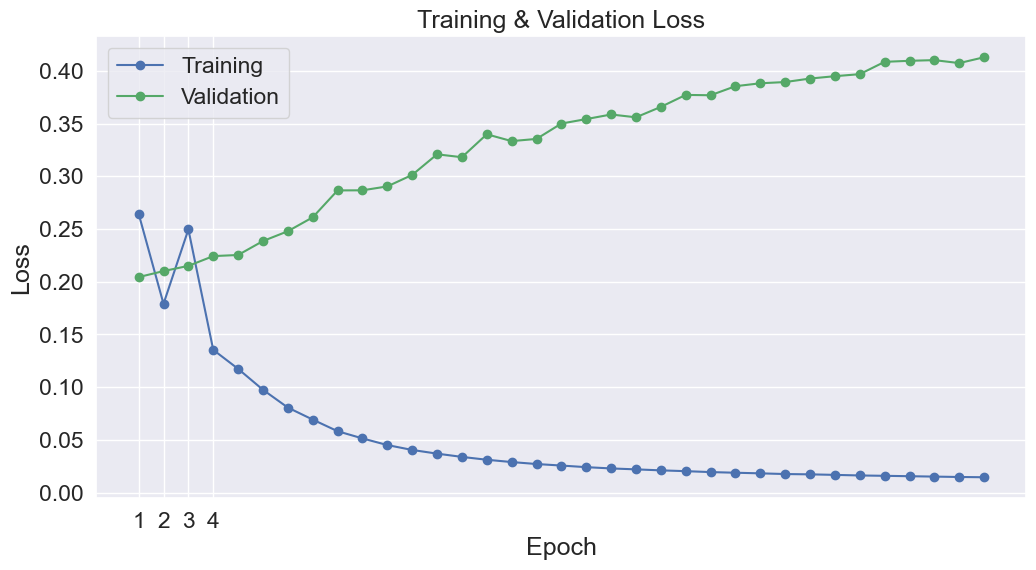

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [24]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [35]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
    generated, 
    #bos_token_id=random.randint(1,30000),
    do_sample=True,   
    top_k=50, 
    max_length = 300,
    top_p=0.95, 
    num_return_sequences=3
)

with open("output.txt", "a", encoding="utf-8") as f:
    for i, sample_output in enumerate(sample_outputs):
        outstr = "---- {} ----\n{}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True))
        outstr = outstr.replace("\\n", "\n")
        f.writelines(outstr)
        print(outstr)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
---- 0 ----
Rest Day
CrossFit Total Rules
"Schwarzenegger: Turn Off Spanish TV", NewsMax.com
Post thoughts to comments.



---- 1 ----
Complete as many rounds as possible in 7 minutes of:
205-lb. snatch, 1 rep
205-lb. clean and jerk, 3 reps
Post rounds completed to comments.



---- 2 ----
"Lynne"
Five rounds for max reps of:
Body weight bench press
Pull-ups
Post reps for both exercises in all rounds.
Compare to 060126.





In [ ]:
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro